这是一个用于临时测试代码的ipynb文件

In [1]:
import os
import re
import string
import torch
from torch import nn
from torch.nn import functional as F
if not "CHDIR_FLAG" in dir():
    os.chdir("../")
    CHDIR_FLAG = True

from transformers import AutoTokenizer, AutoModelForCausalLM

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from src.pipelines.analysis import horizontal_comparison_of_forward_hook, vertical_comparison_of_forward_hook, skip_layer_generation, easy_skip_layer_generation

In [2]:
model_home = r"D:\resource\model\huggingface"
model_names = [
    r"Qwen\Qwen2.5-0.5B-Instruct",
    r"deepseek-ai\DeepSeek-R1-Distill-Qwen-1.5B",
]

In [17]:
from torch.nn.functional import cosine_similarity
from torch import corrcoef

a = torch.rand(10)
b = a.clone()
b[-1] = 100
print(a)
print(b)
cosine_similarity(a, b, dim=0), corrcoef(torch.stack([a, b]))[0, 1]

tensor([0.8261, 0.0089, 0.2129, 0.8023, 0.3558, 0.6660, 0.3179, 0.7922, 0.7247,
        0.5821])
tensor([8.2613e-01, 8.9000e-03, 2.1286e-01, 8.0226e-01, 3.5576e-01, 6.6596e-01,
        3.1792e-01, 7.9221e-01, 7.2470e-01, 1.0000e+02])


(tensor(0.3266), tensor(0.0744))

# 测试 horizontal_comparison_of_forward_hook

In [3]:
forward_hook_module_names = \
    [f"model.layers[{i}].self_attn.q_proj" for i in range(24)] + \
    [f"model.layers[{i}].self_attn.k_proj" for i in range(24)] + \
    [f"model.layers[{i}].self_attn.v_proj" for i in range(24)]

hook_data_path_1_1 = r"./results/strawberry-1/fhook+Qwen2.5-0.5B-Instruct+False.pt"
hook_data_path_1_2 = r"./results/strawberry-1/fhook+Qwen2.5-0.5B-Instruct+True.pt"
hook_data_path_2_1 = r"./results/strawberry-2/fhook+Qwen2.5-0.5B-Instruct+False.pt"
hook_data_path_2_2 = r"./results/strawberry-2/fhook+Qwen2.5-0.5B-Instruct+True.pt"

table_path_1_1 = r"./results/strawberry-1/decode+Qwen2.5-0.5B-Instruct+False.csv"
table_path_1_2 = r"./results/strawberry-1/decode+Qwen2.5-0.5B-Instruct+True.csv"
table_path_2_1 = r"./results/strawberry-2/decode+Qwen2.5-0.5B-Instruct+False.csv"
table_path_2_2 = r"./results/strawberry-2/decode+Qwen2.5-0.5B-Instruct+True.csv"

0


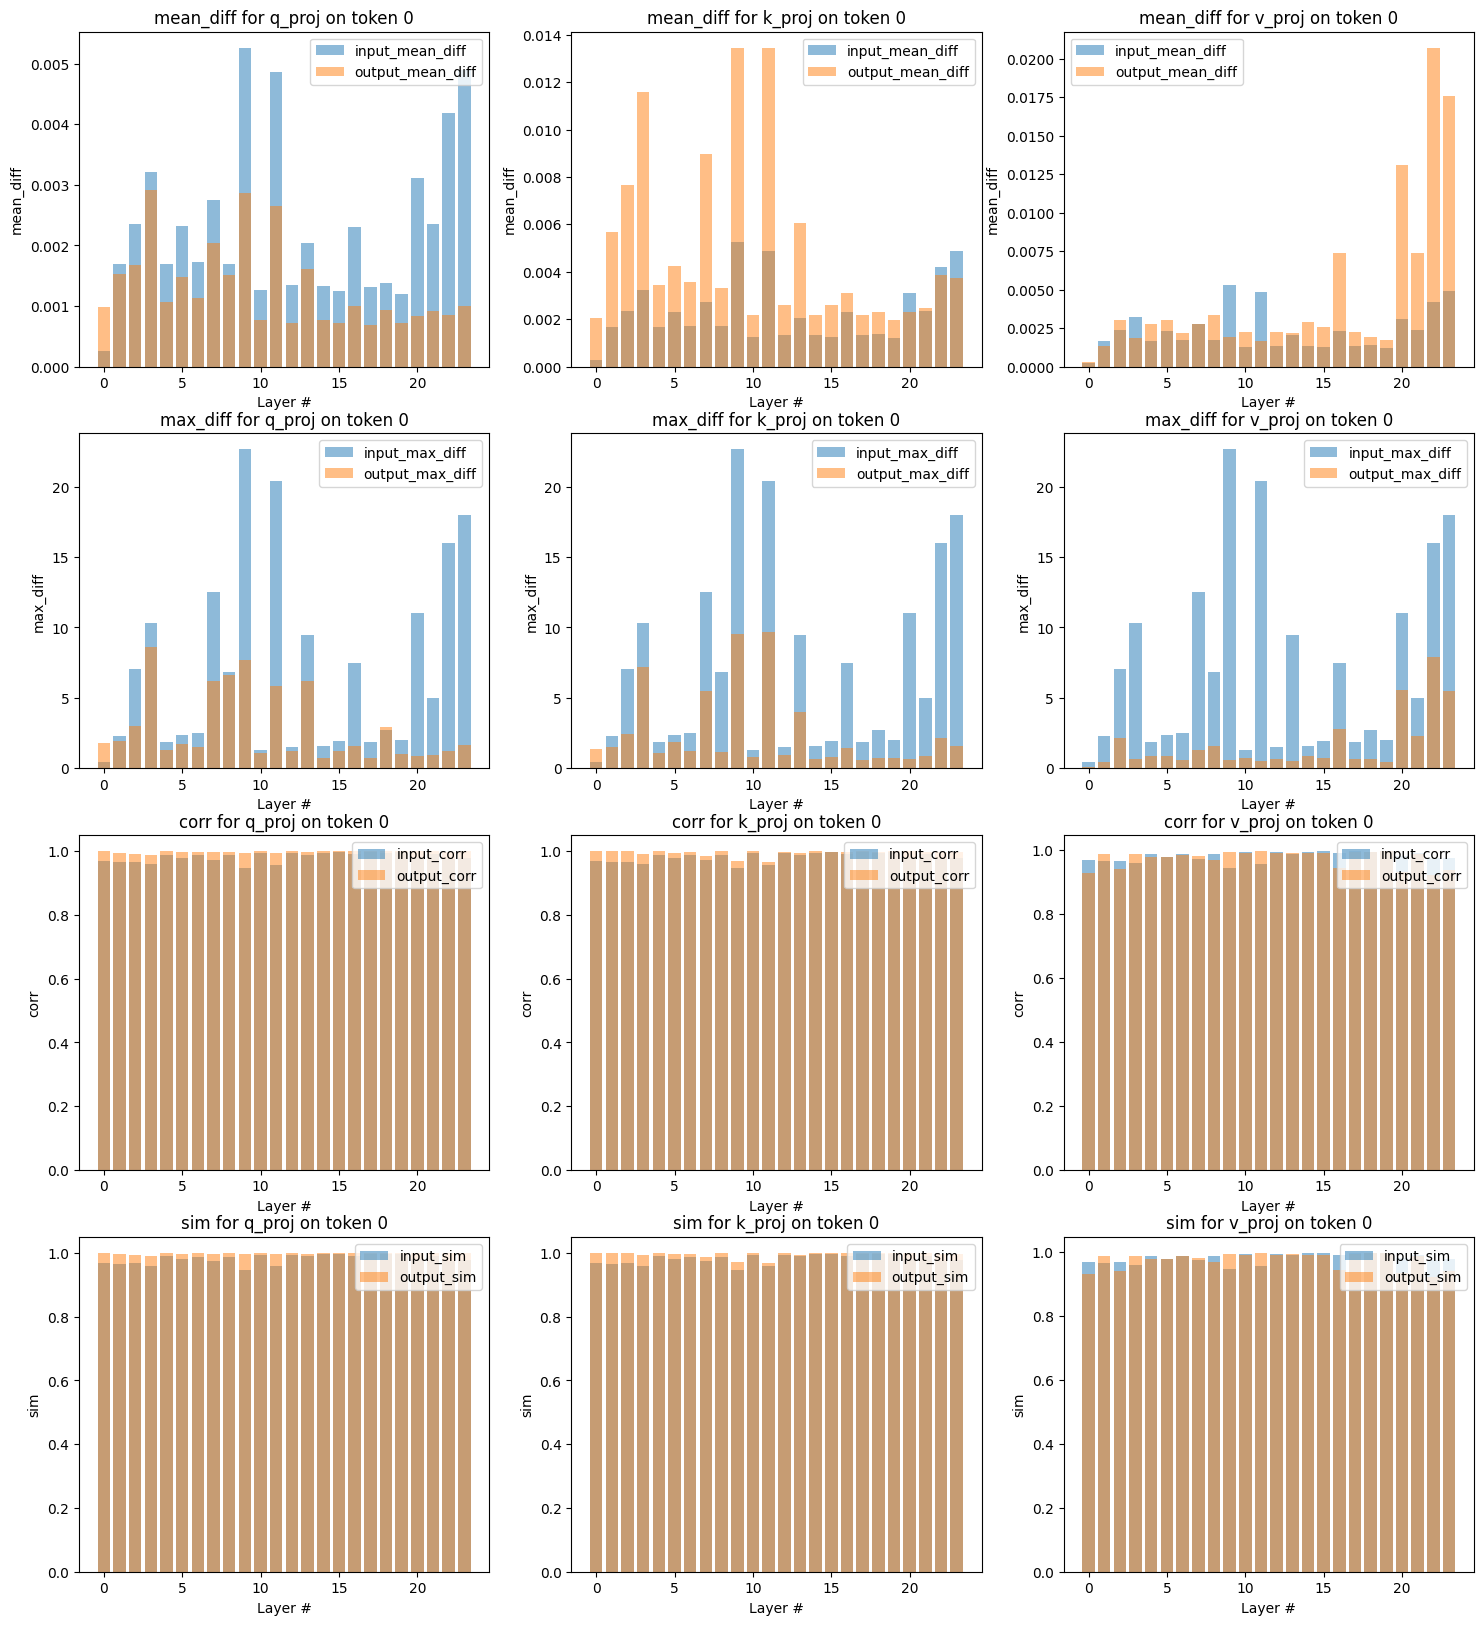

1


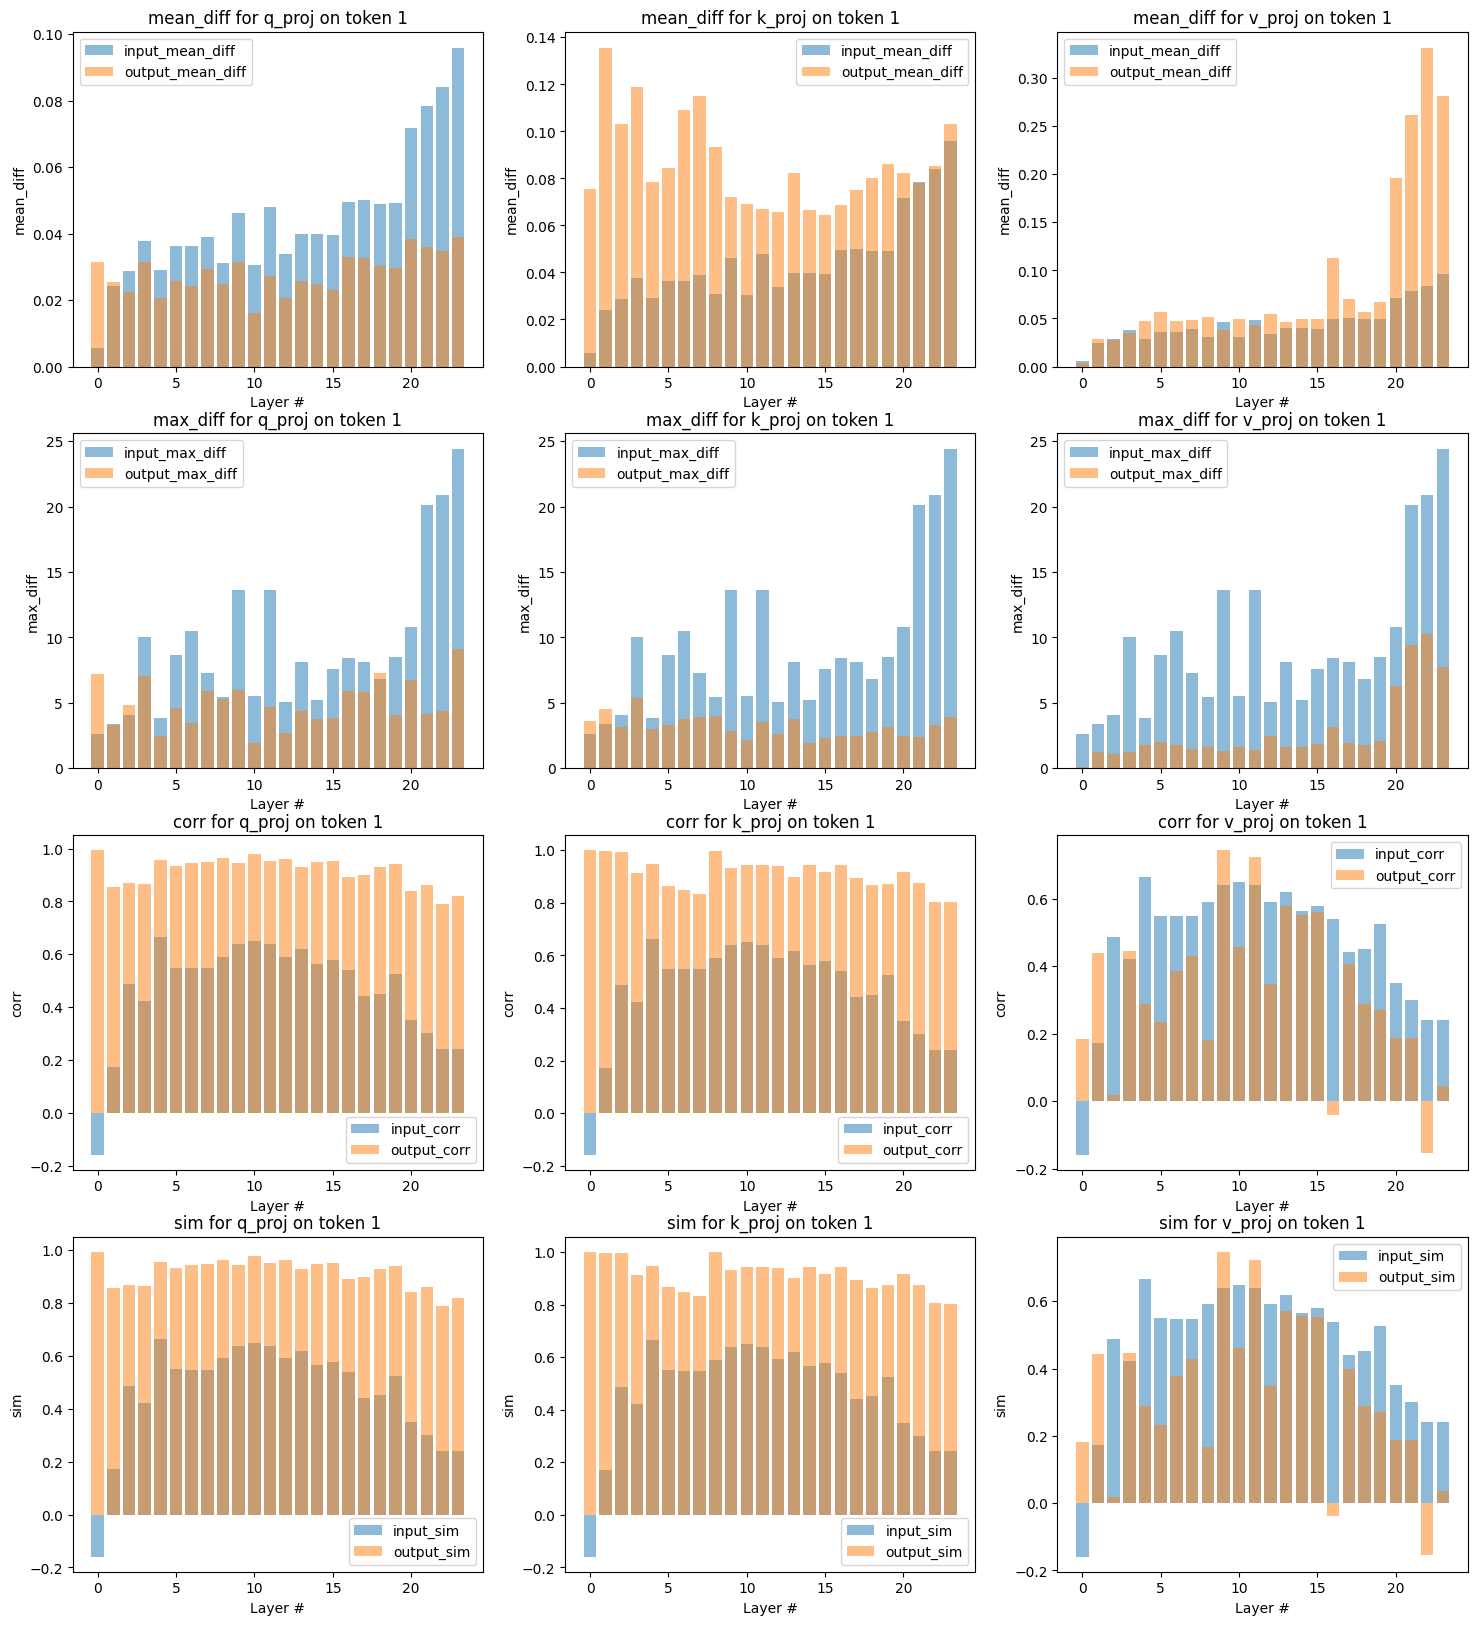

2


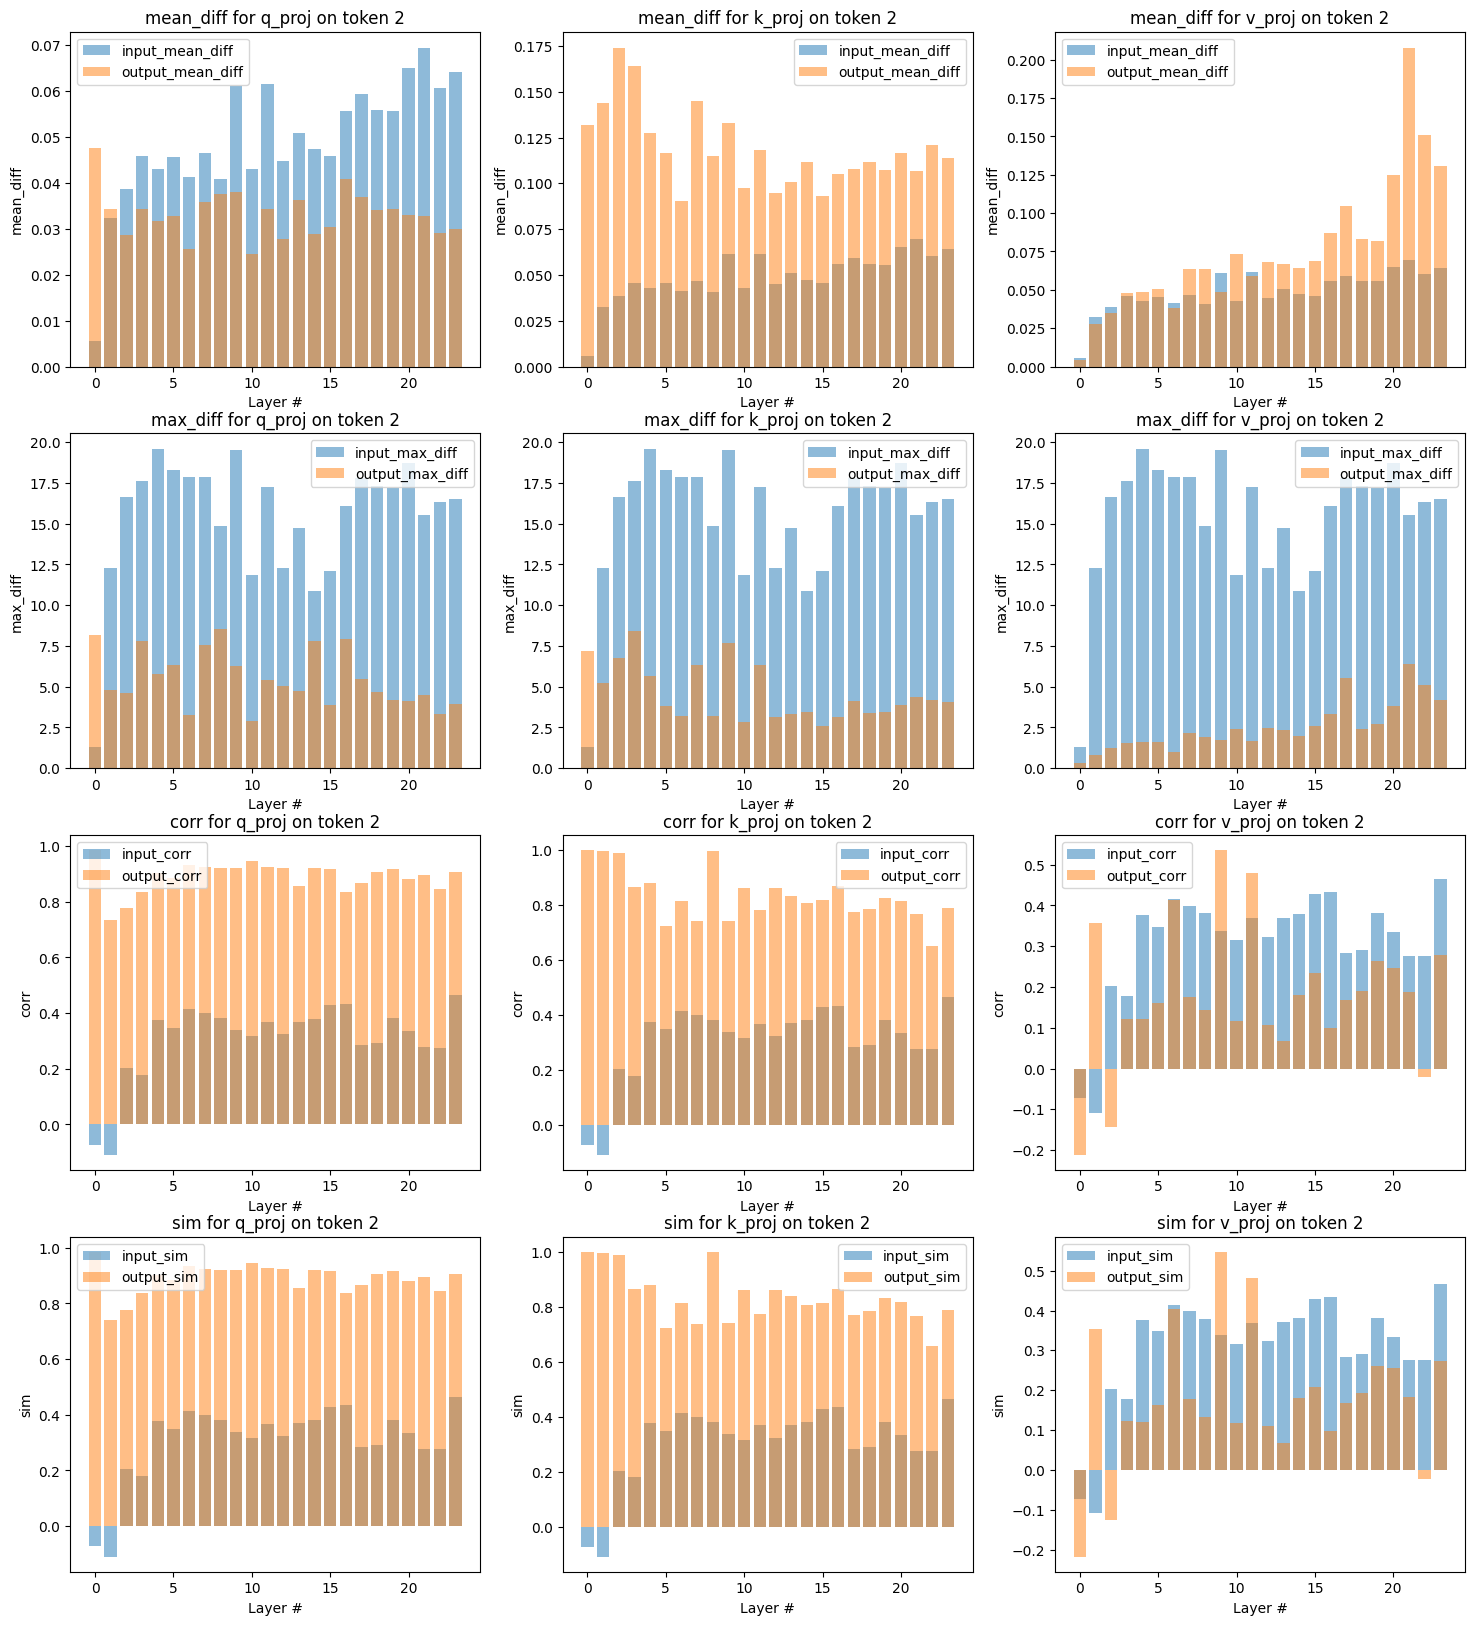

3


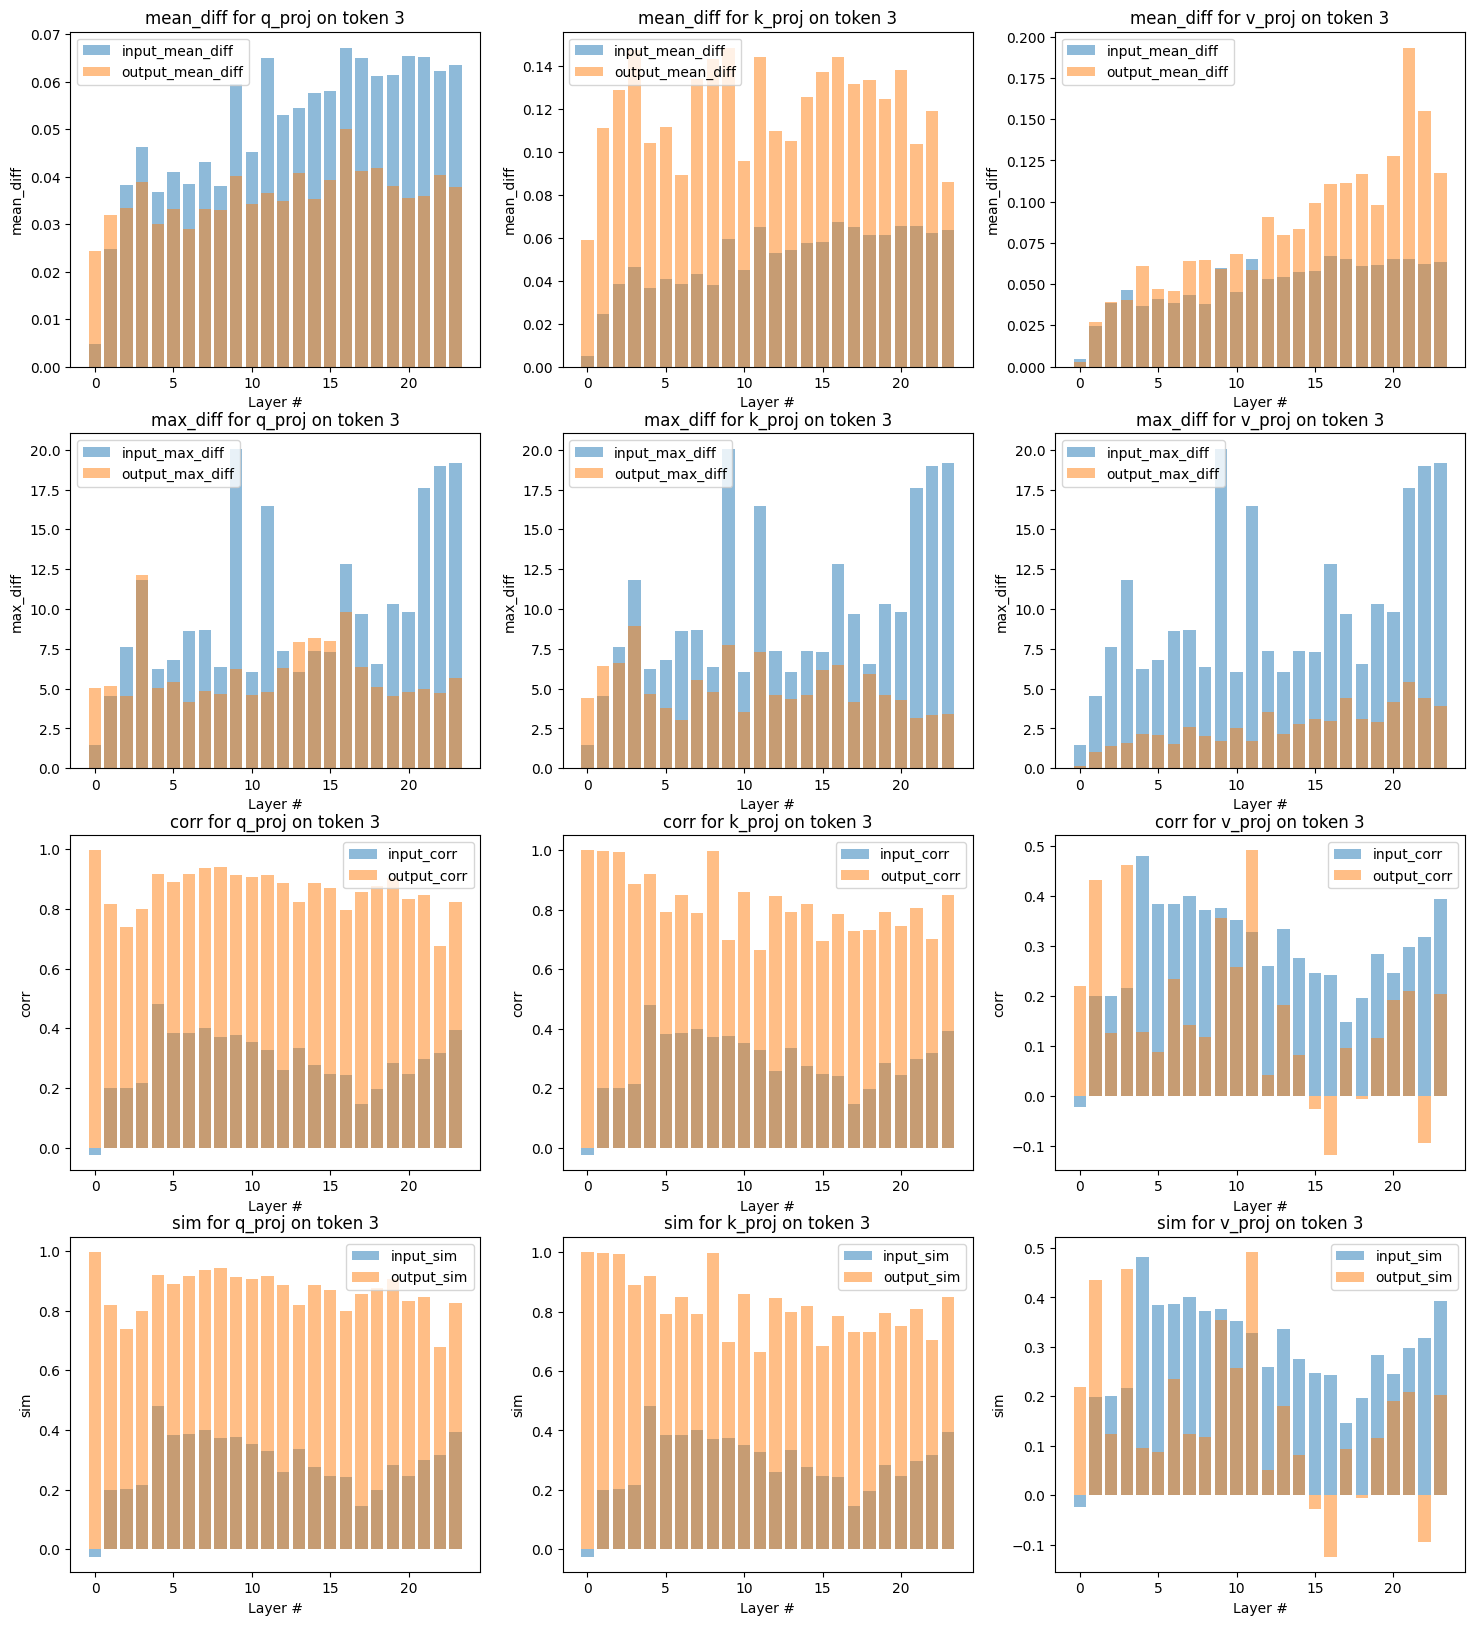

4


In [4]:
horizontal_comparison_of_forward_hook(
    hook_datas = None,
    hook_data_paths = [hook_data_path_1_2, hook_data_path_2_2],
    hook_module_names = forward_hook_module_names[:],
    hook_module_name_suffixes = ["q_proj", "k_proj", "v_proj"],
    comparison_index = ["mean_diff", "max_diff", "corr", "sim"],
    max_length = 4,
)

# 测试 vertical_comparison_of_forward_hook

观察结论：
- 第0层输入输出虽然diff很小，但是相关系数非常低，说明语义在这一层做了一个很大的变换，可能是旋转之类的，所以第0层非常重要
- 第1层基本上的相似度也是显著低于其余层的

In [5]:
hook_data_paths = [
    r"./results/strawberry-X-4/fhook+Qwen2.5-0.5B-Instruct+True-0.pt",
    r"./results/longlong-1/fhook+Qwen2.5-0.5B-Instruct+True-0.pt",
    r"./results/prime-1/fhook+Qwen2.5-0.5B-Instruct+True-0.pt",
    r"./results/table-1/fhook+Qwen2.5-0.5B-Instruct+True-1.pt",
    r"./results/strawberry-X-3/fhook+DeepSeek-R1-Distill-Qwen-1.5B+True-0.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+False-0.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+False-1.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+False-2.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+False-3.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+True-0.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+True-1.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+True-2.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+True-3.pt",
]

## Strawberry

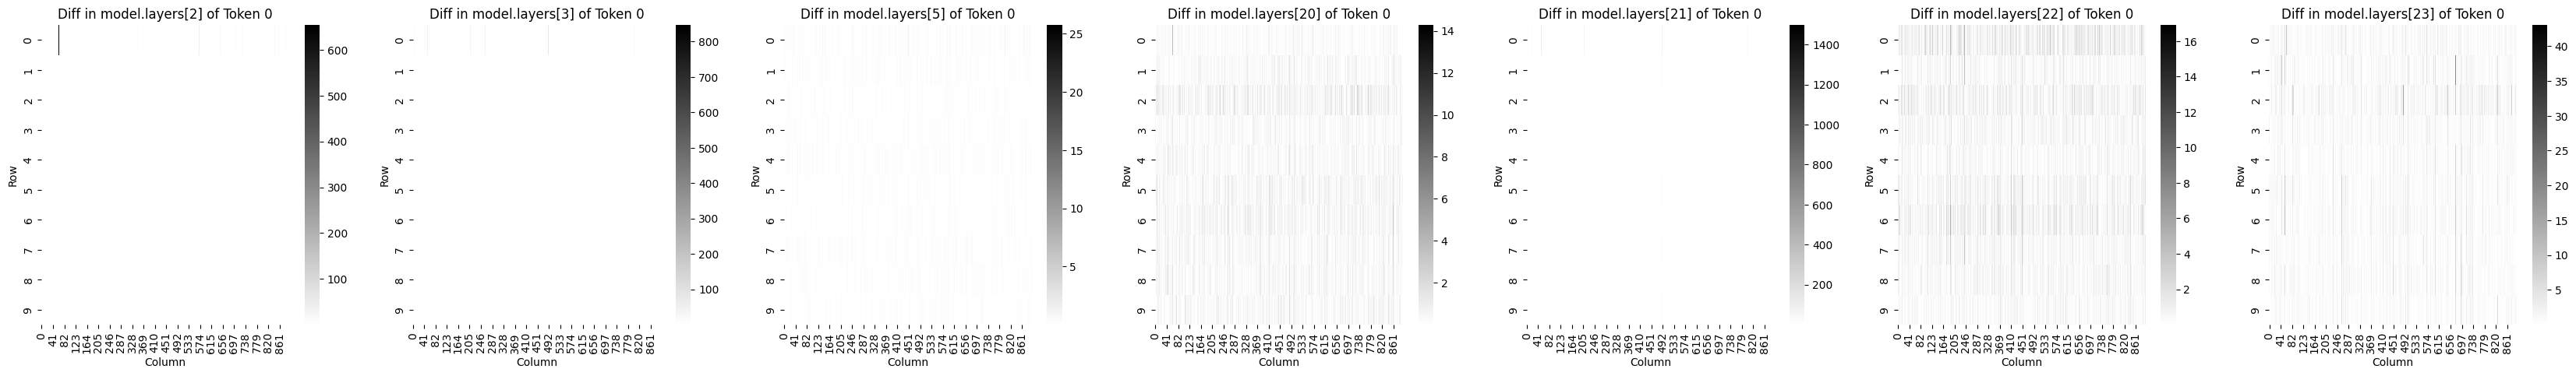

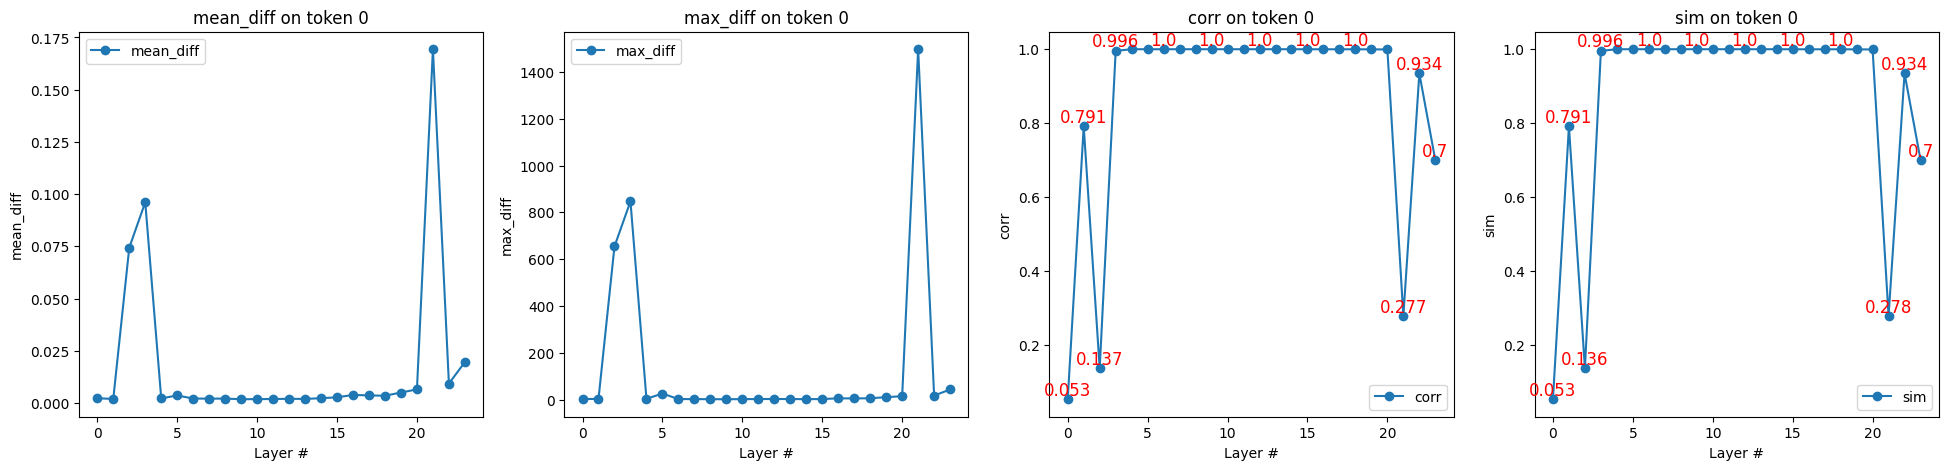

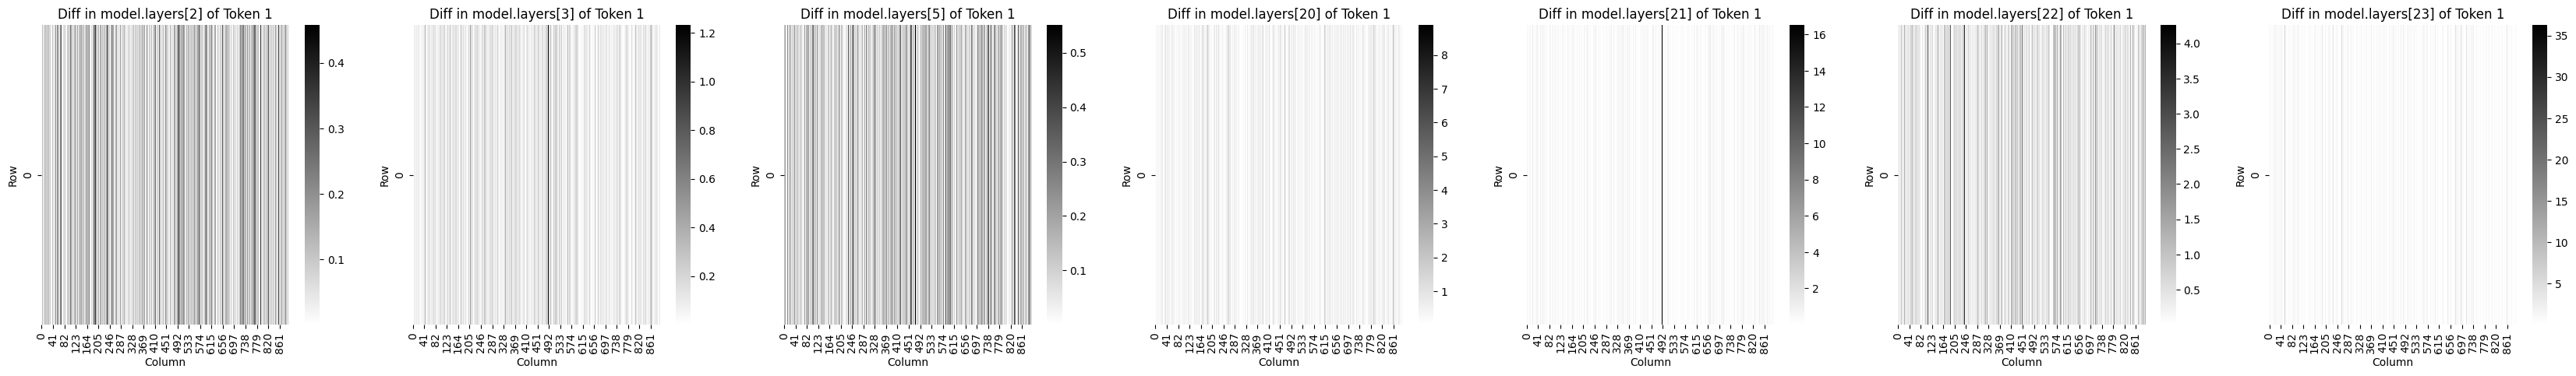

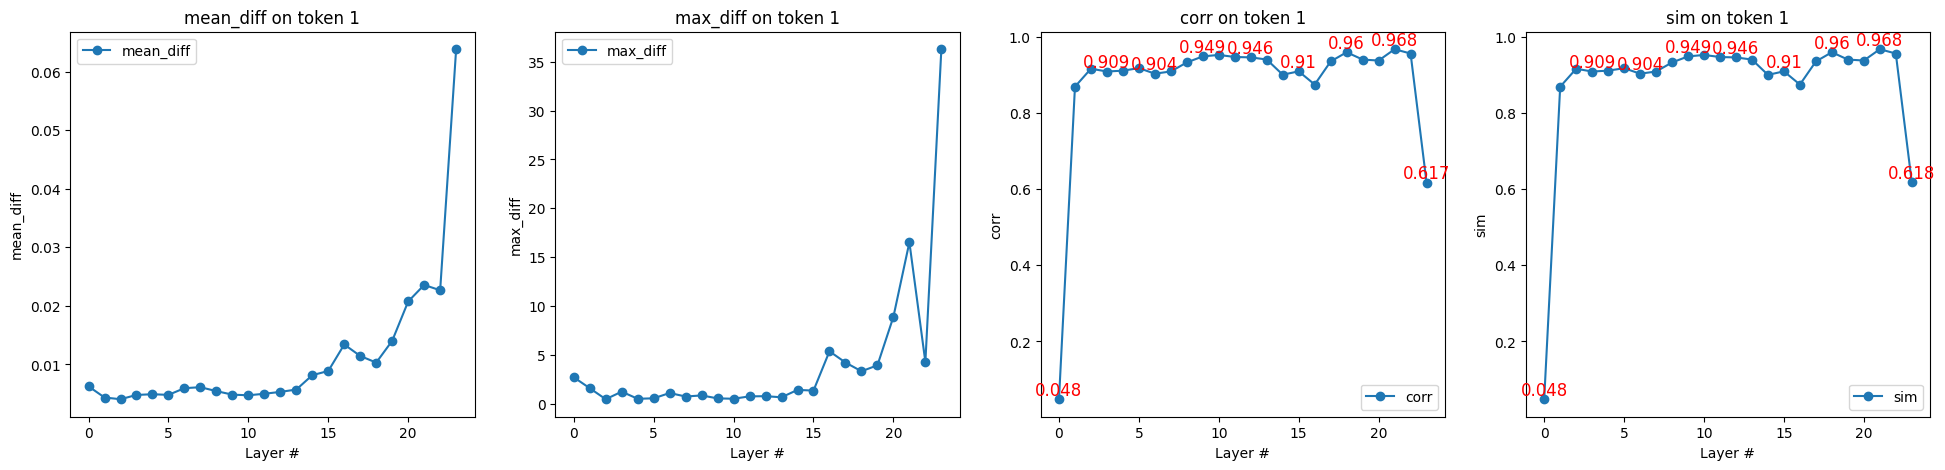

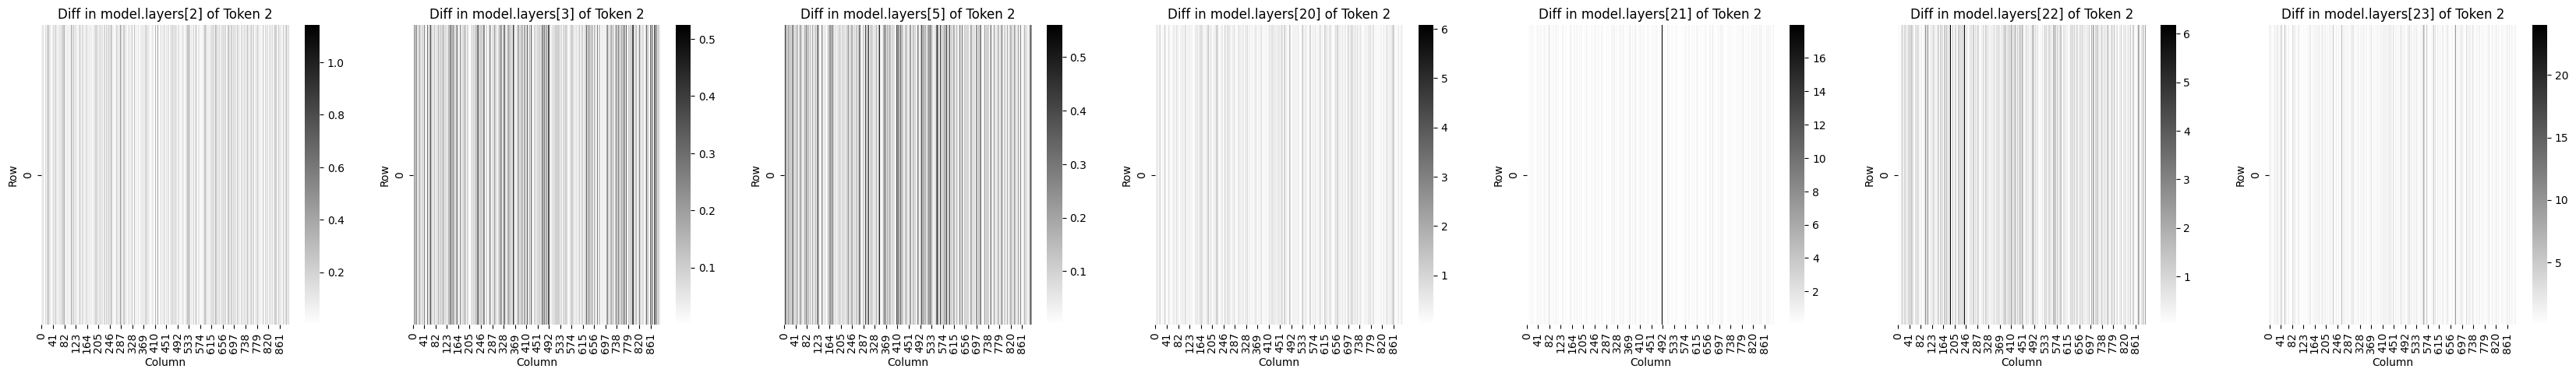

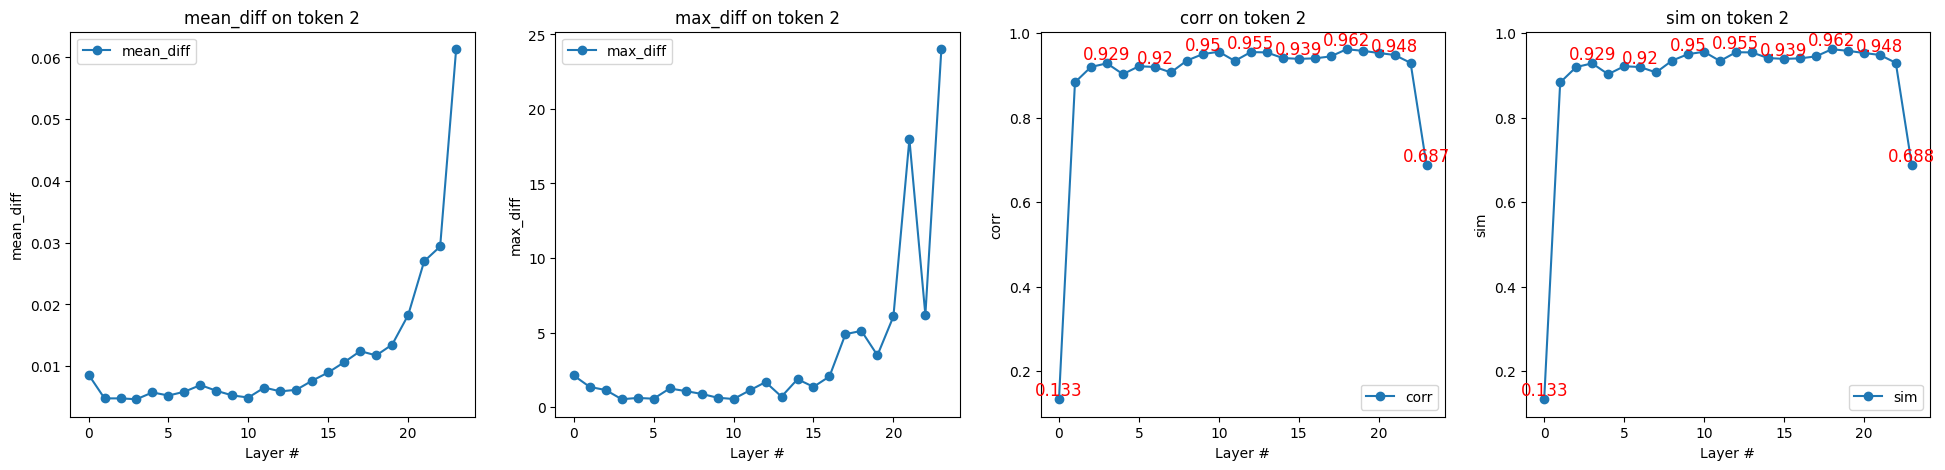

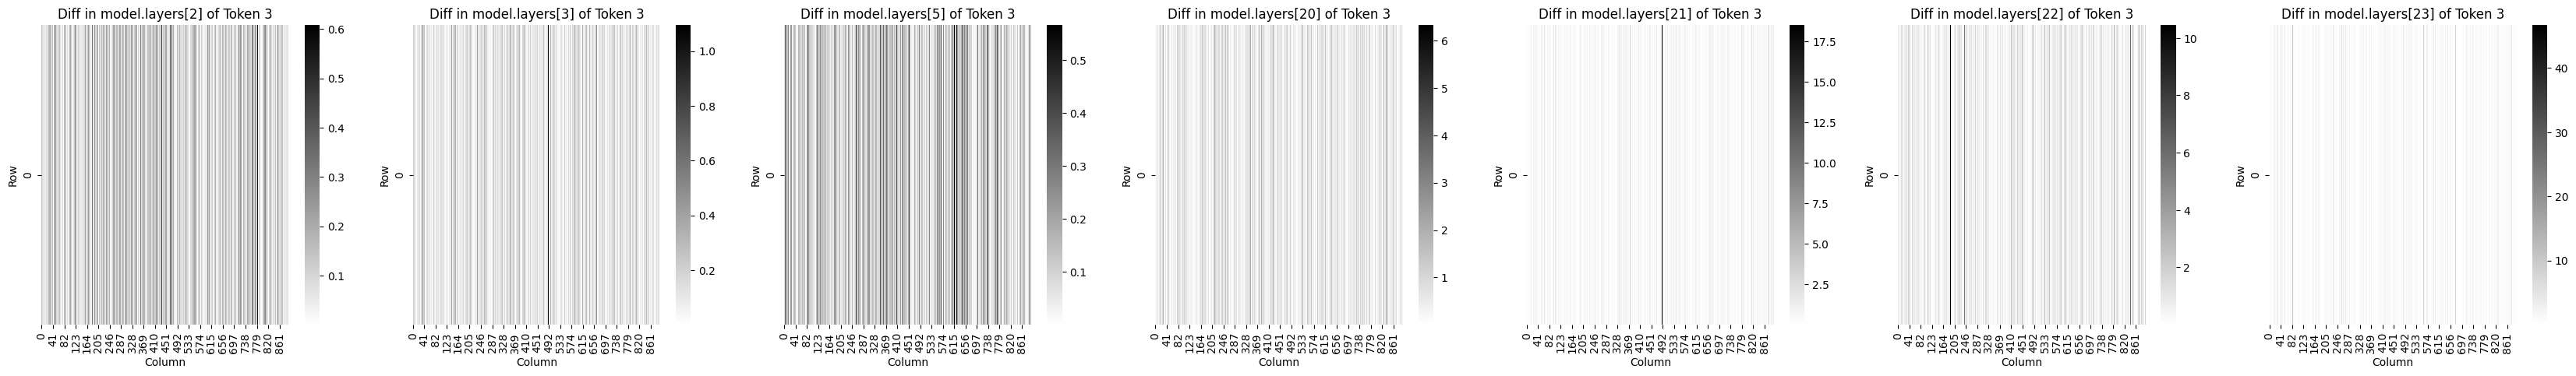

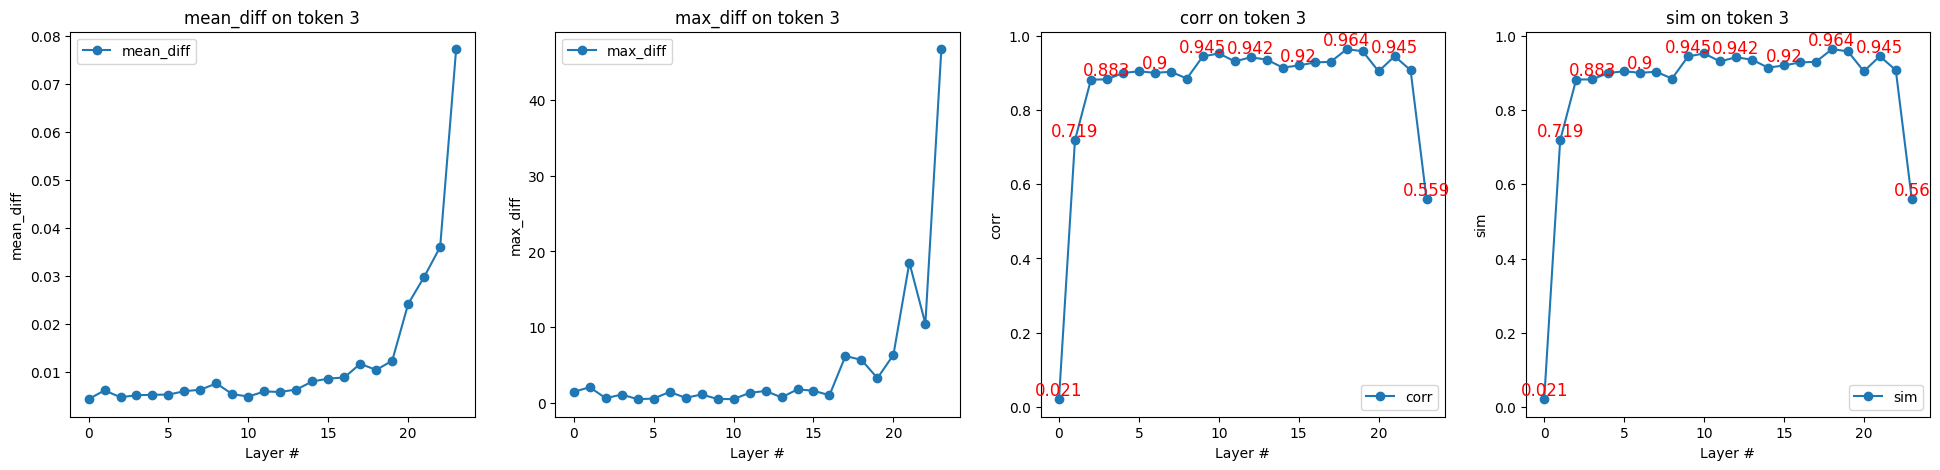

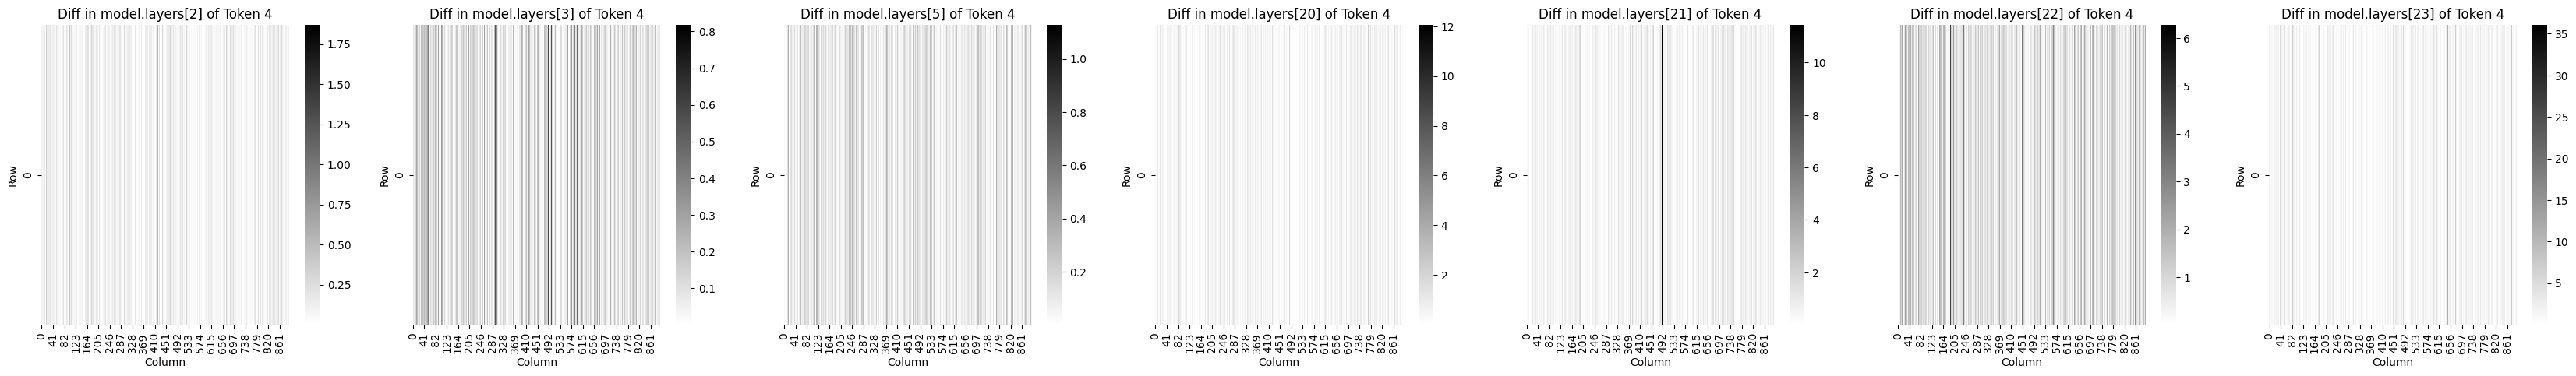

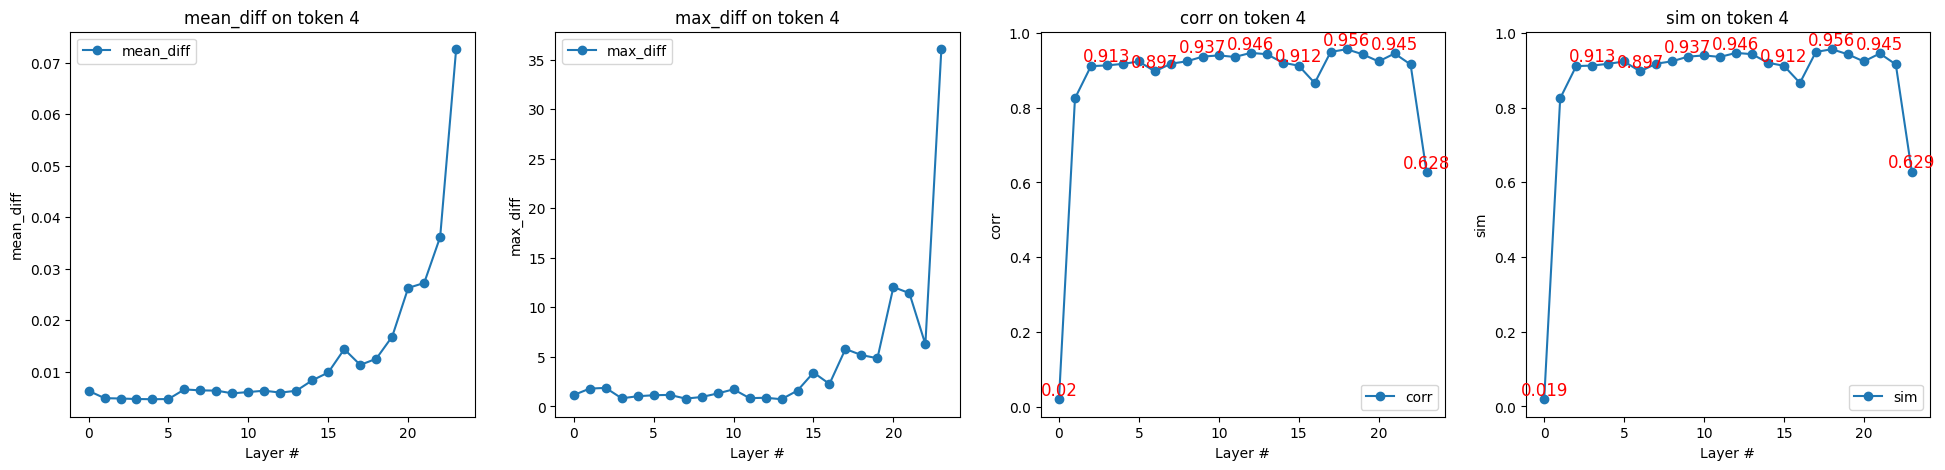

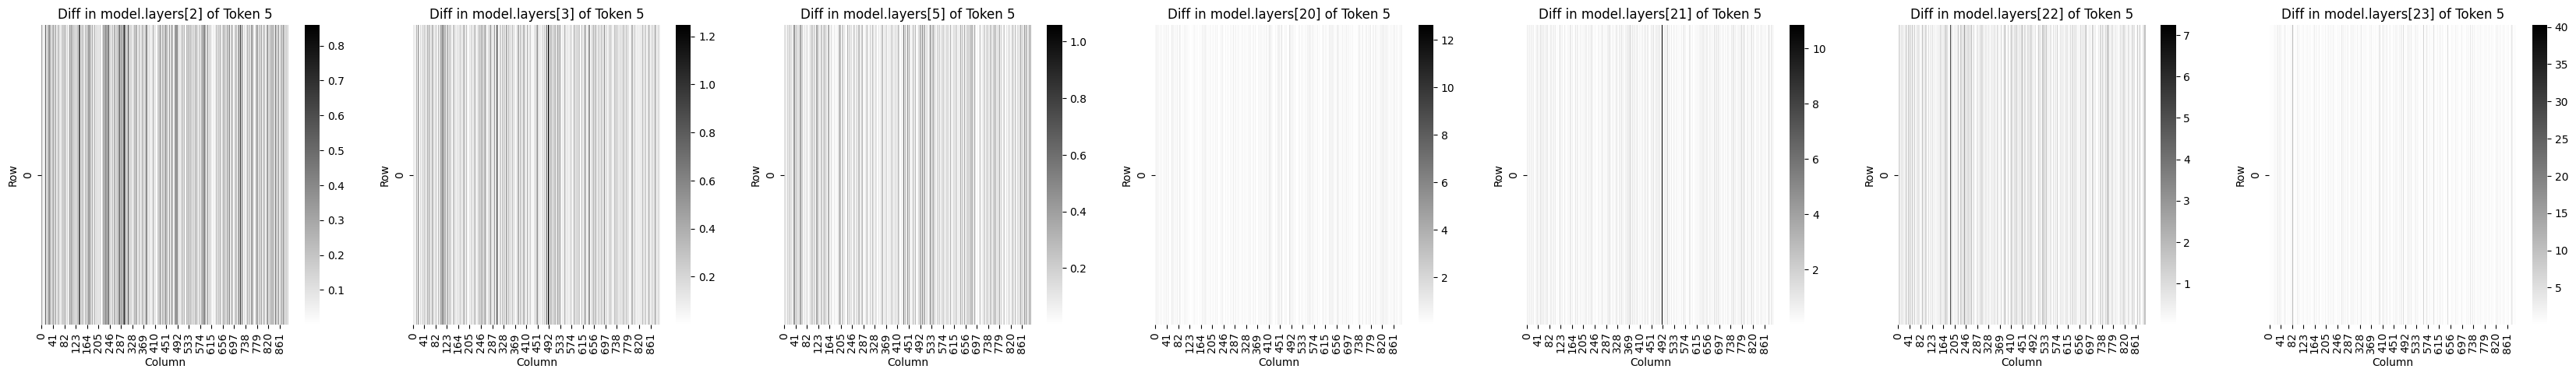

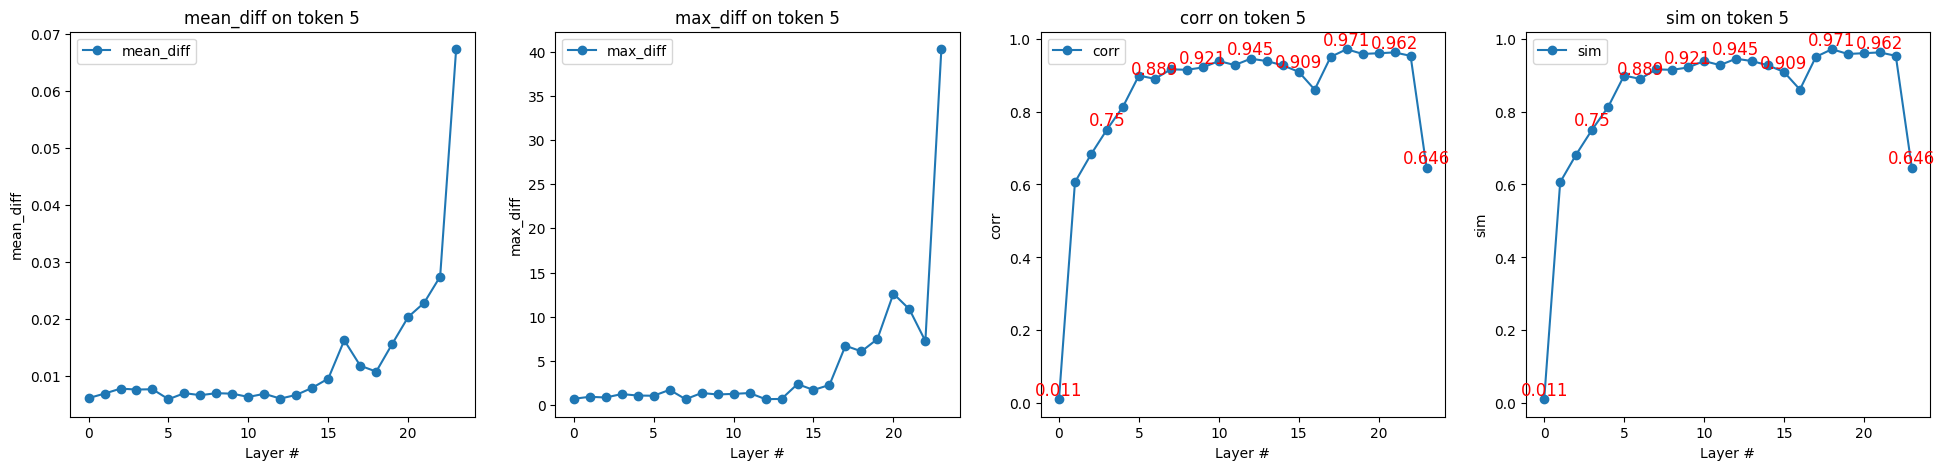

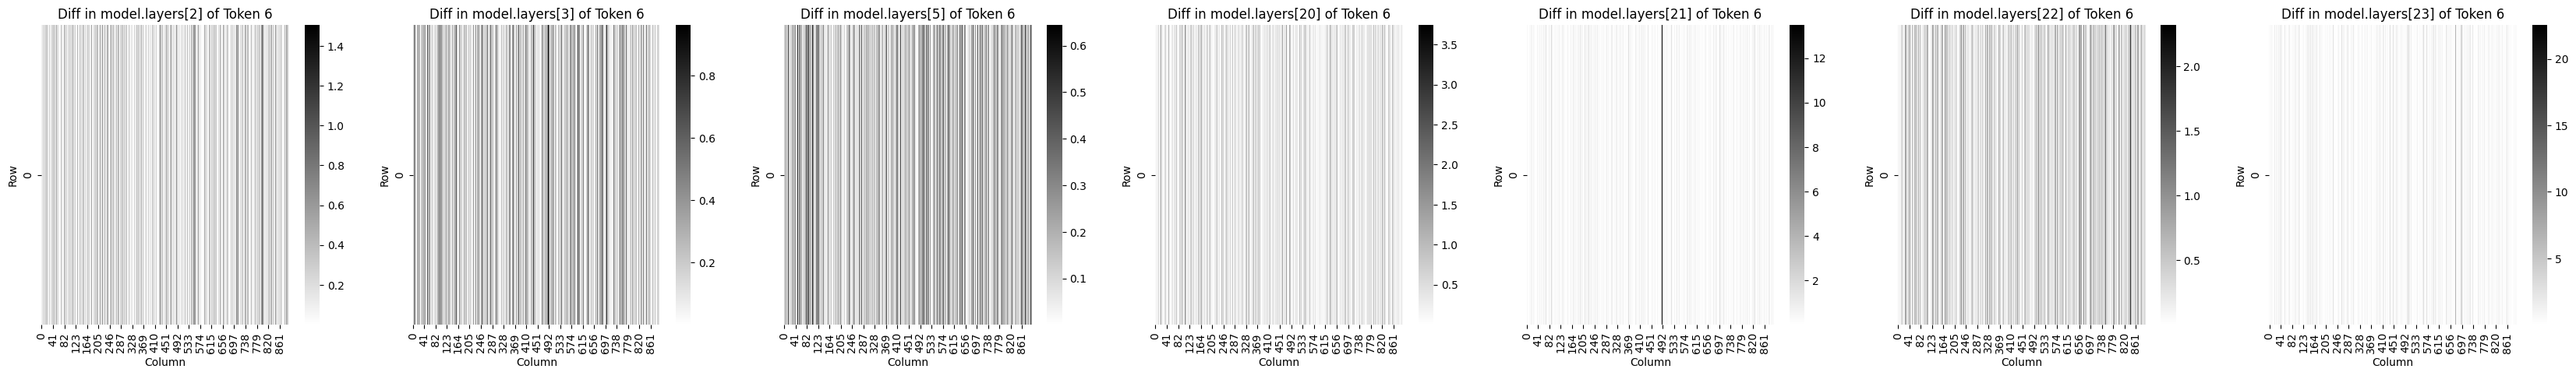

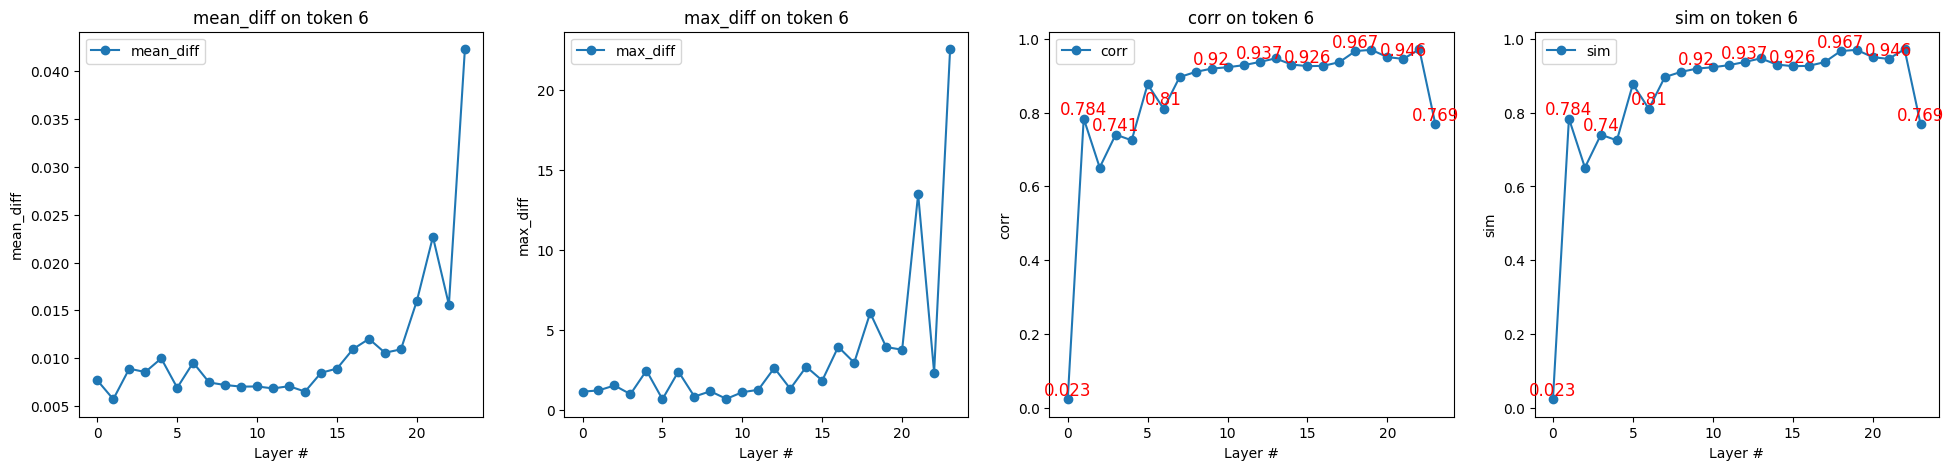

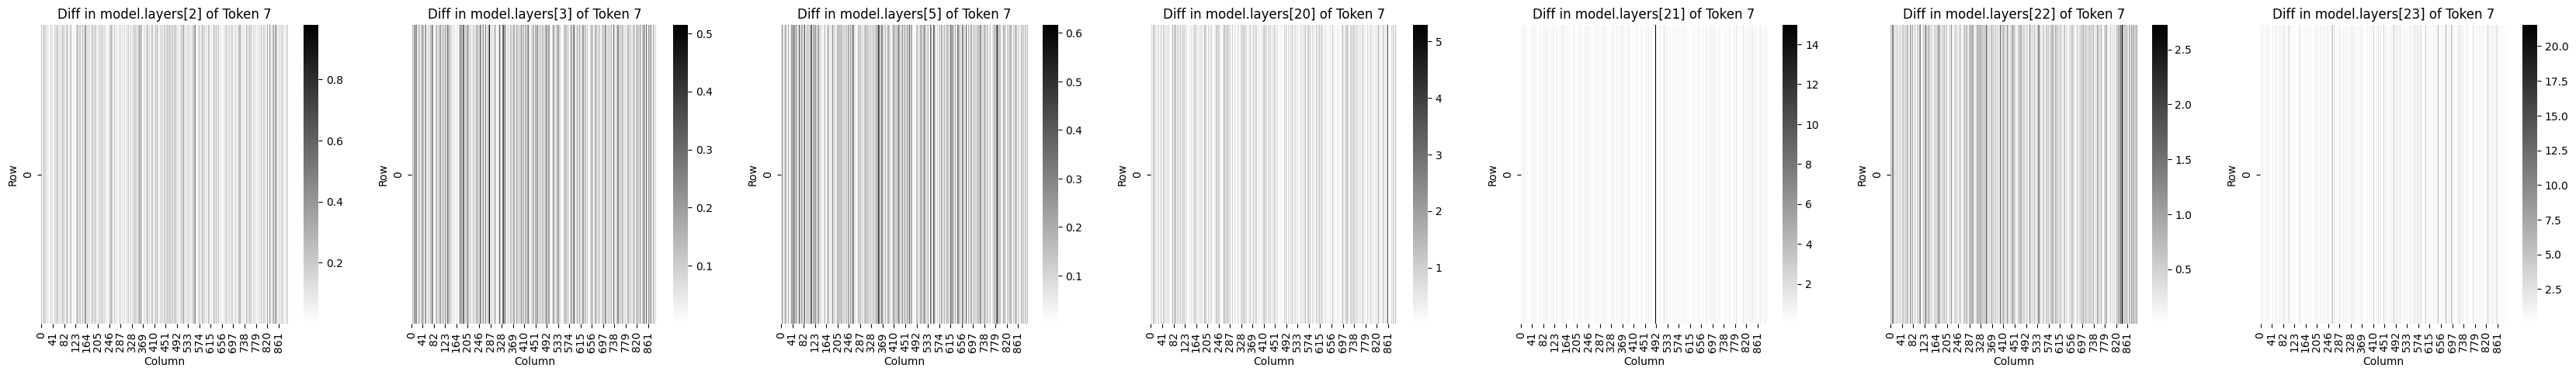

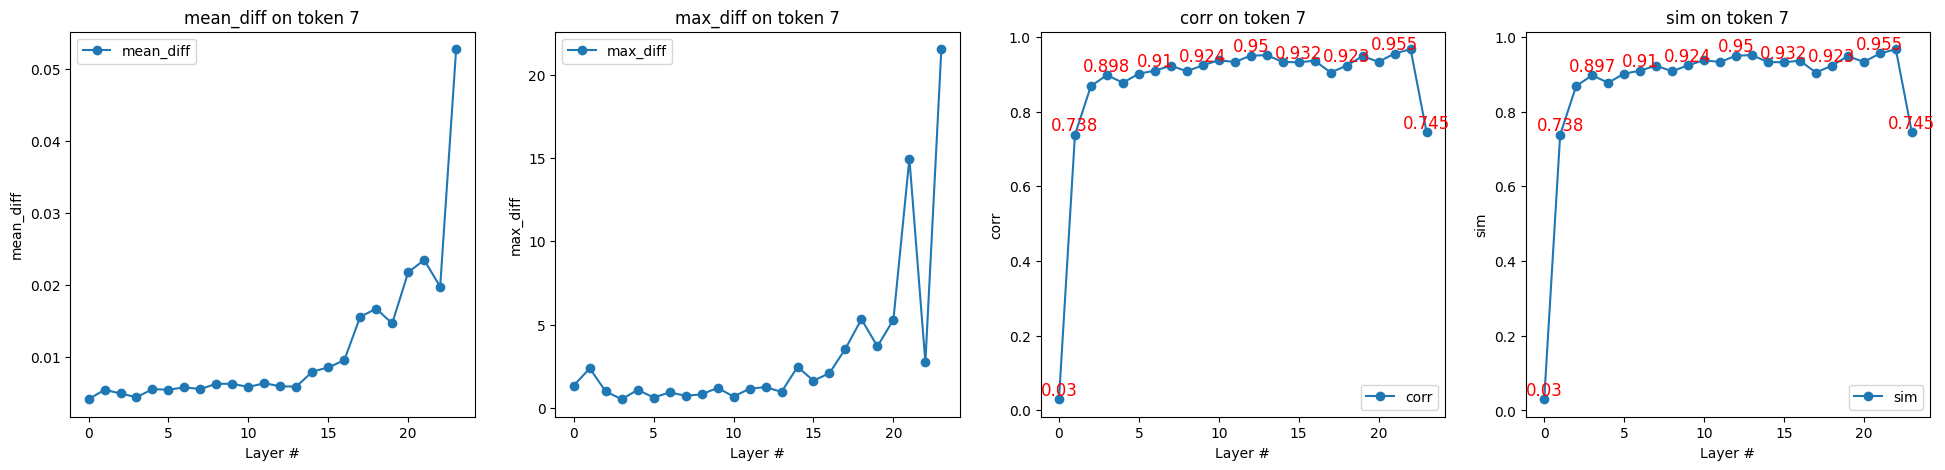

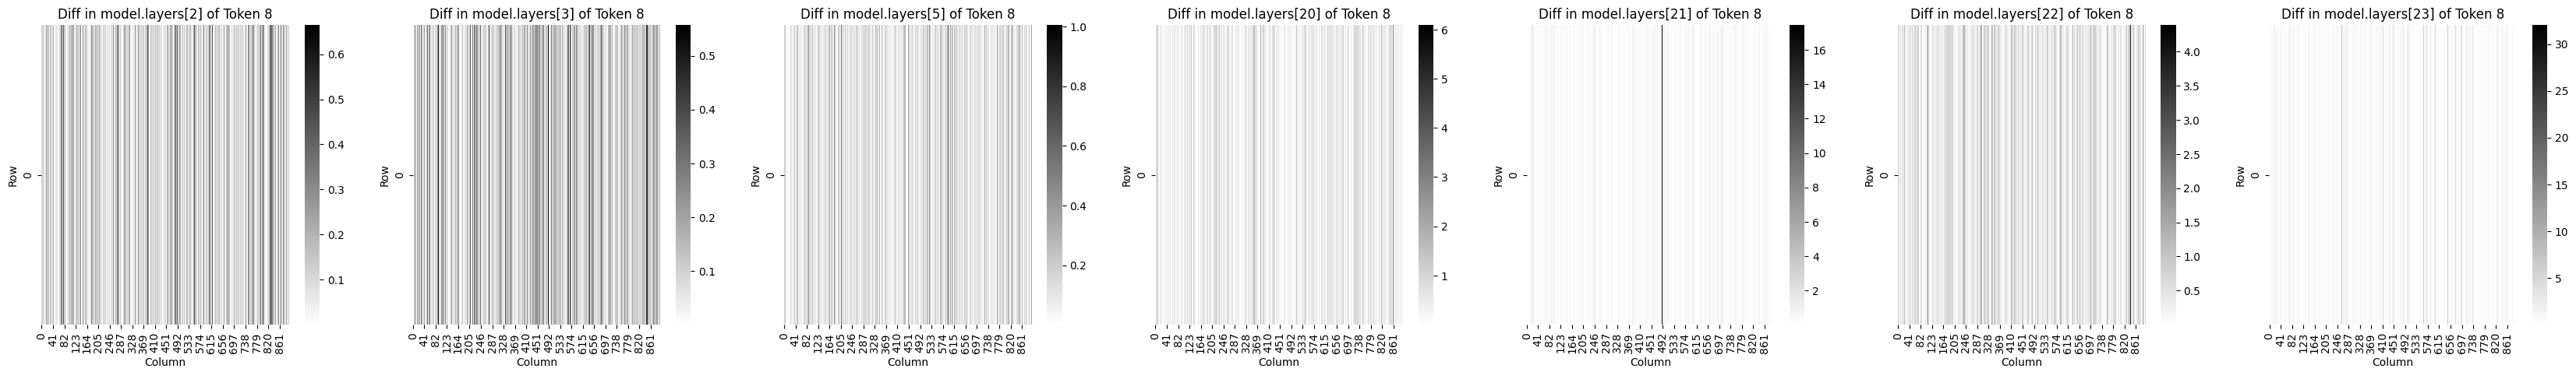

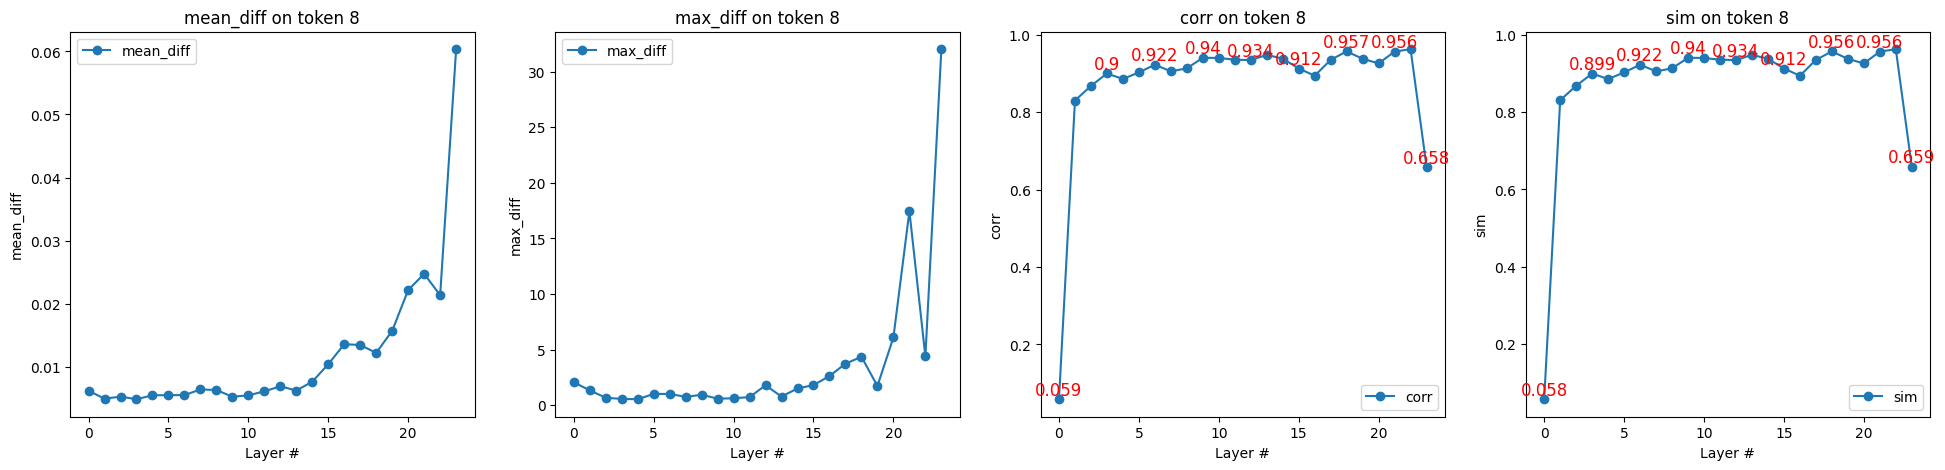

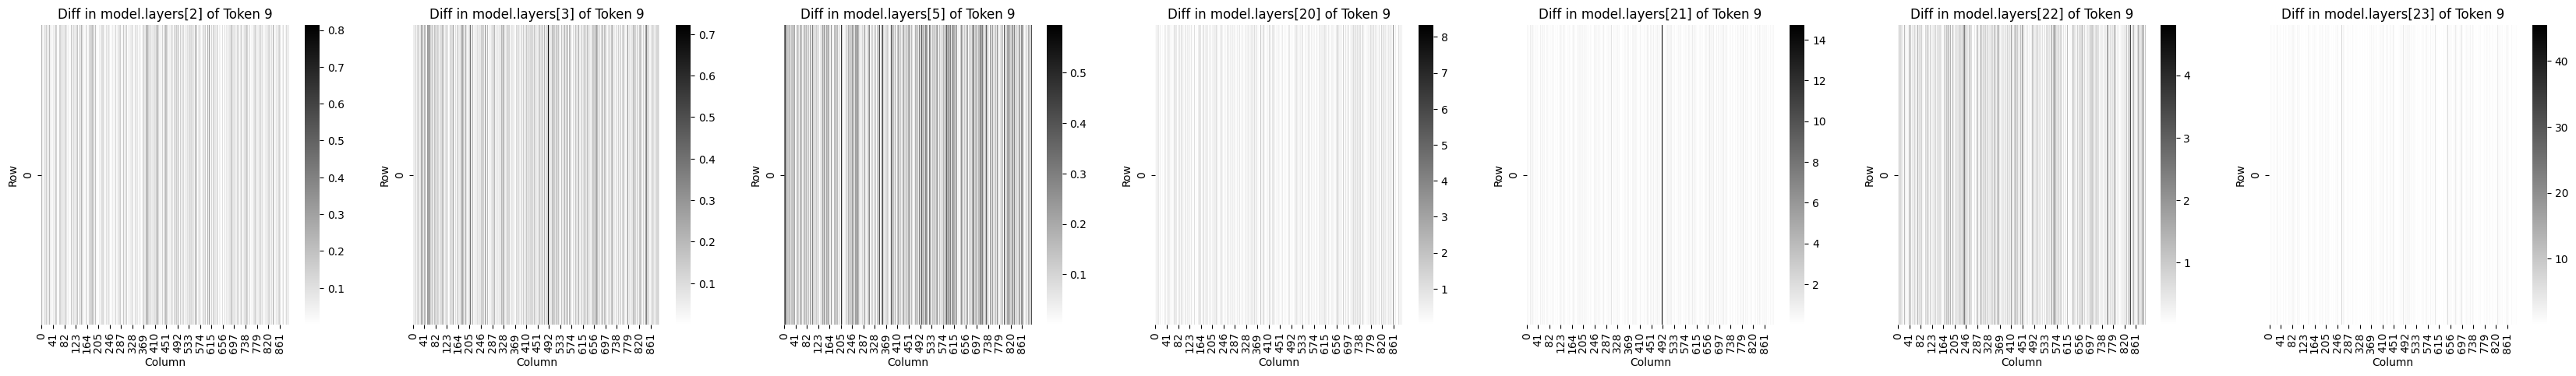

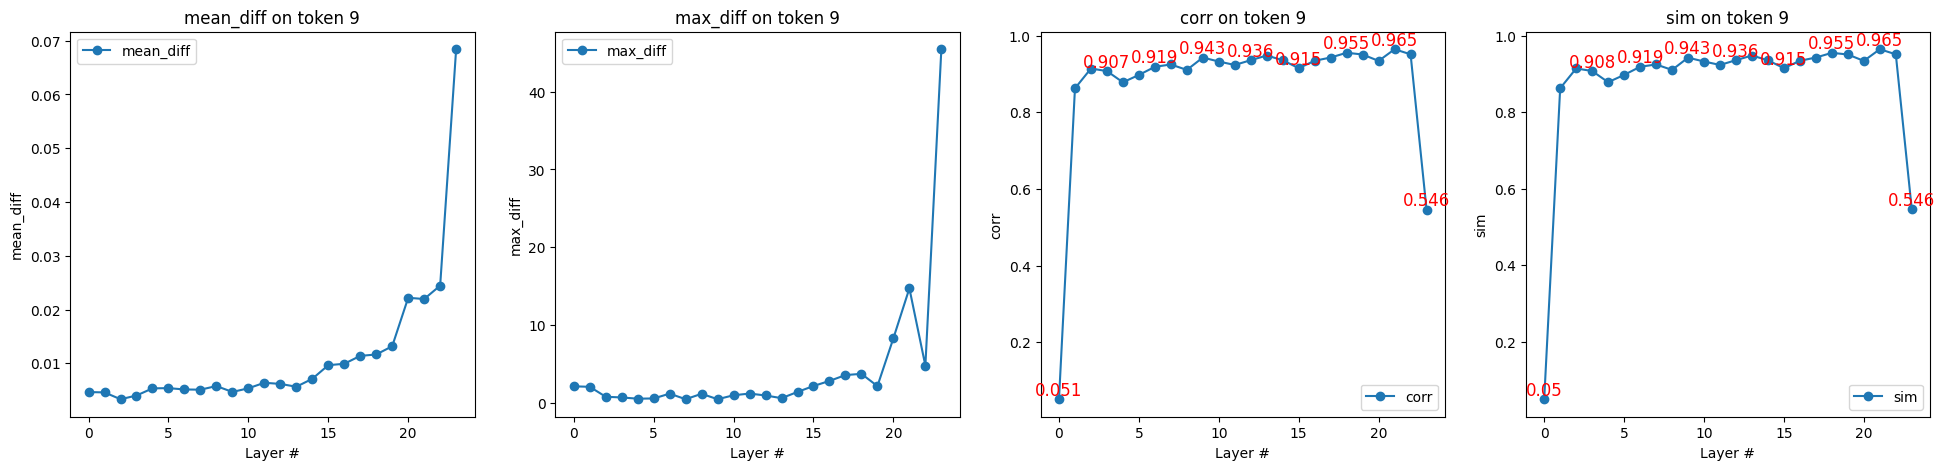

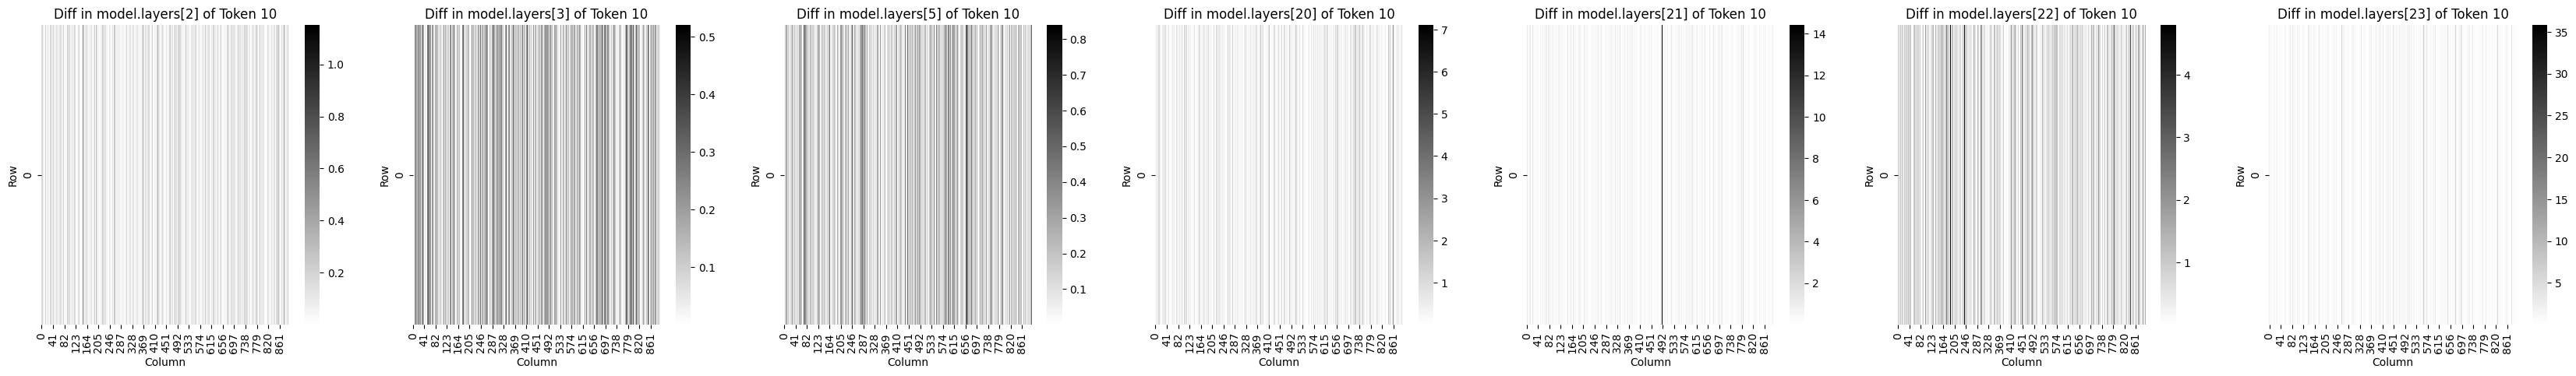

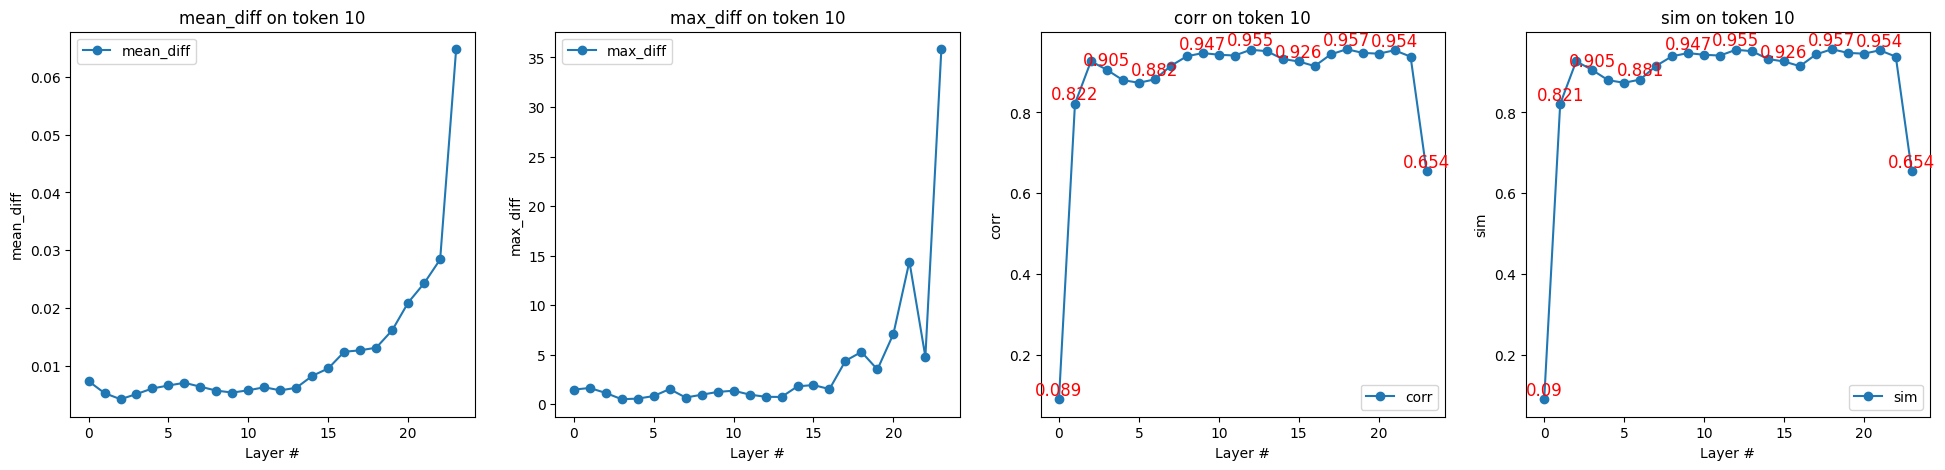

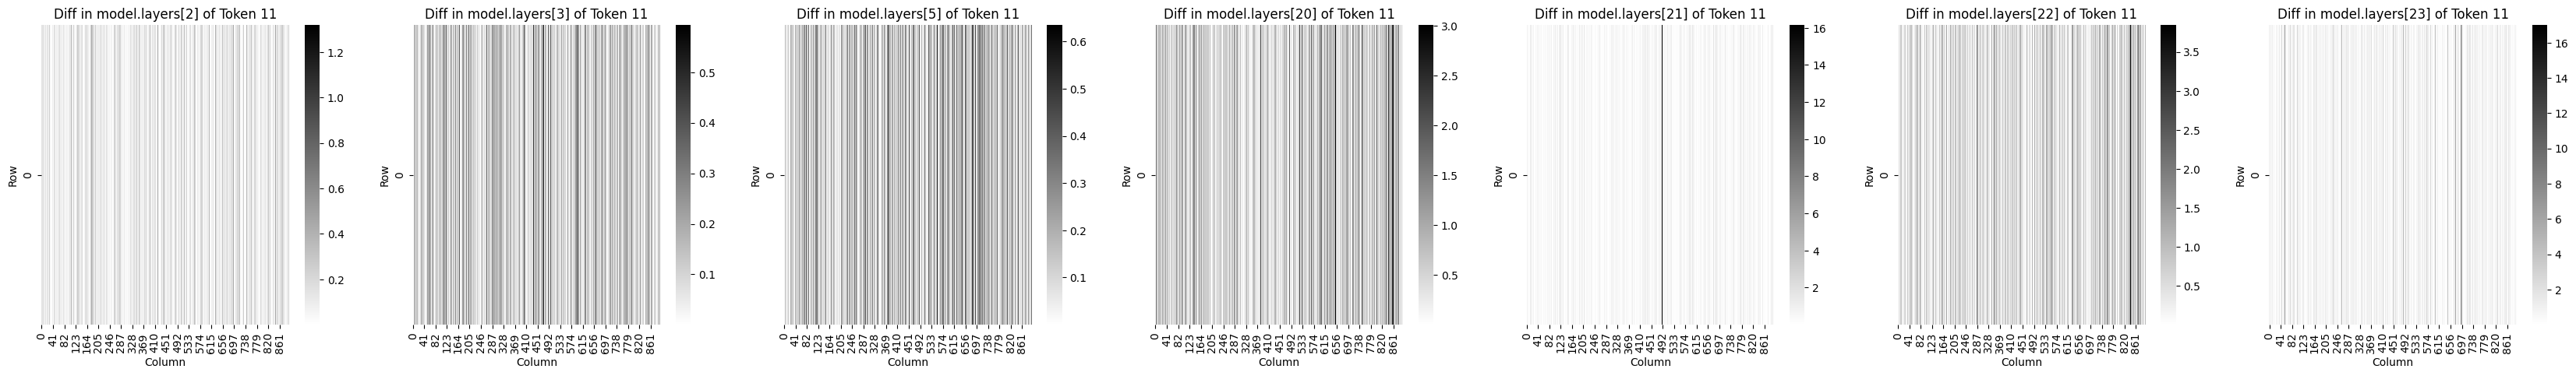

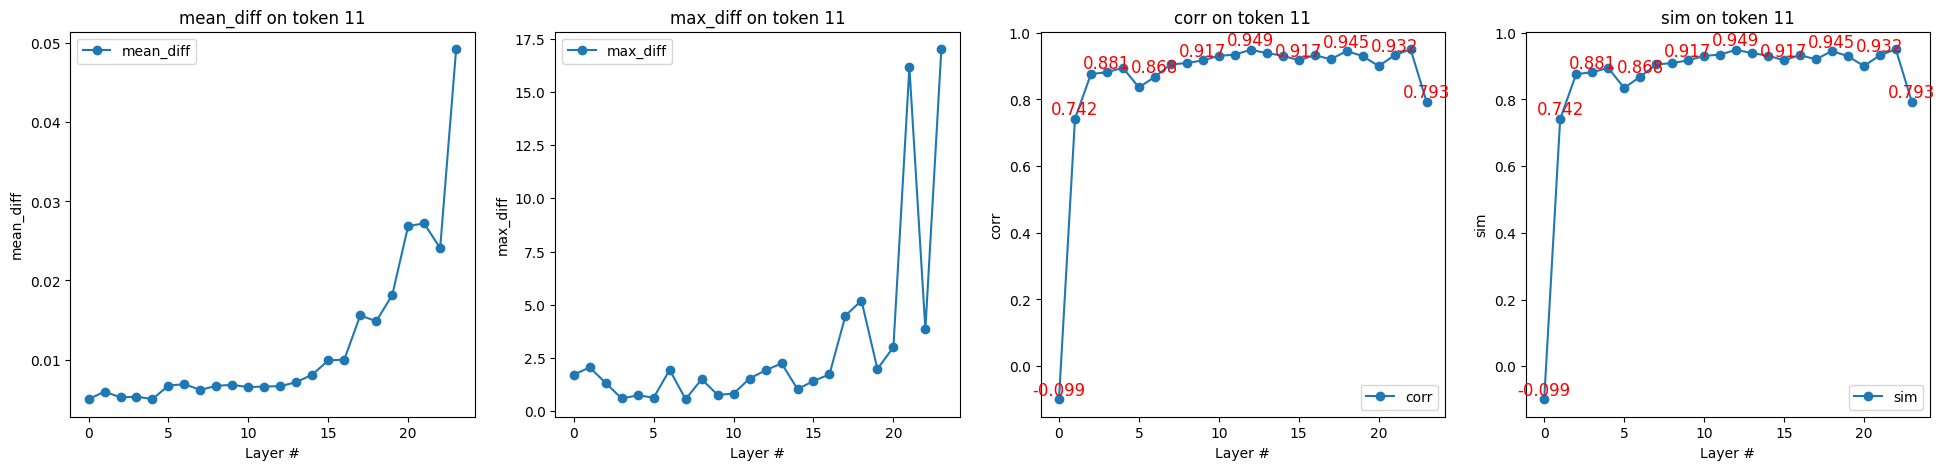

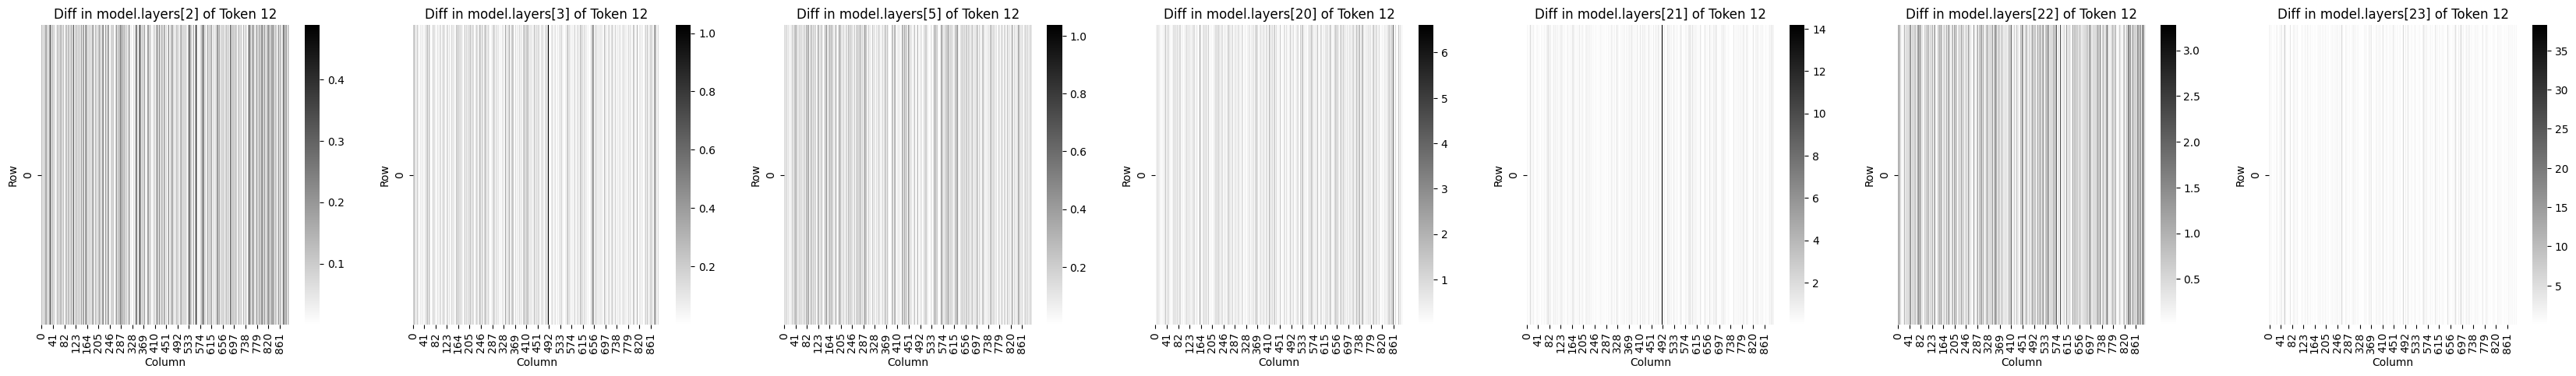

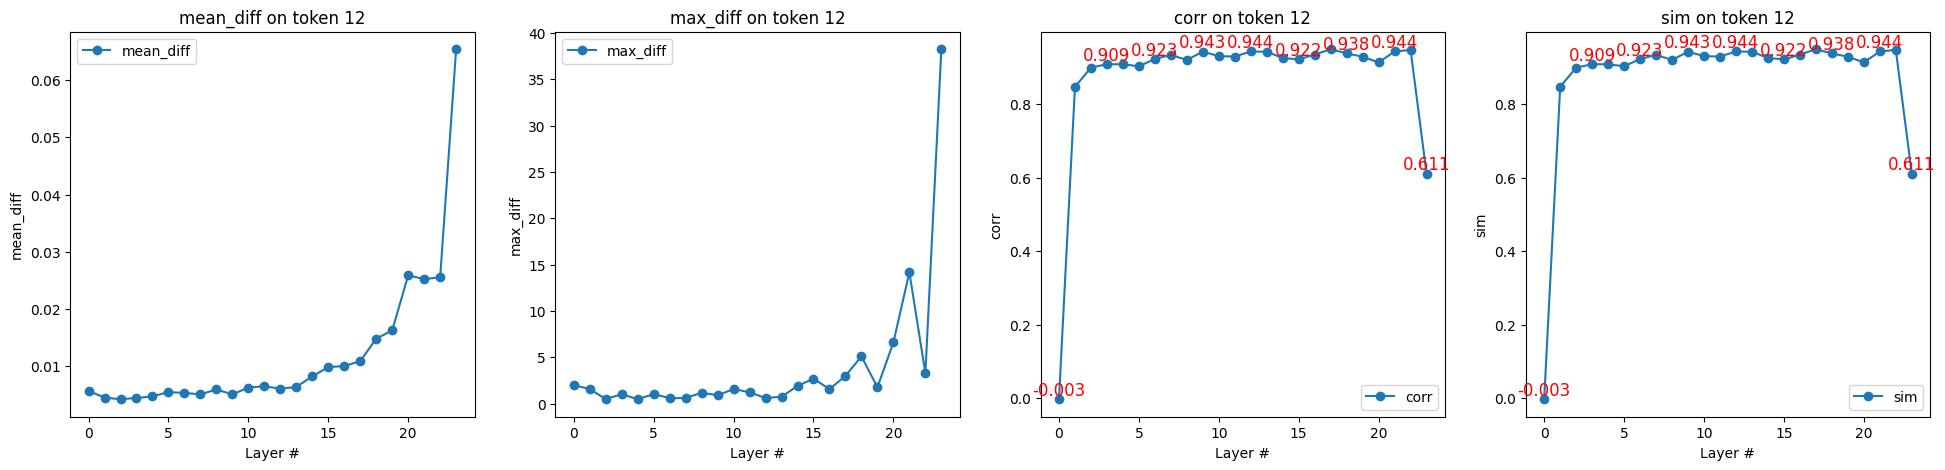

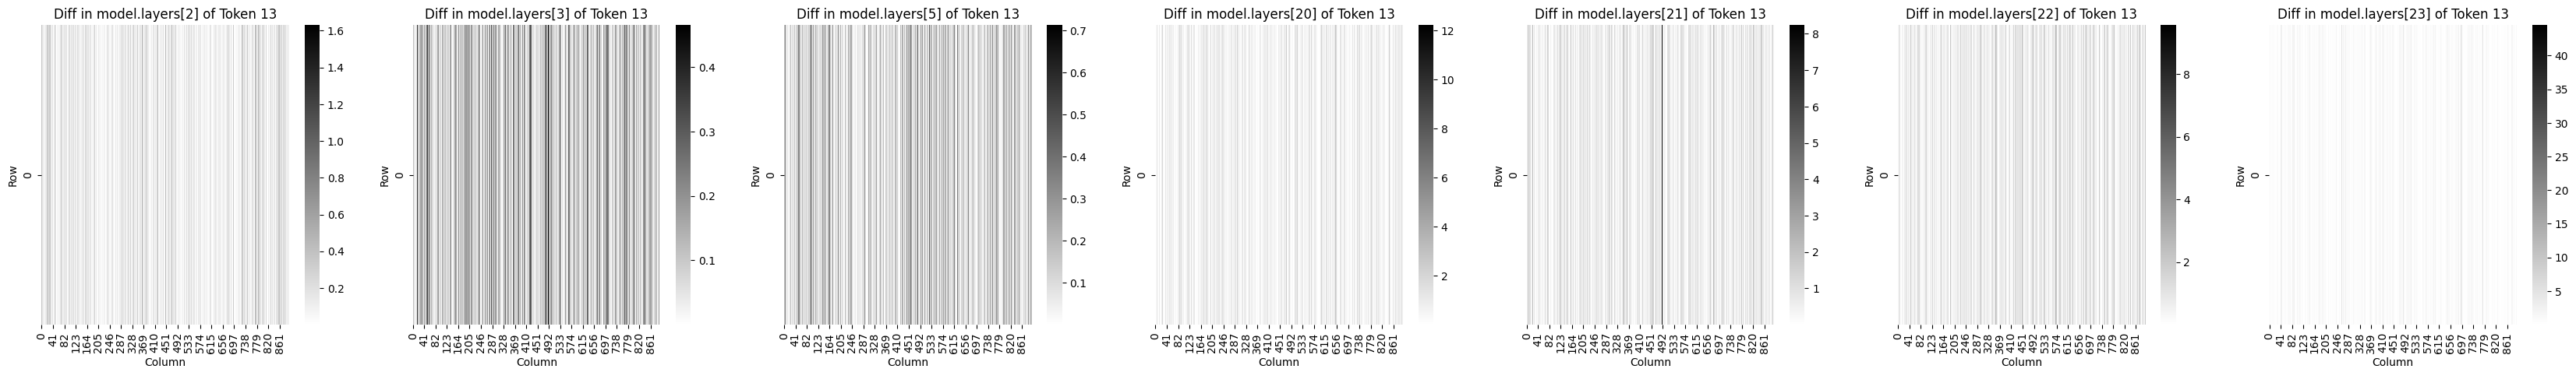

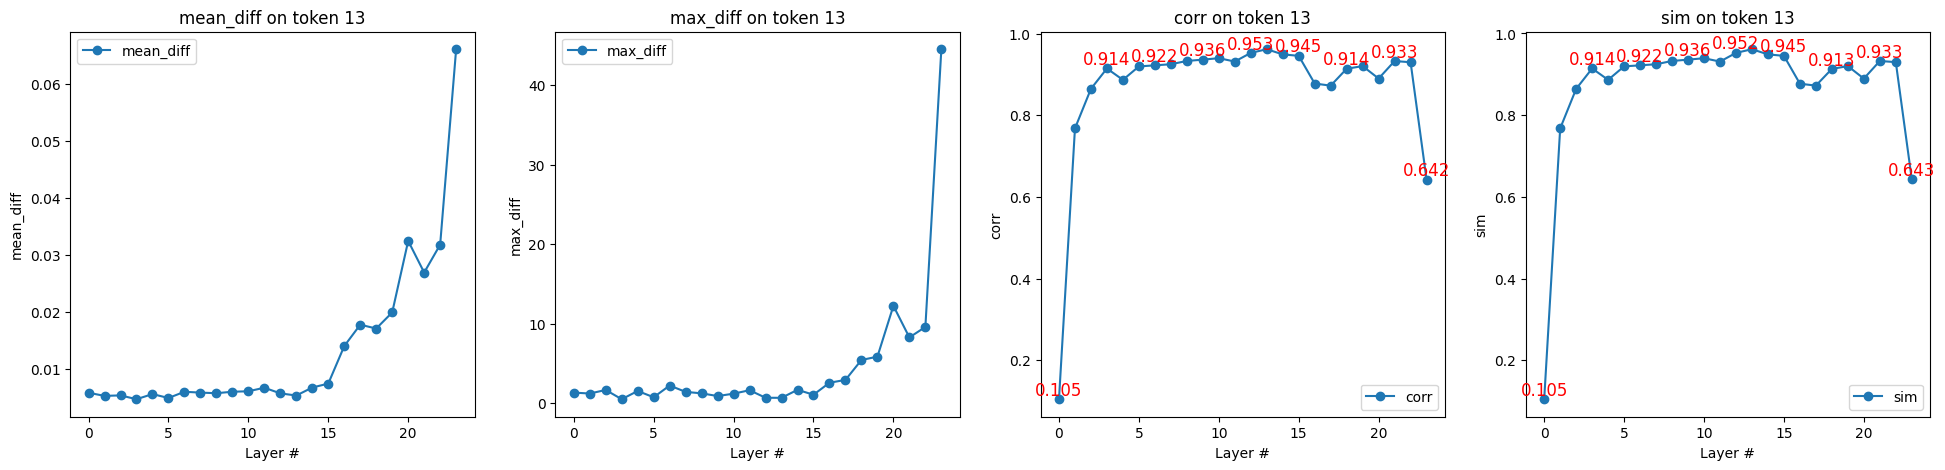

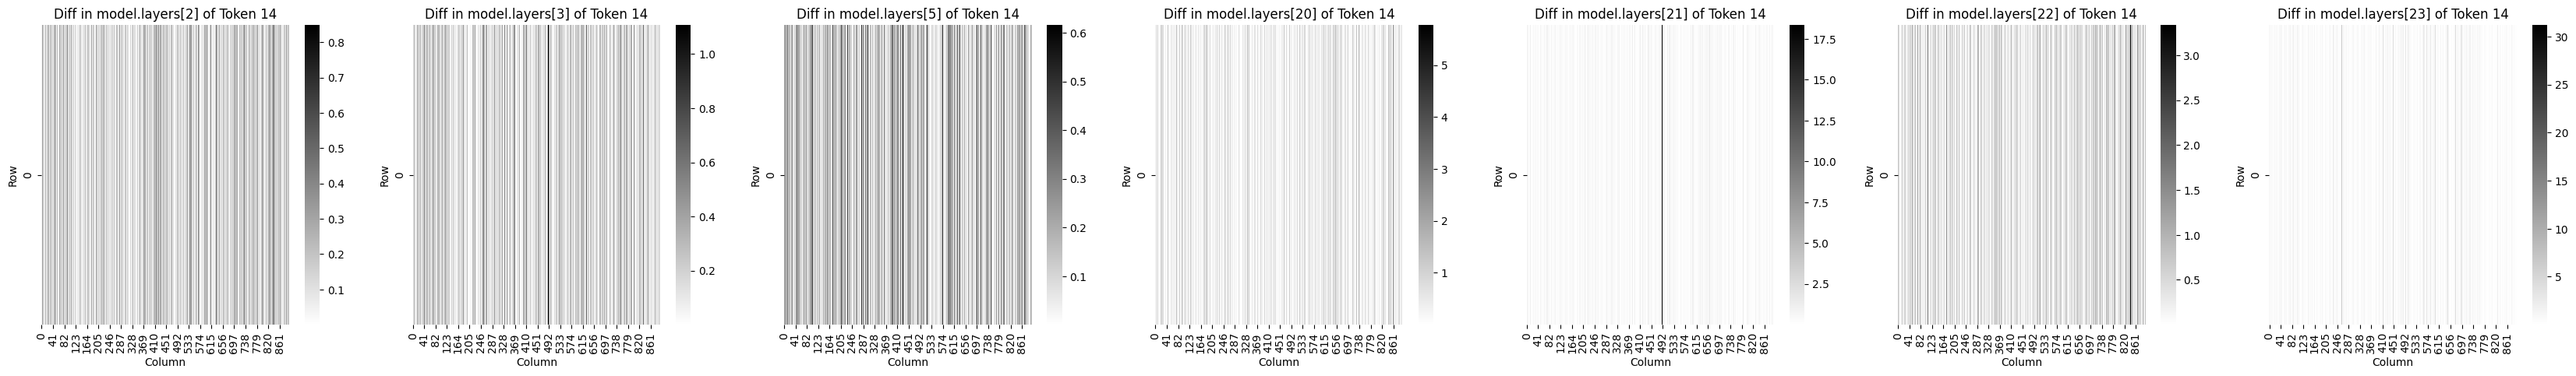

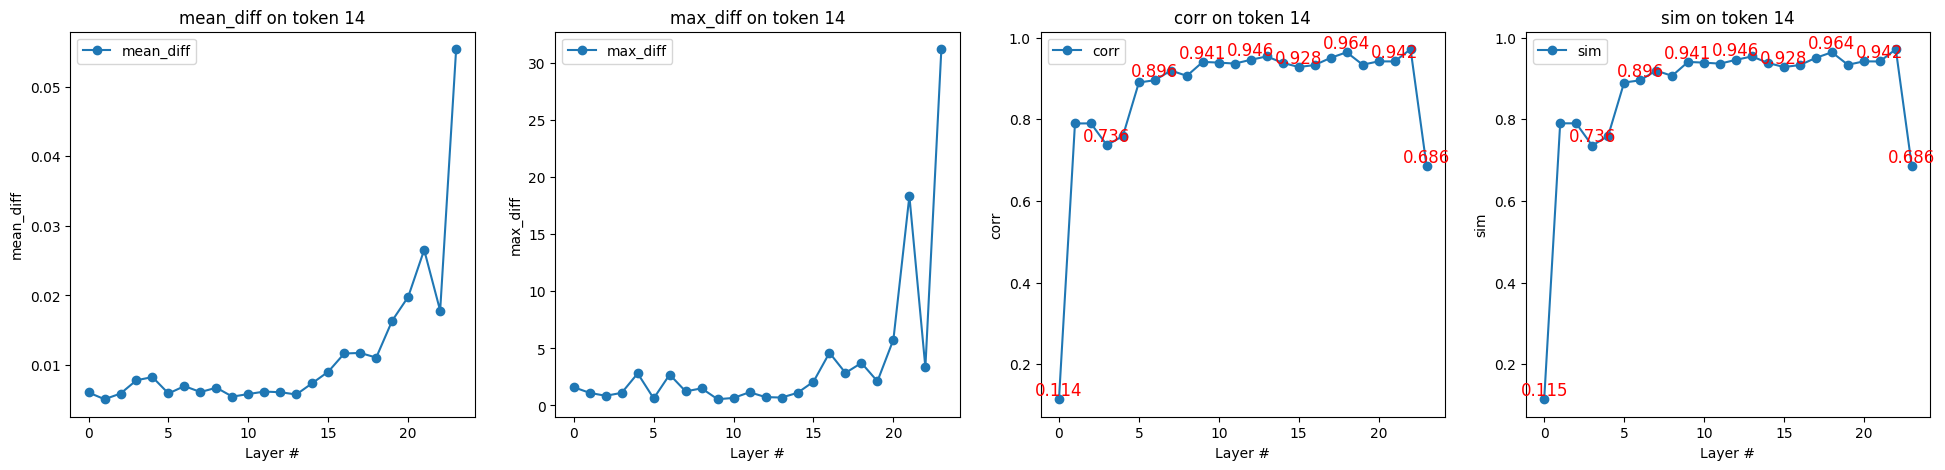

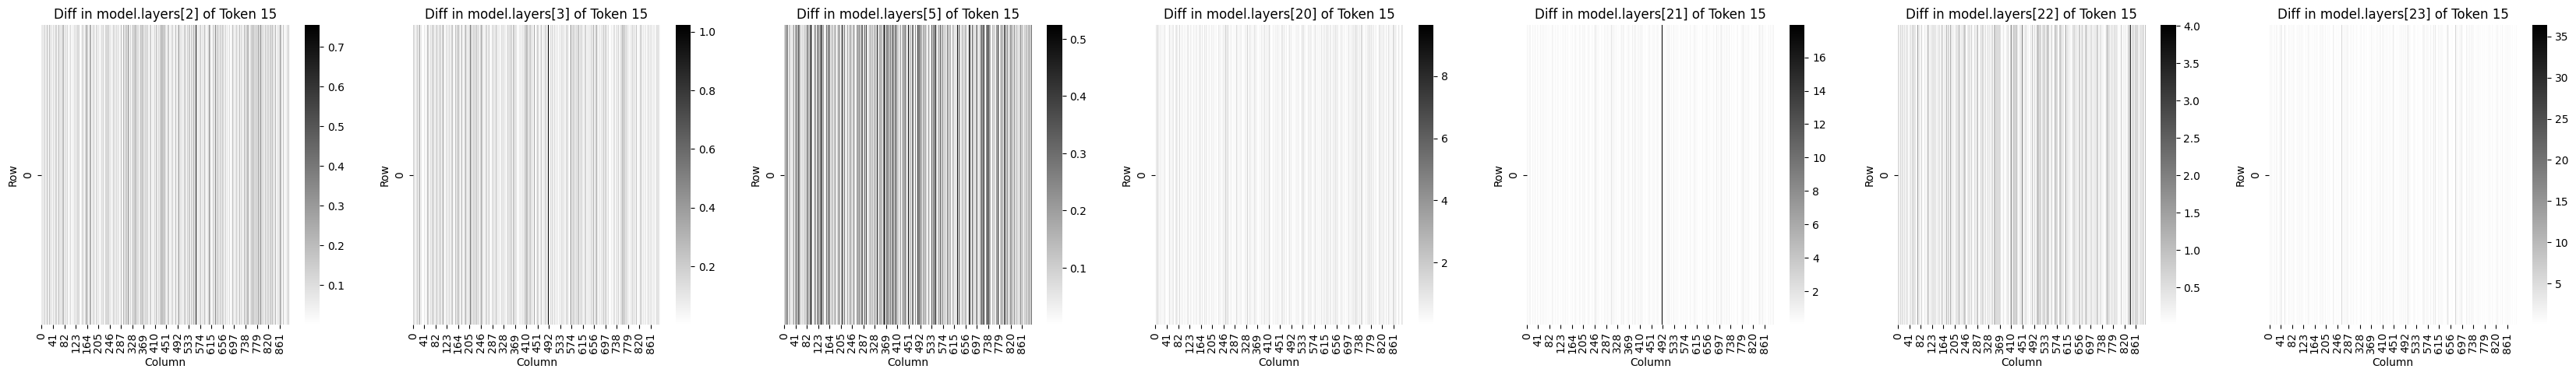

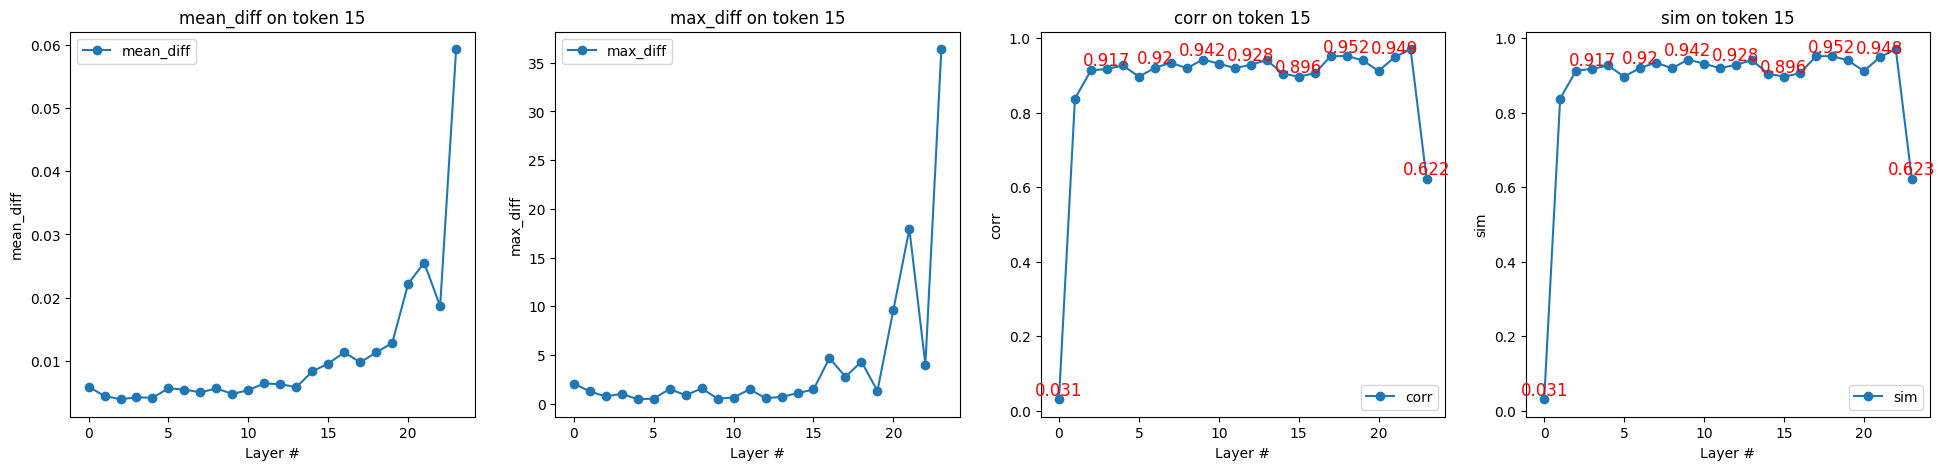

In [6]:
vertical_comparison_of_forward_hook(
    hook_data = None,
    hook_data_path = hook_data_paths[0], # prime-true
    hook_module_names = [f"model.layers[{i}]" for i in range(24)],
    comparison_index = ["mean_diff", "max_diff", "corr", "sim"],
    max_length = 16,
    figure_size = 5,
    watched_module_names = [f"model.layers[{i}]" for i in [2, 3, 5, 20, 21, 22, 23]],
)

## longlong

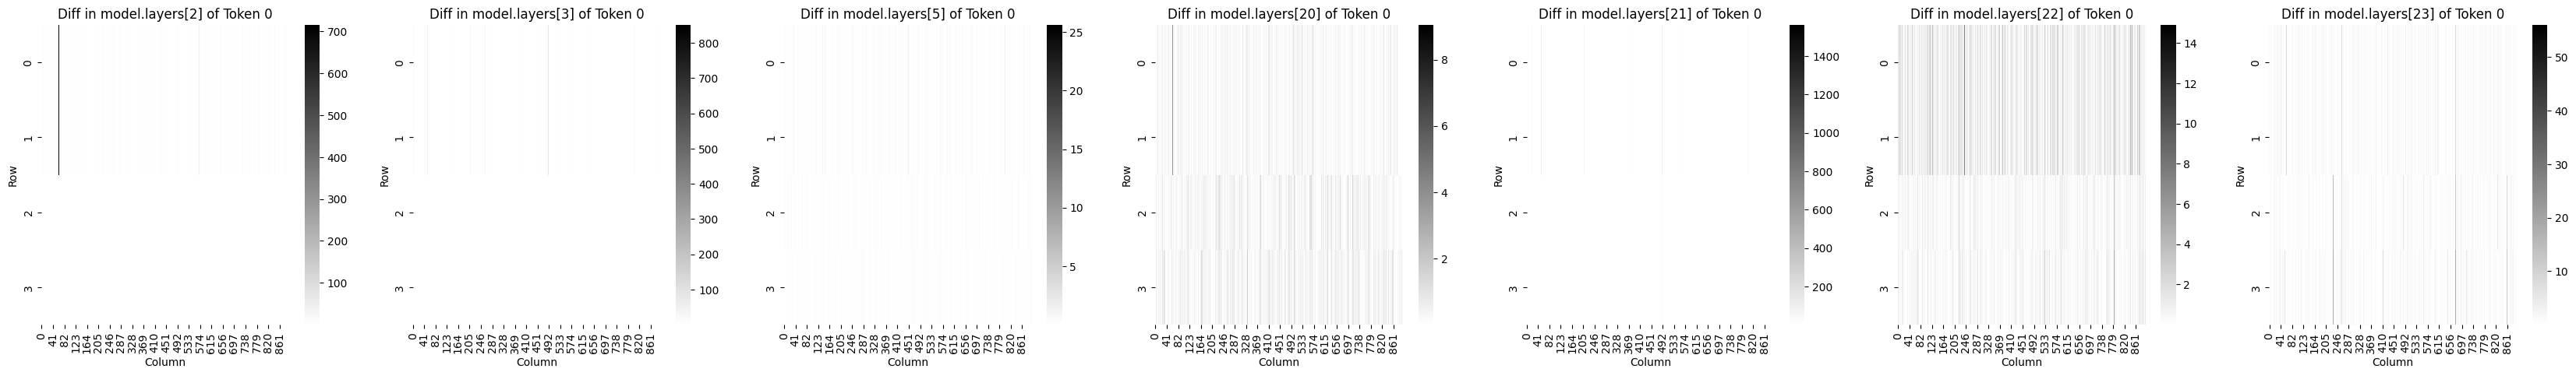

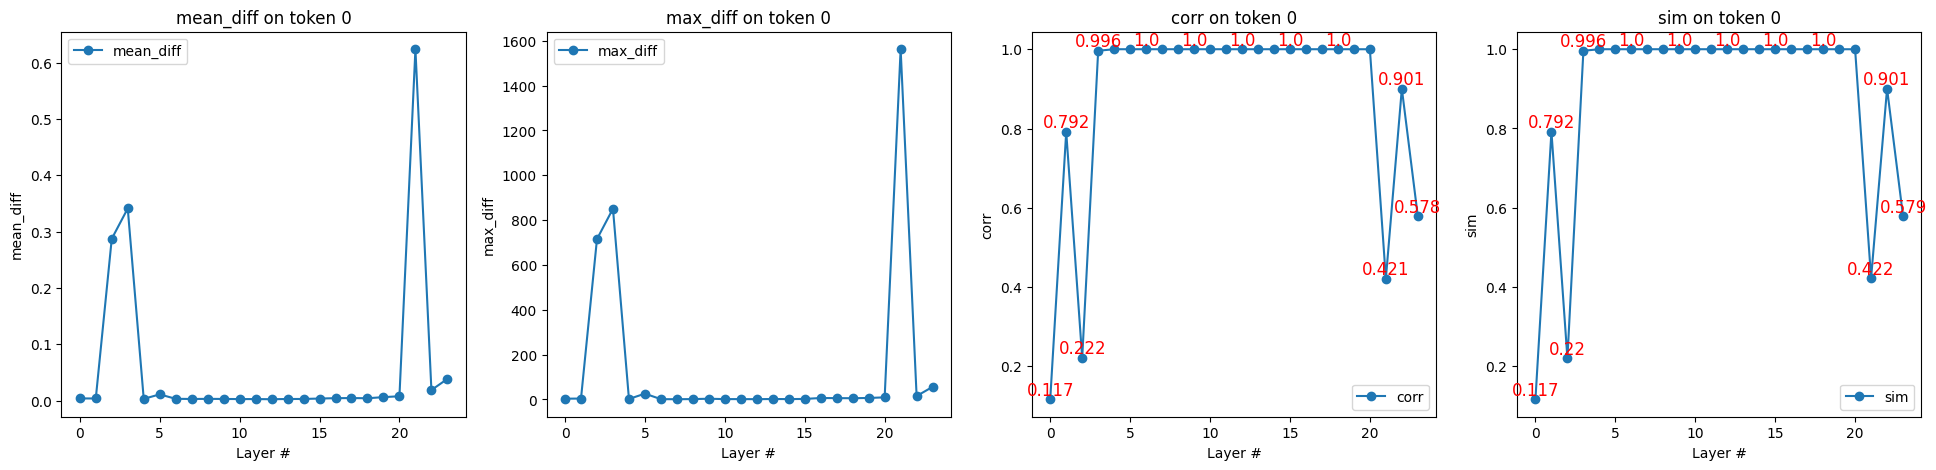

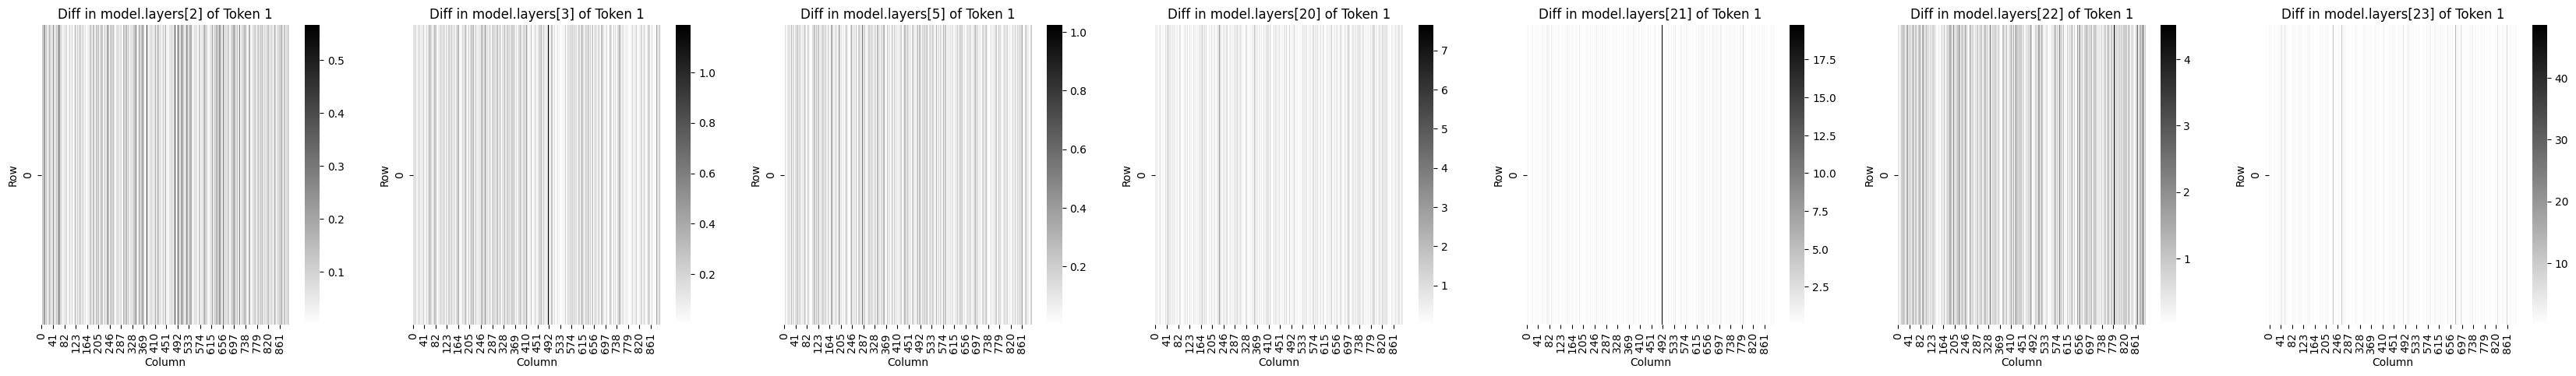

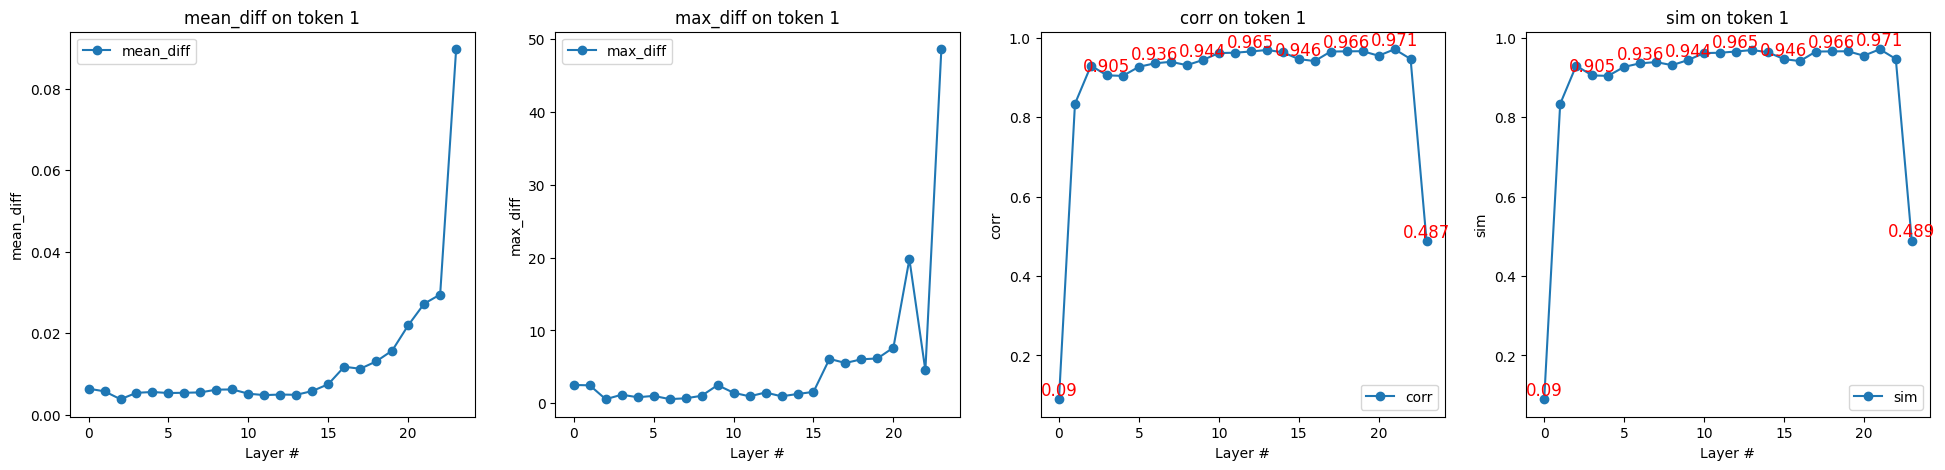

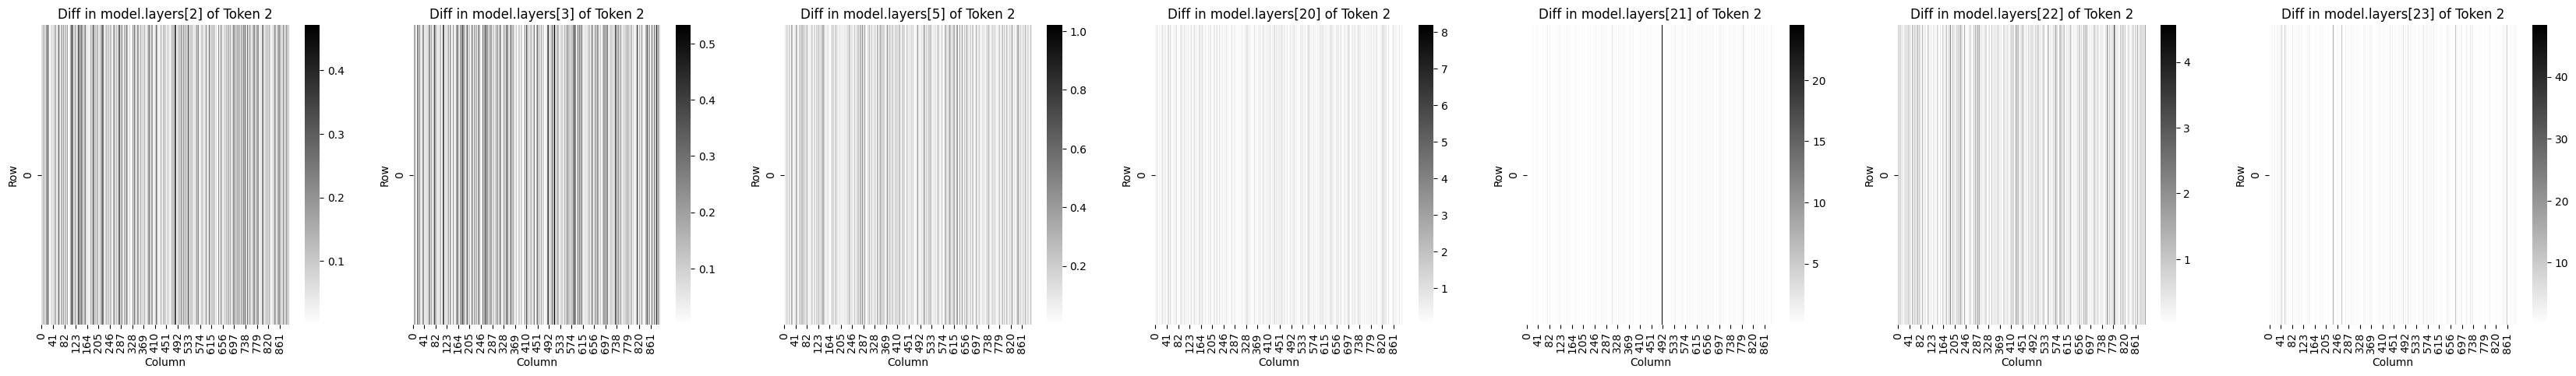

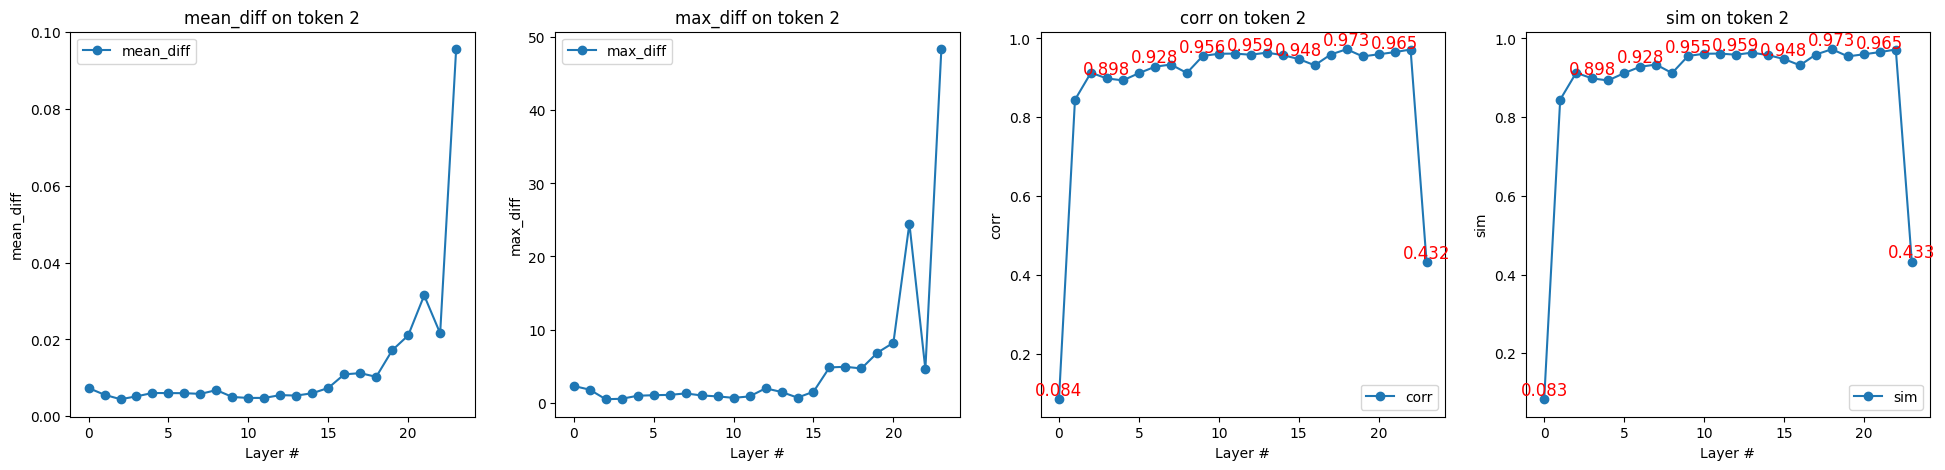

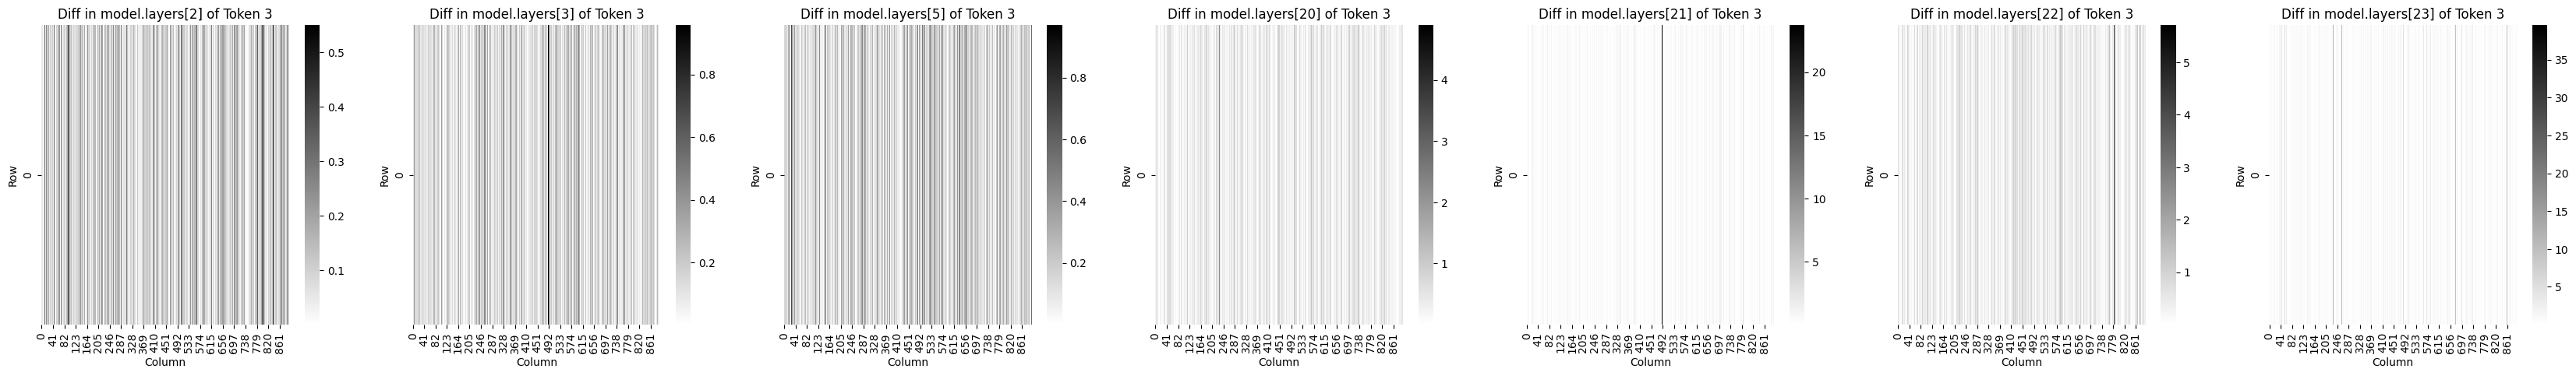

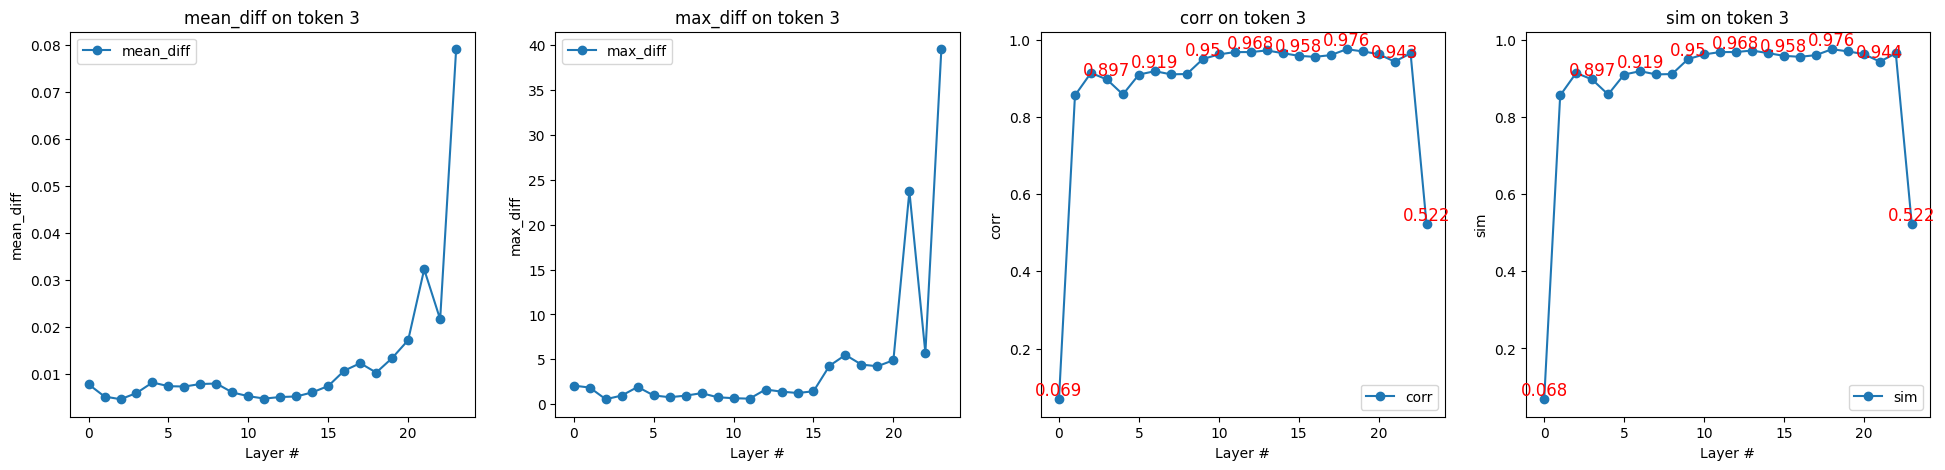

In [18]:
vertical_comparison_of_forward_hook(
    hook_data = None,
    hook_data_path = hook_data_paths[1], # prime-true
    hook_module_names = [f"model.layers[{i}]" for i in range(24)],
    comparison_index = ["mean_diff", "max_diff", "corr", "sim"],
    max_length = 4,
    figure_size = 5,
    watched_module_names = [f"model.layers[{i}]" for i in [2, 3, 5, 20, 21, 22, 23]],
)

## prime

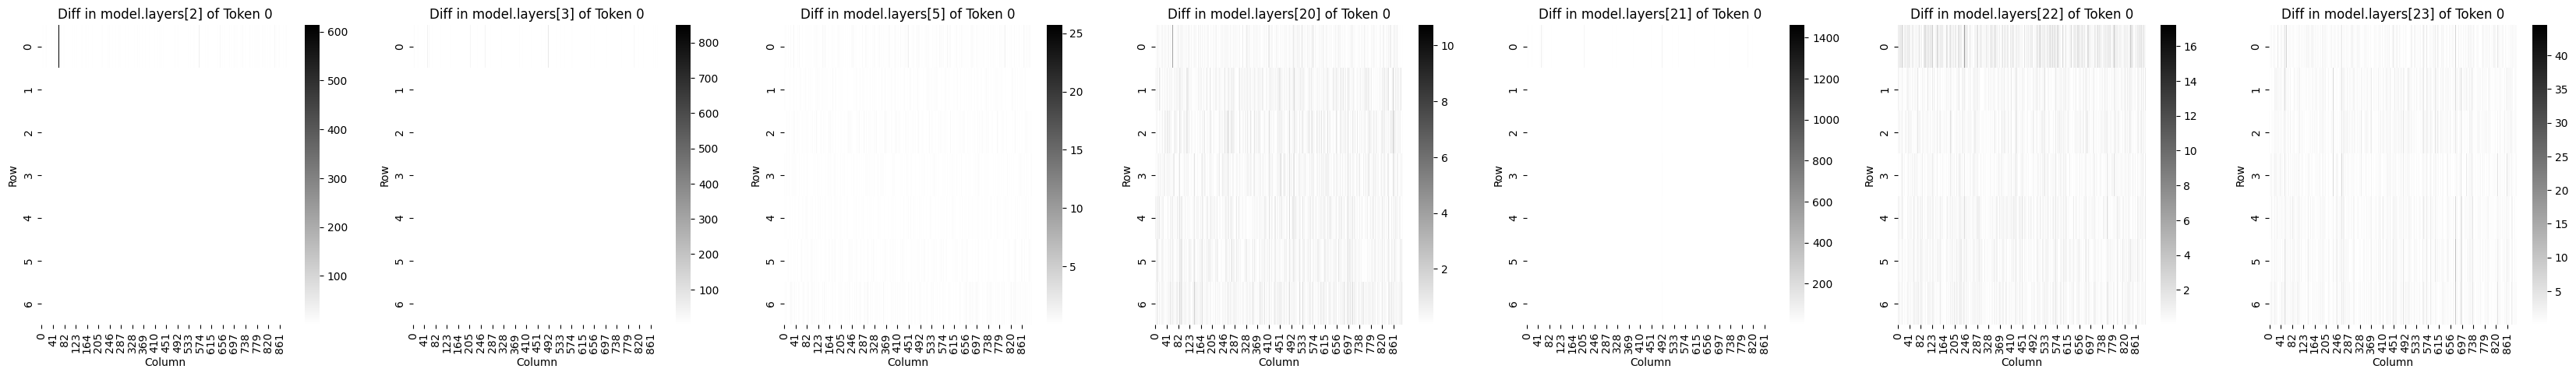

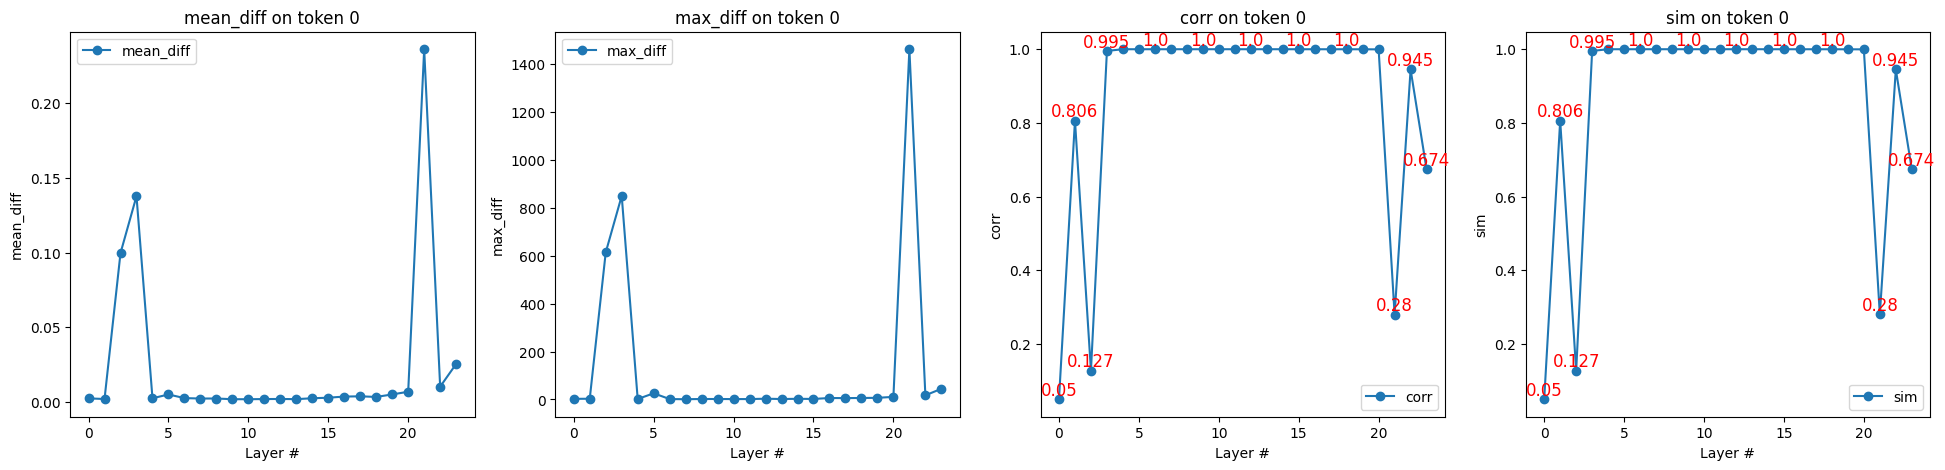

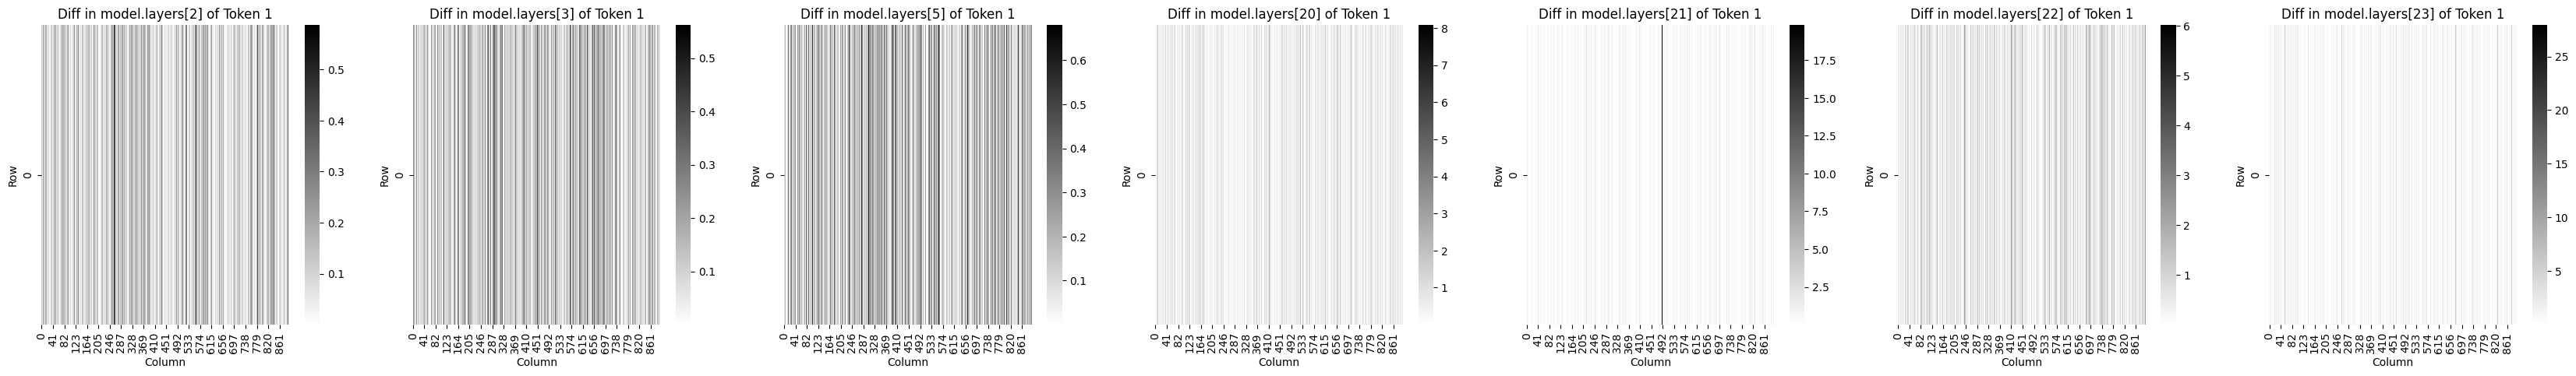

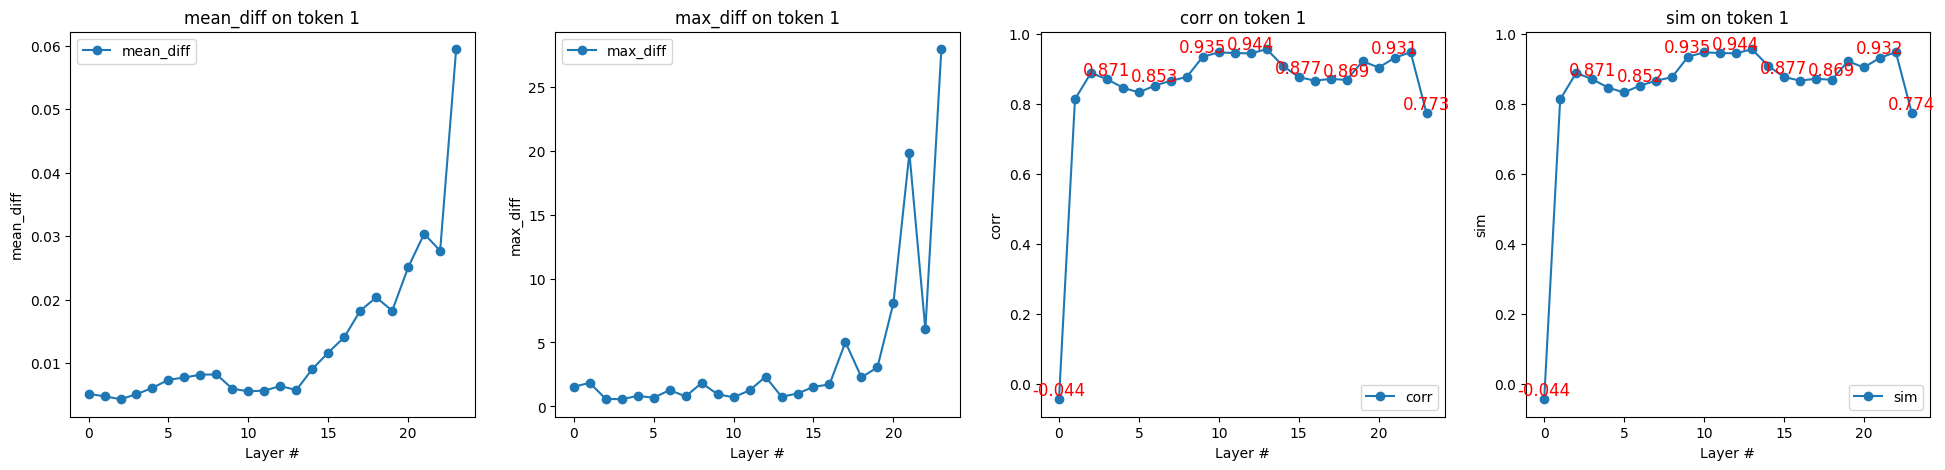

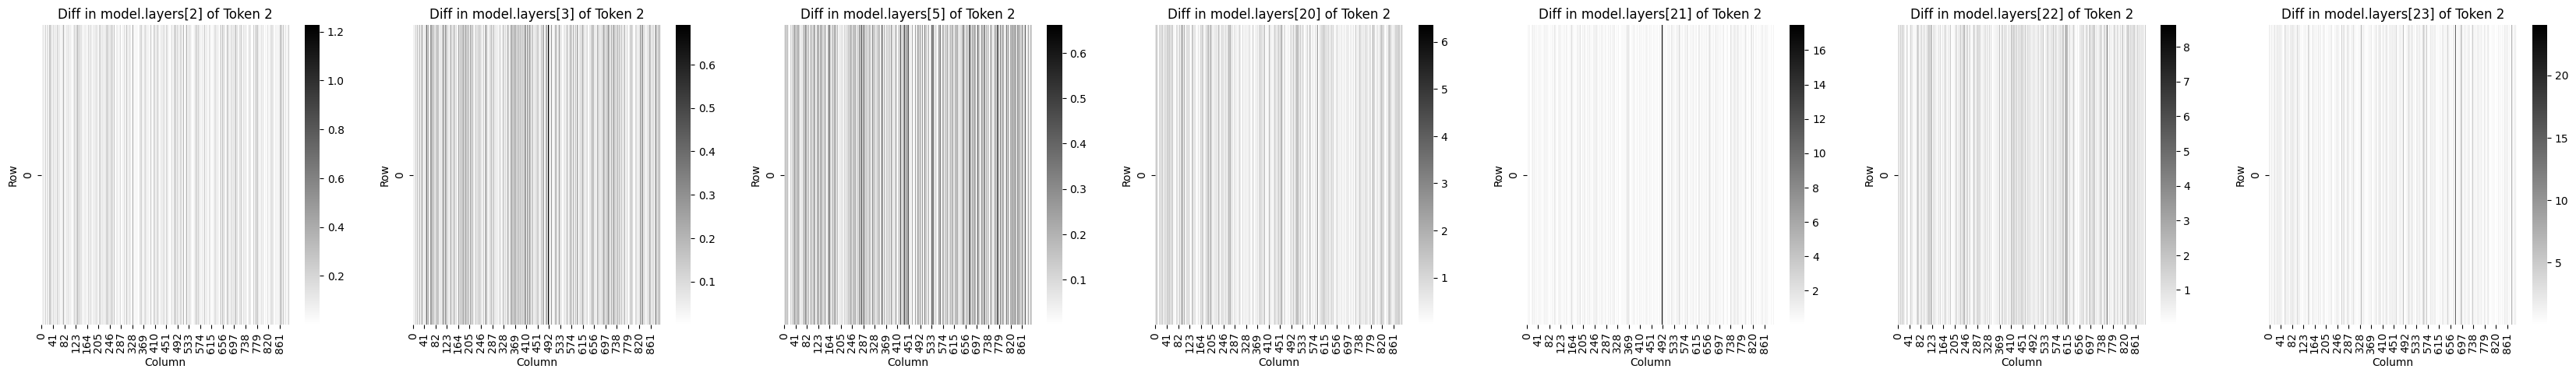

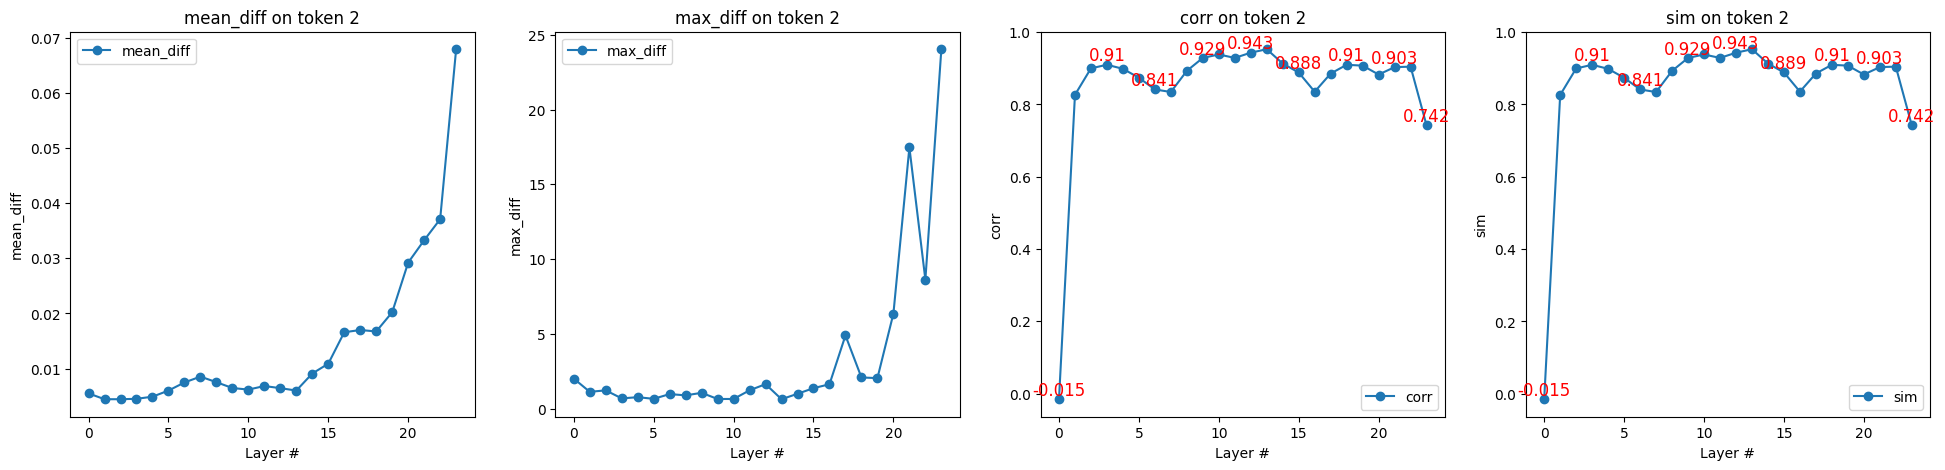

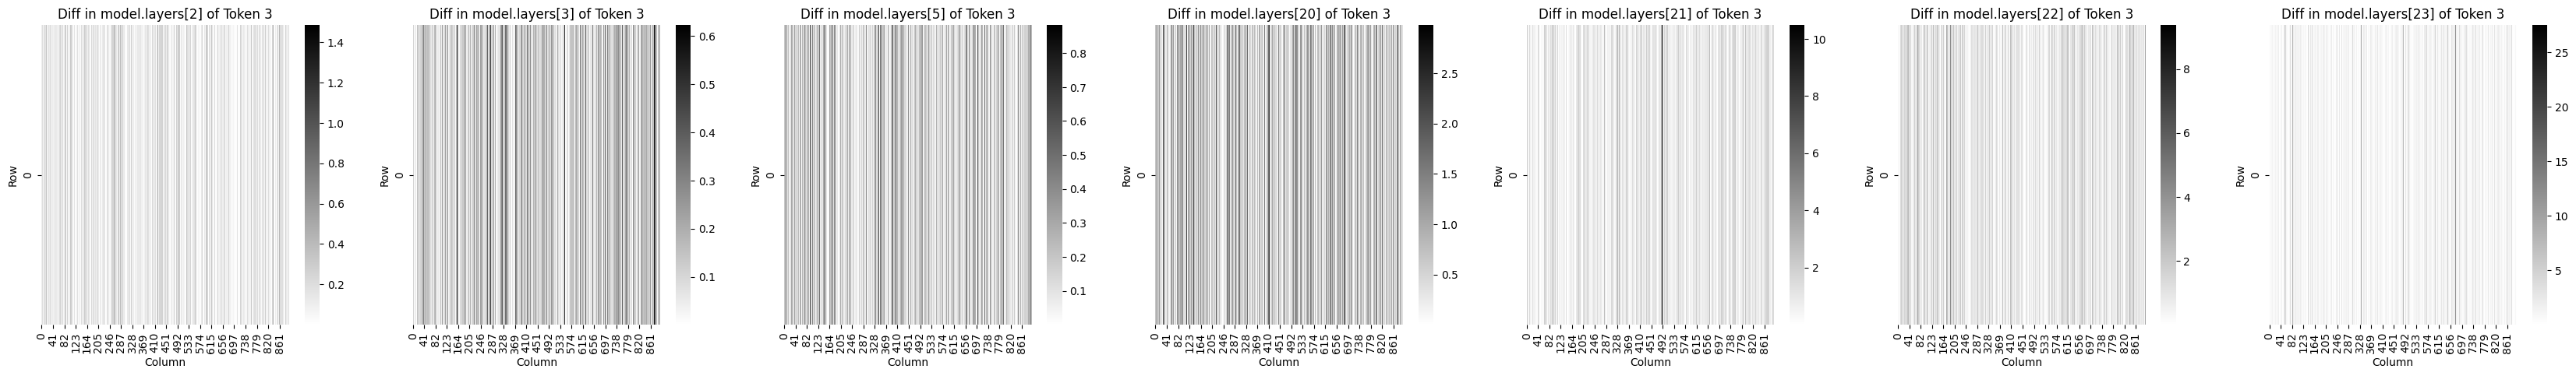

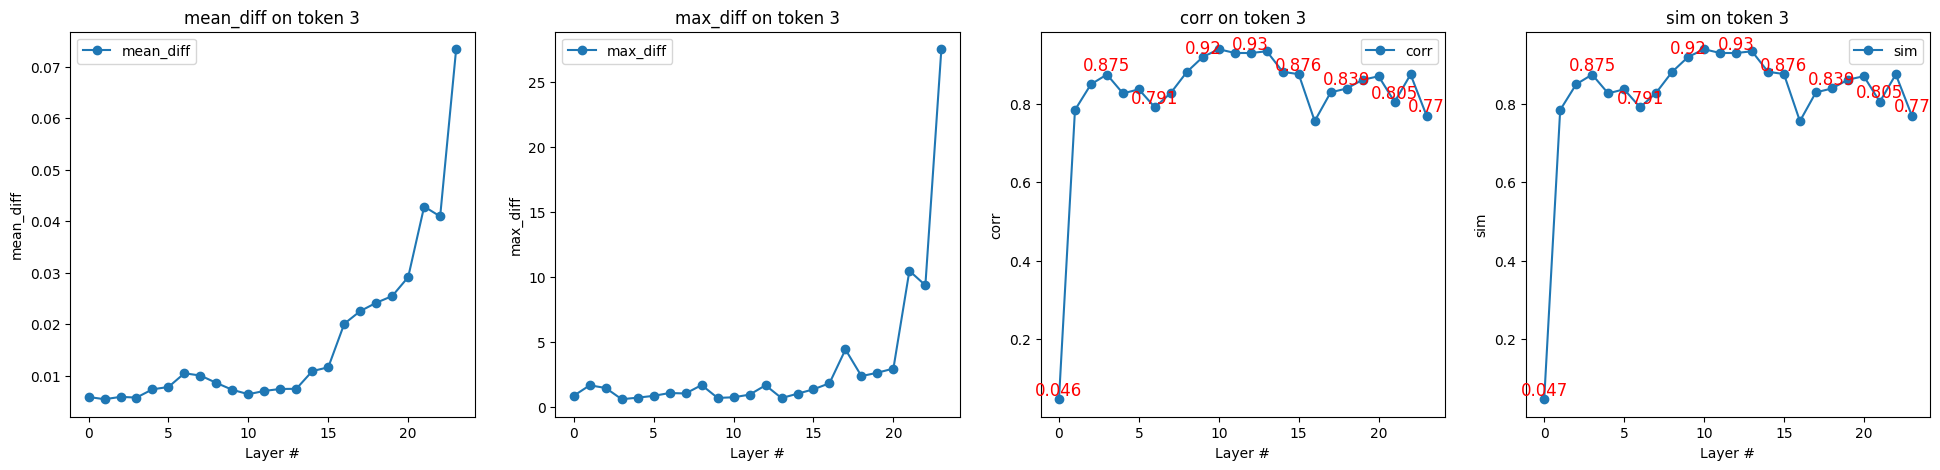

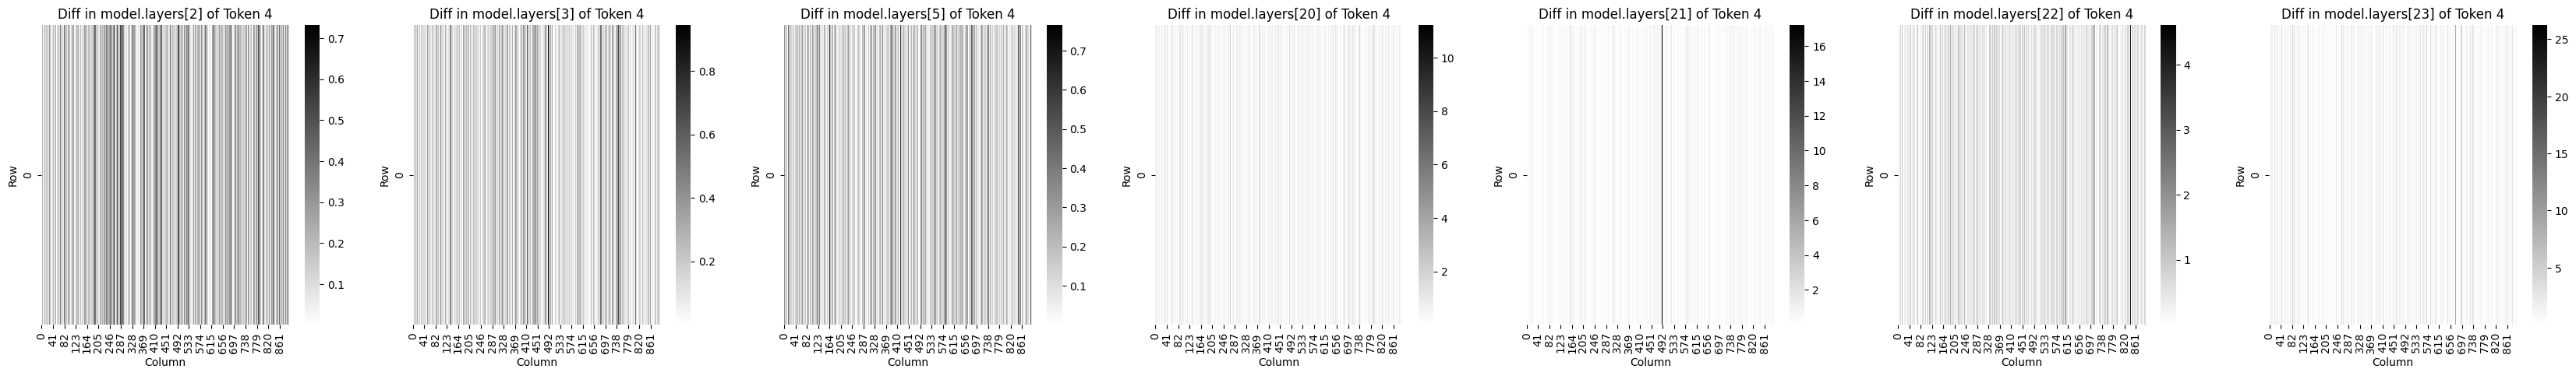

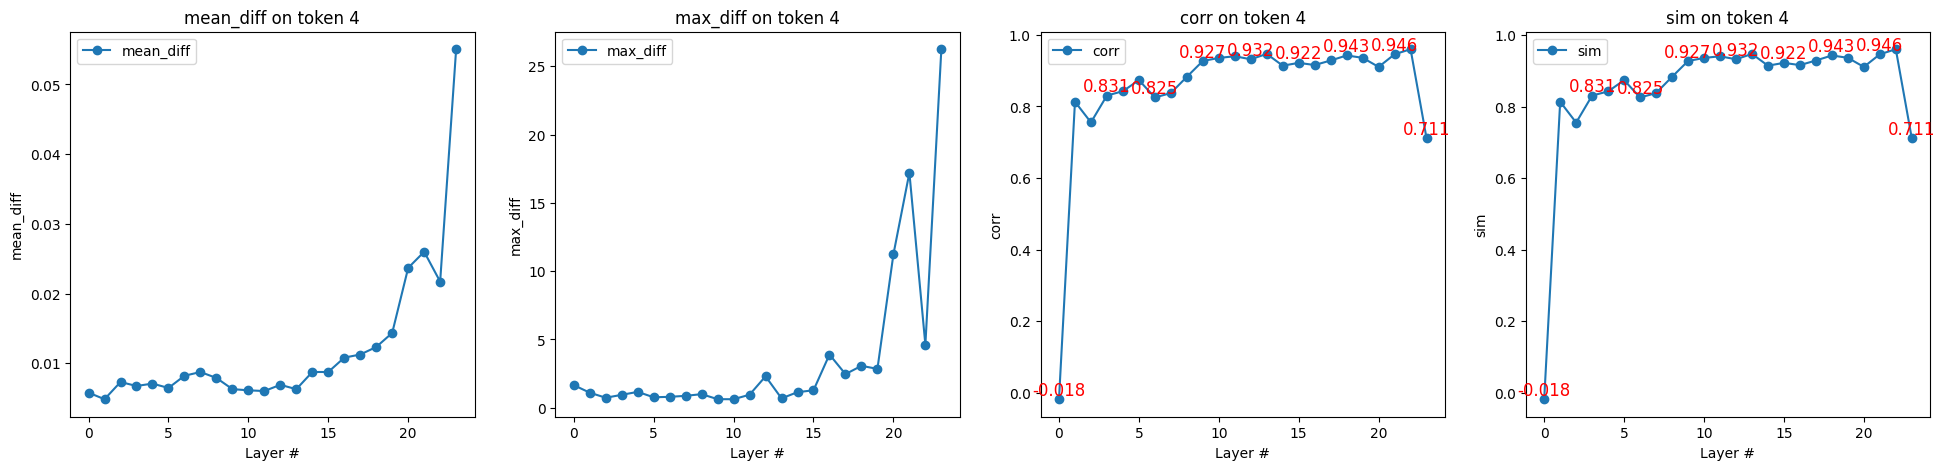

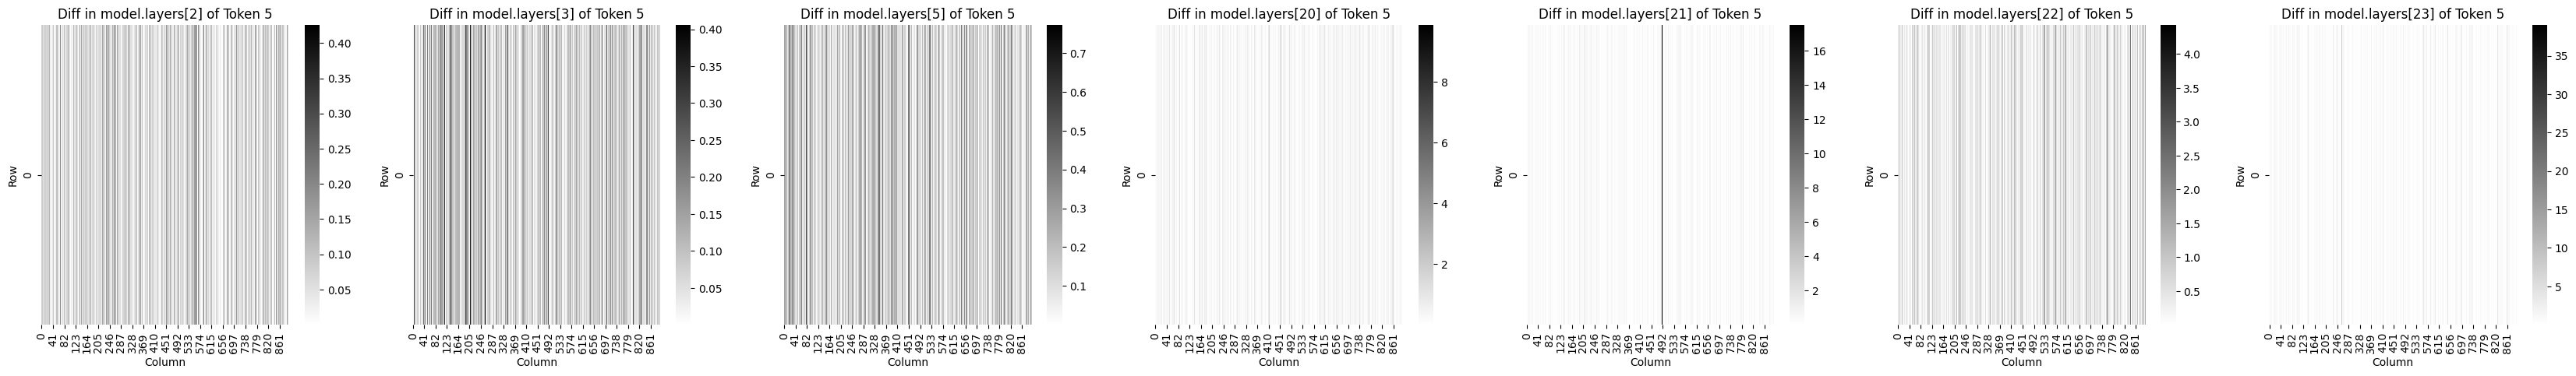

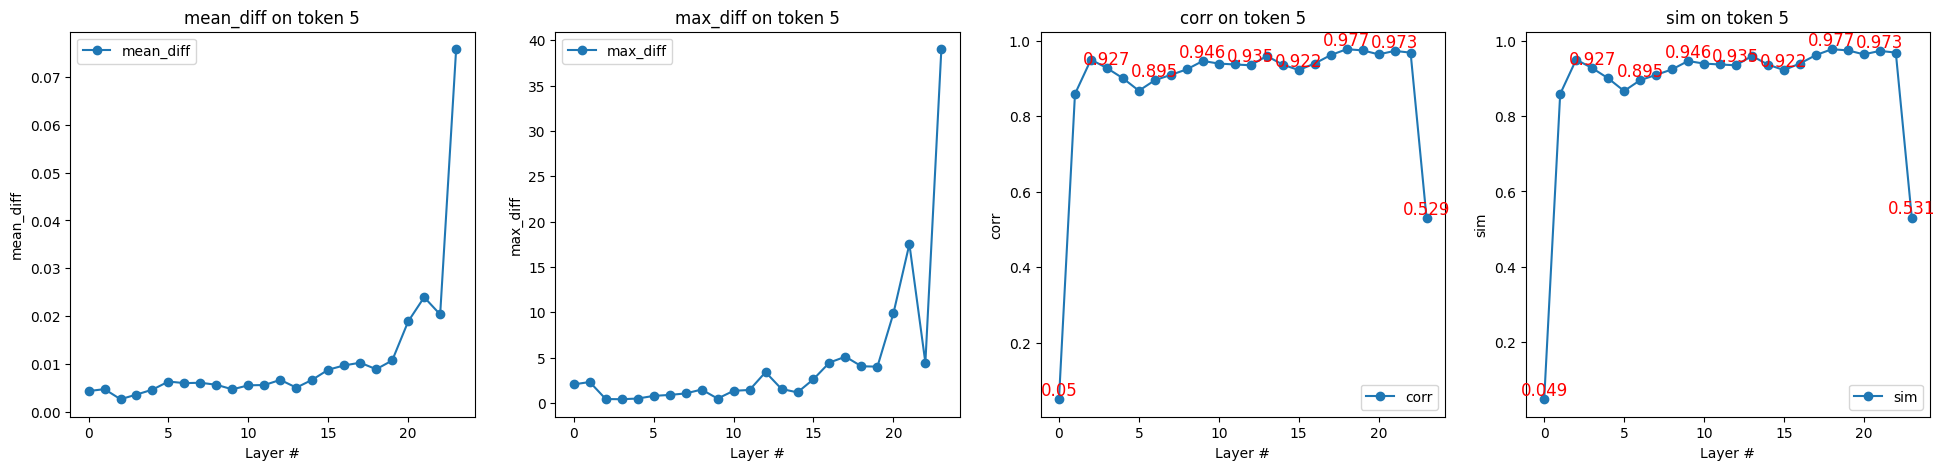

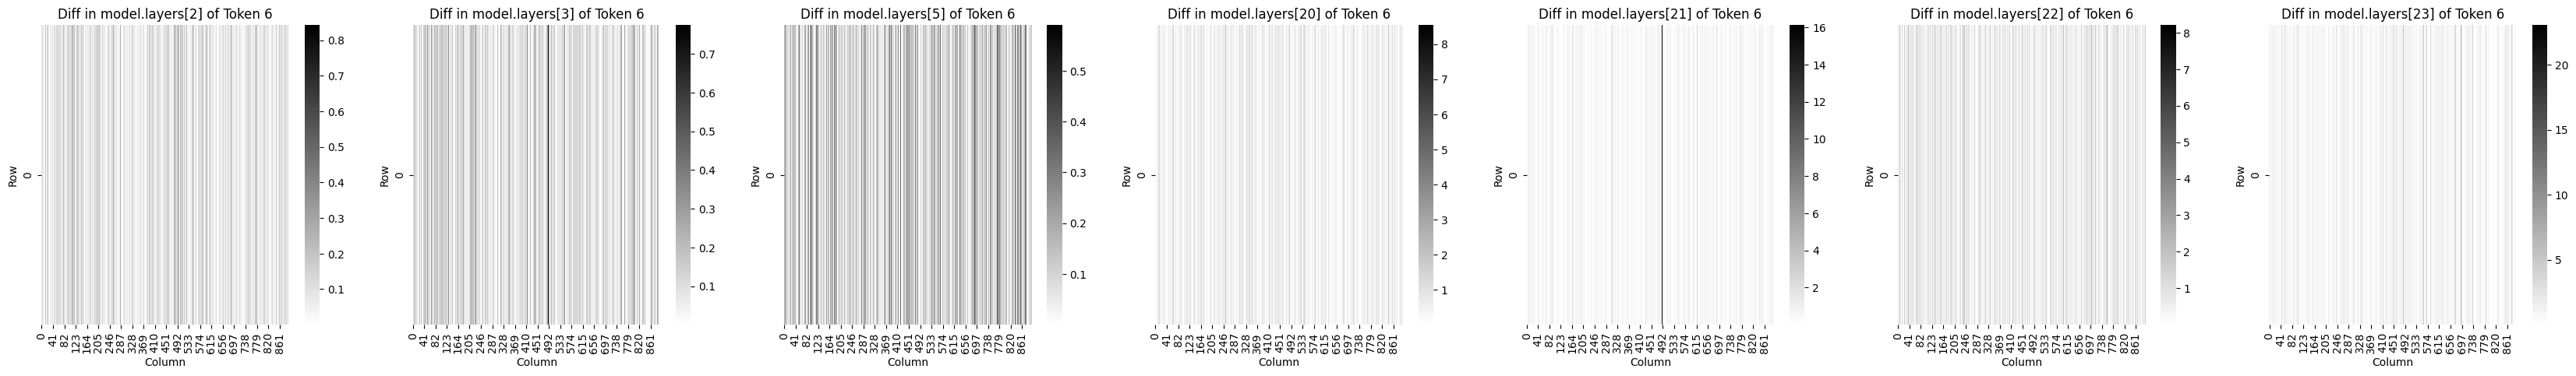

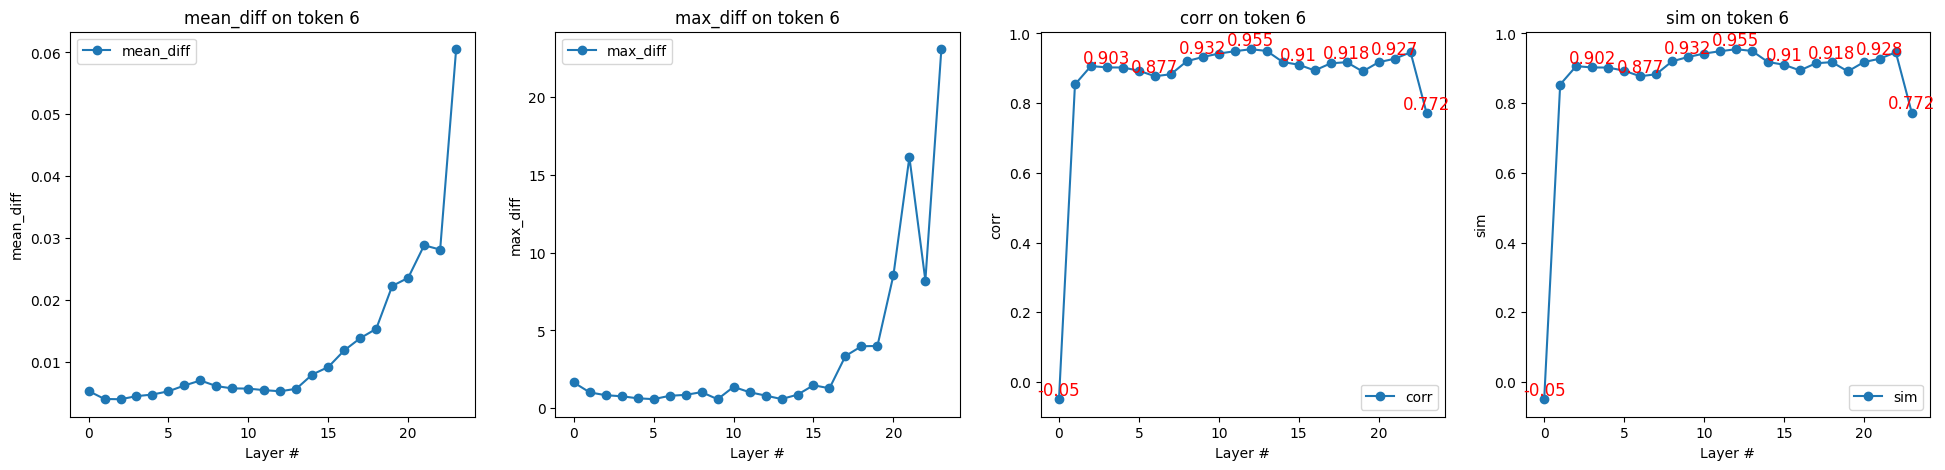

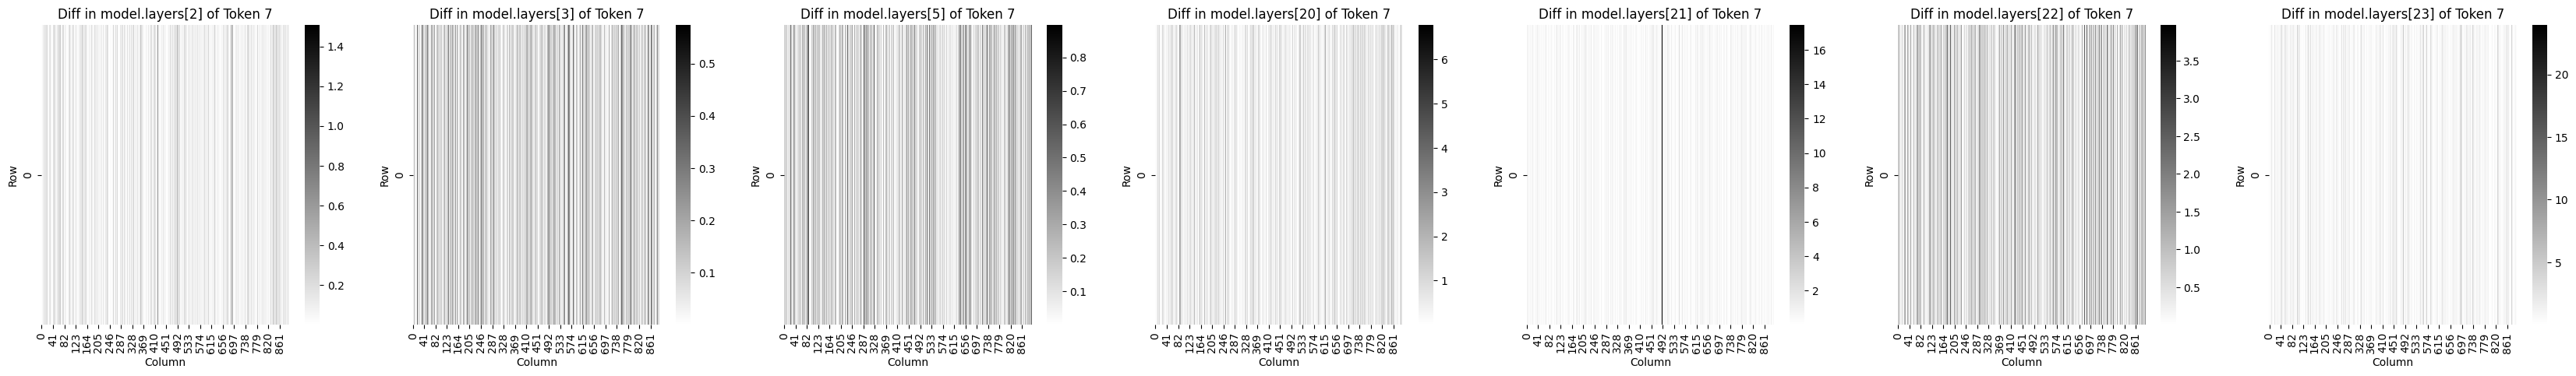

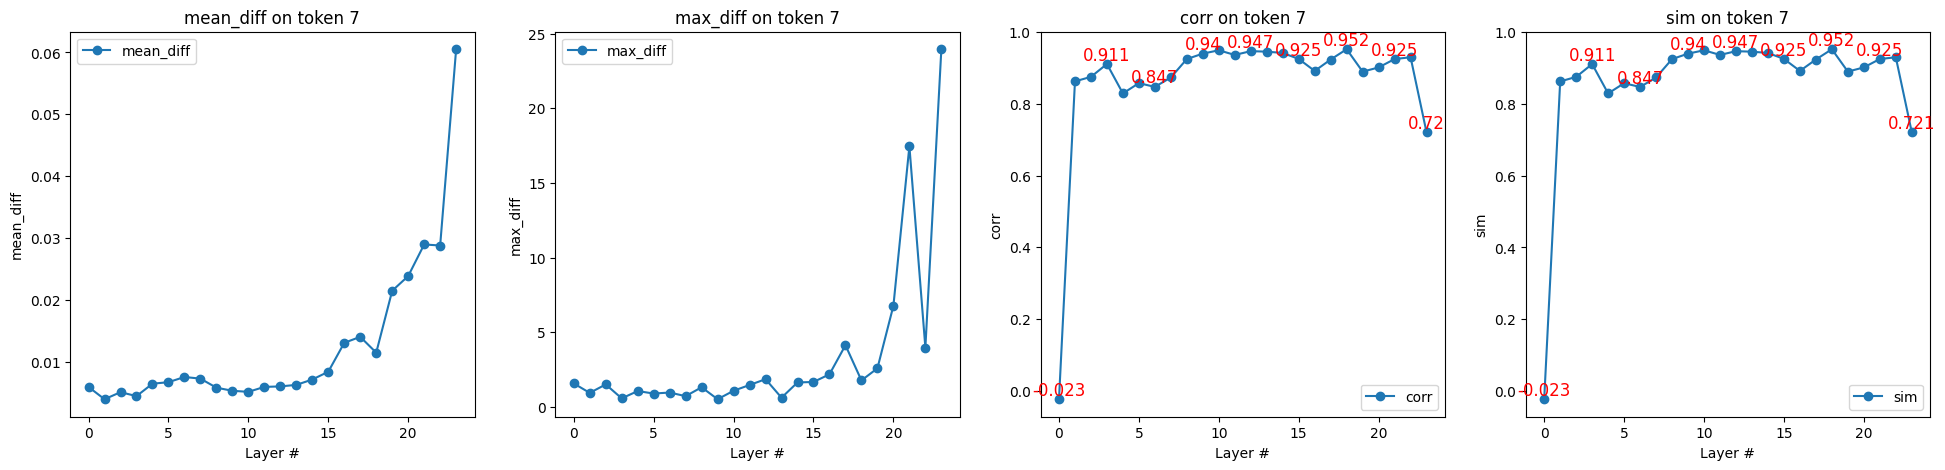

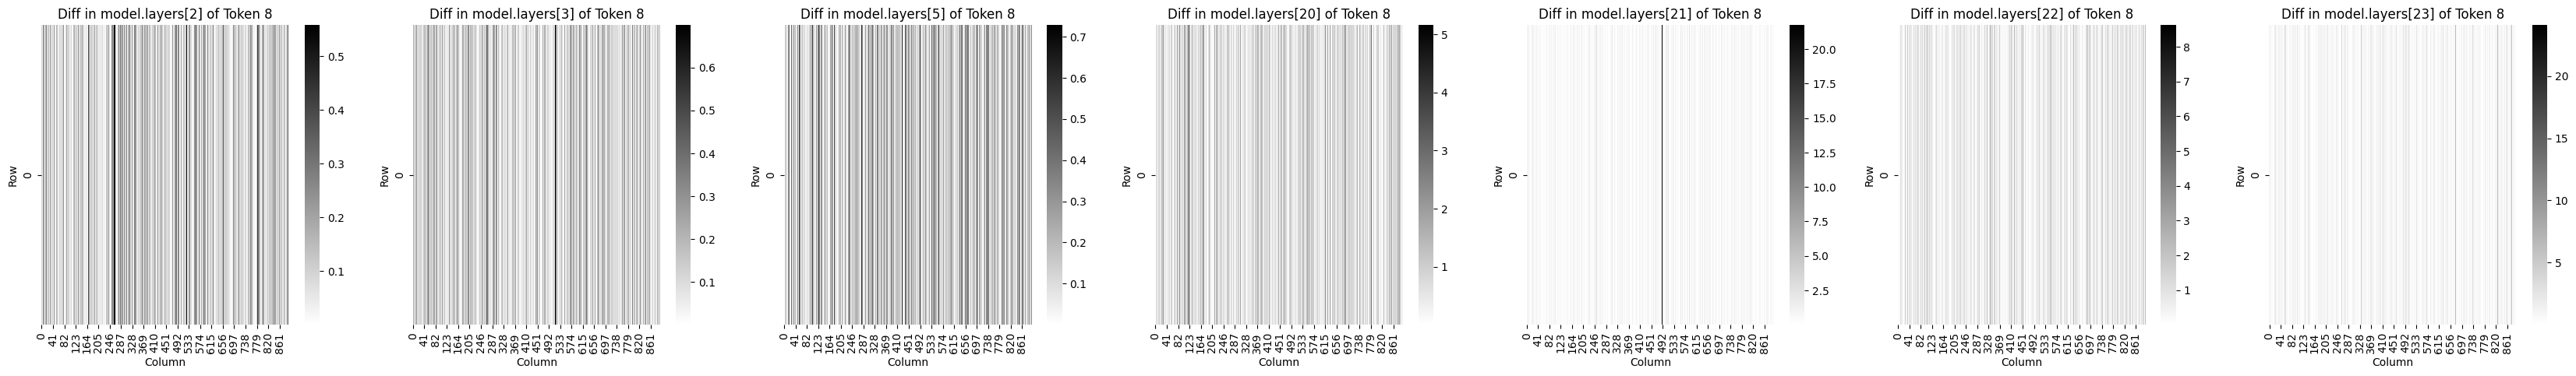

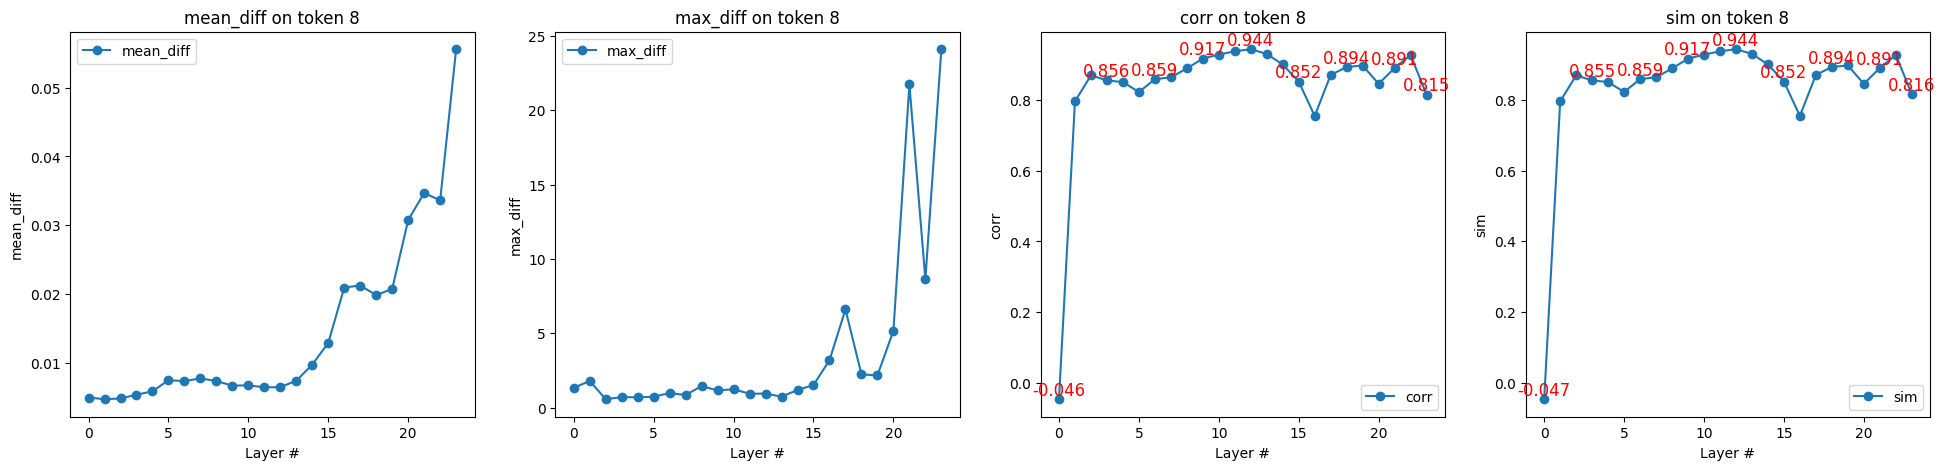

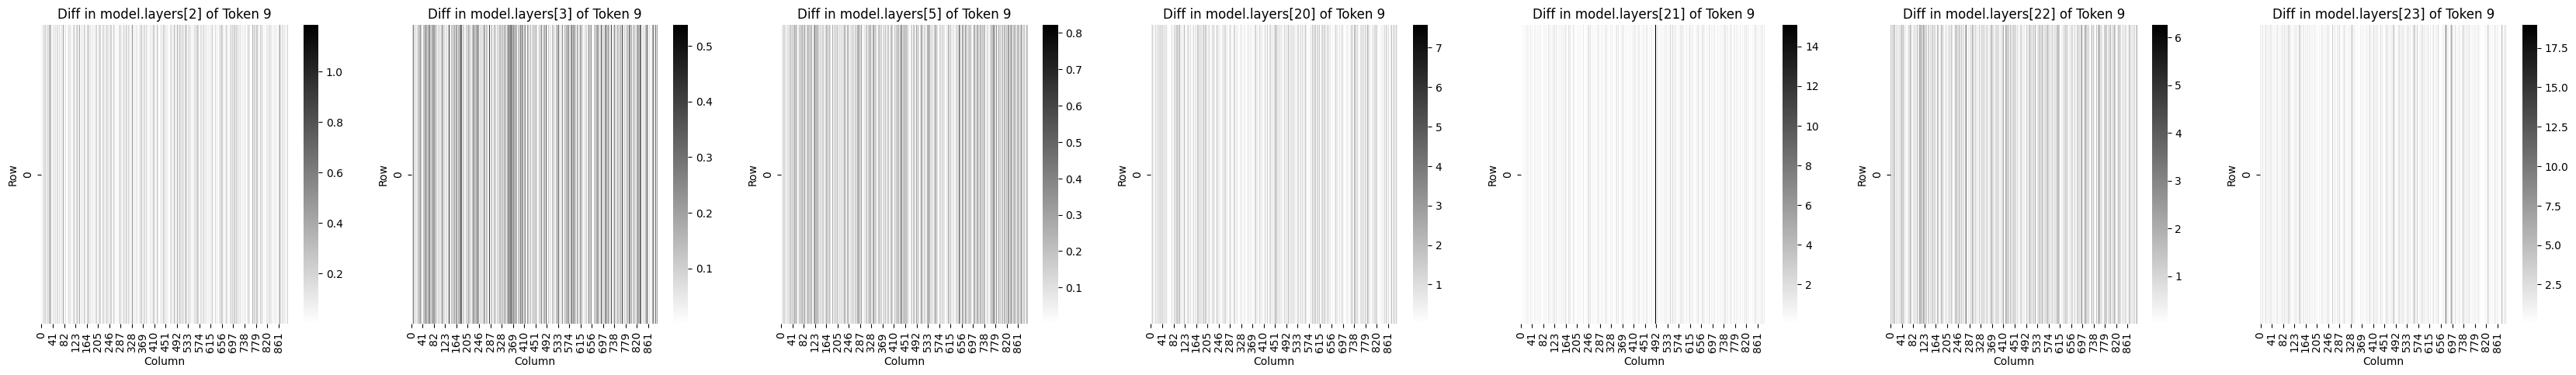

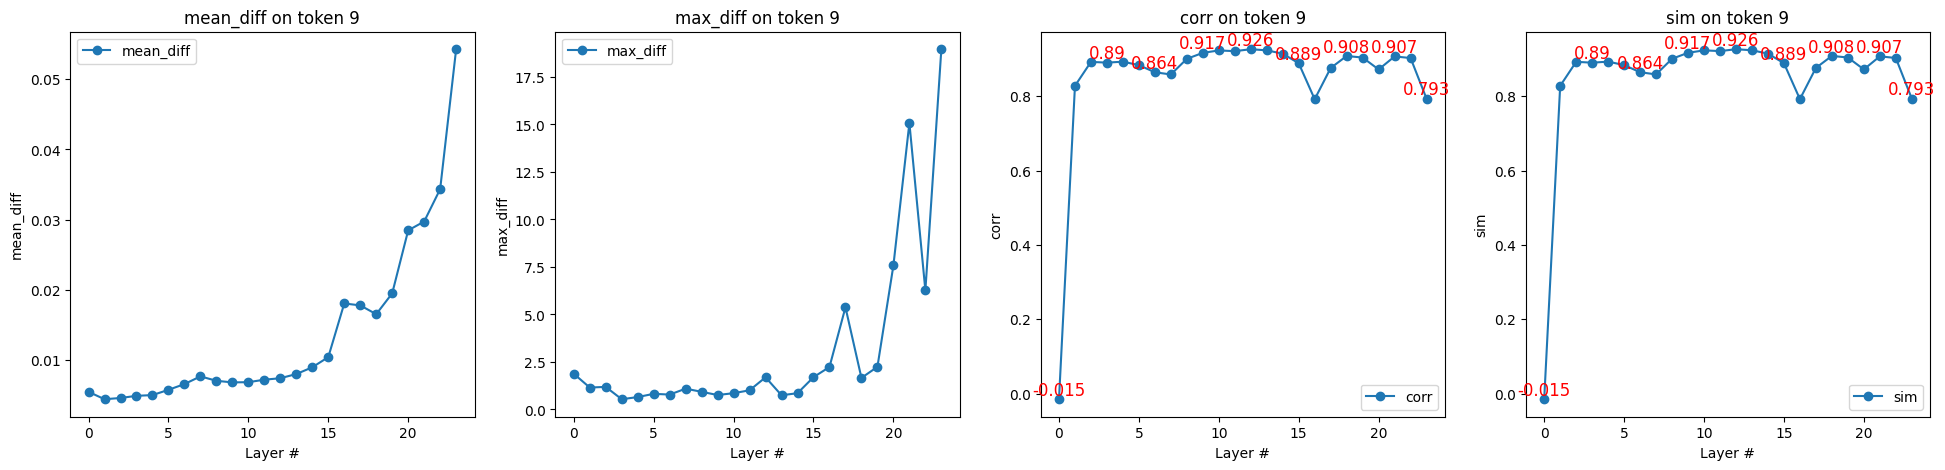

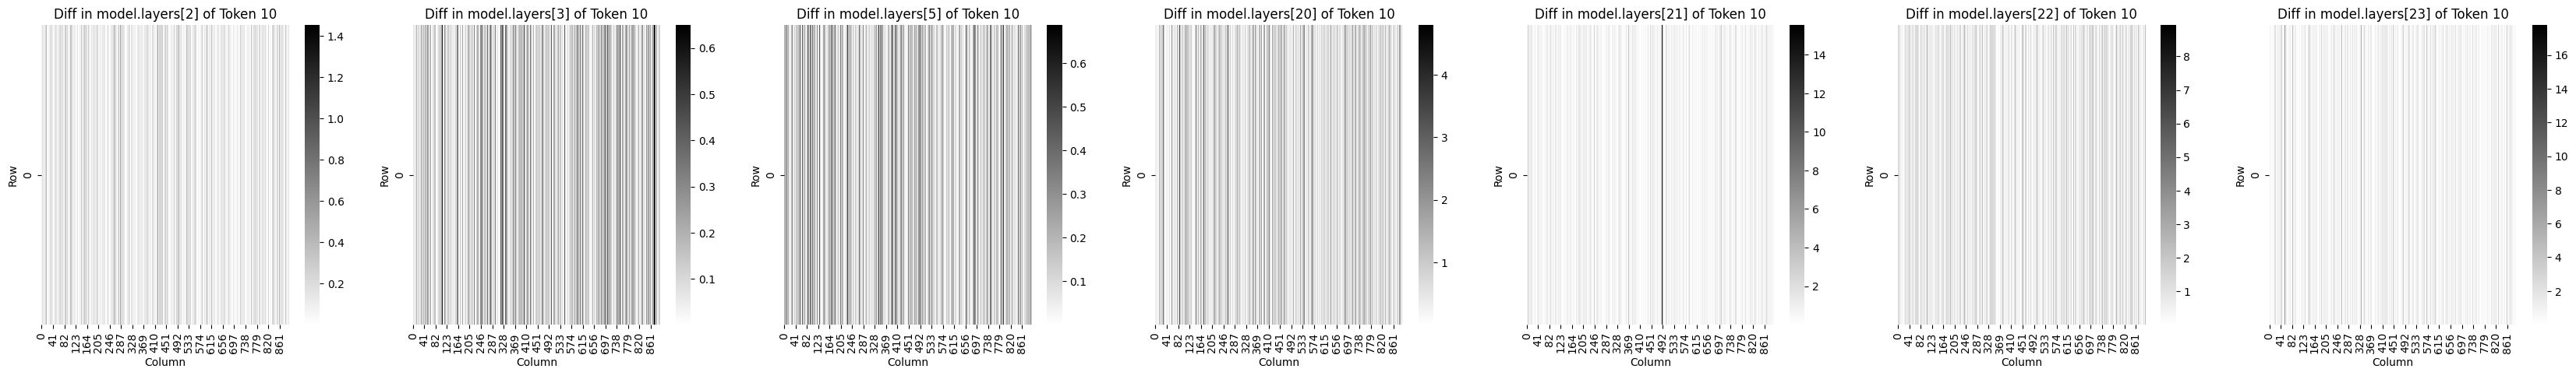

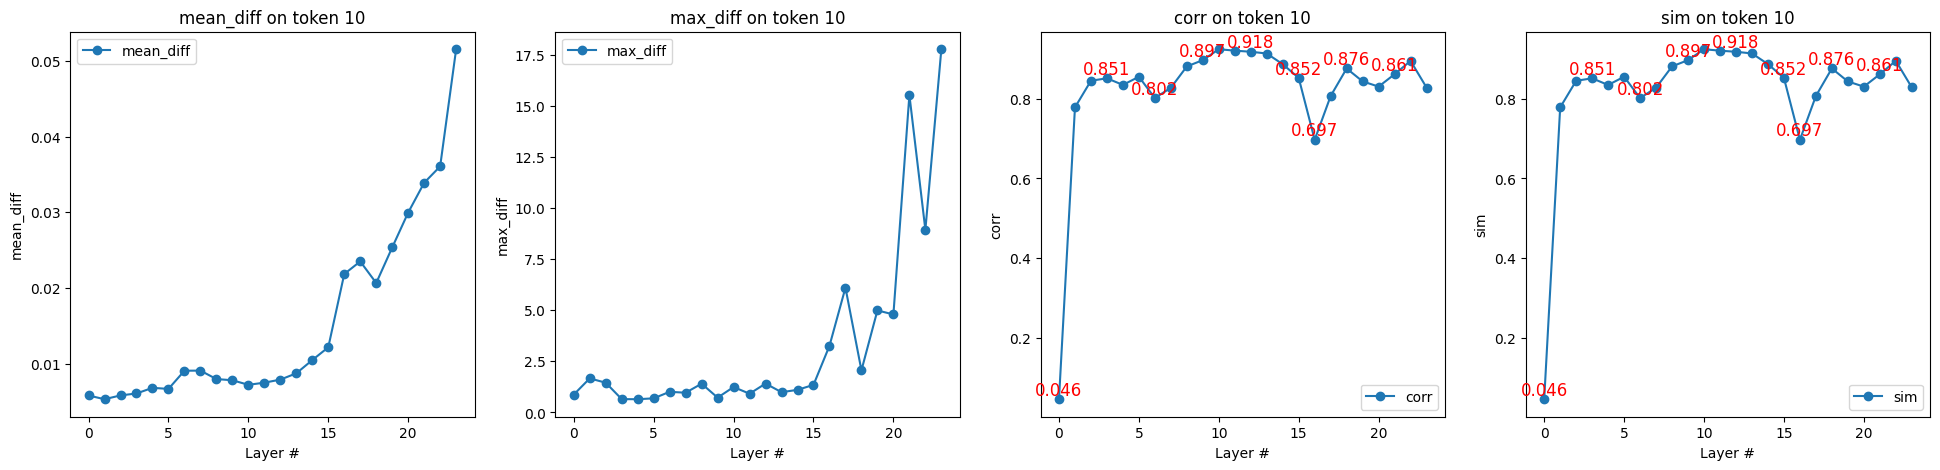

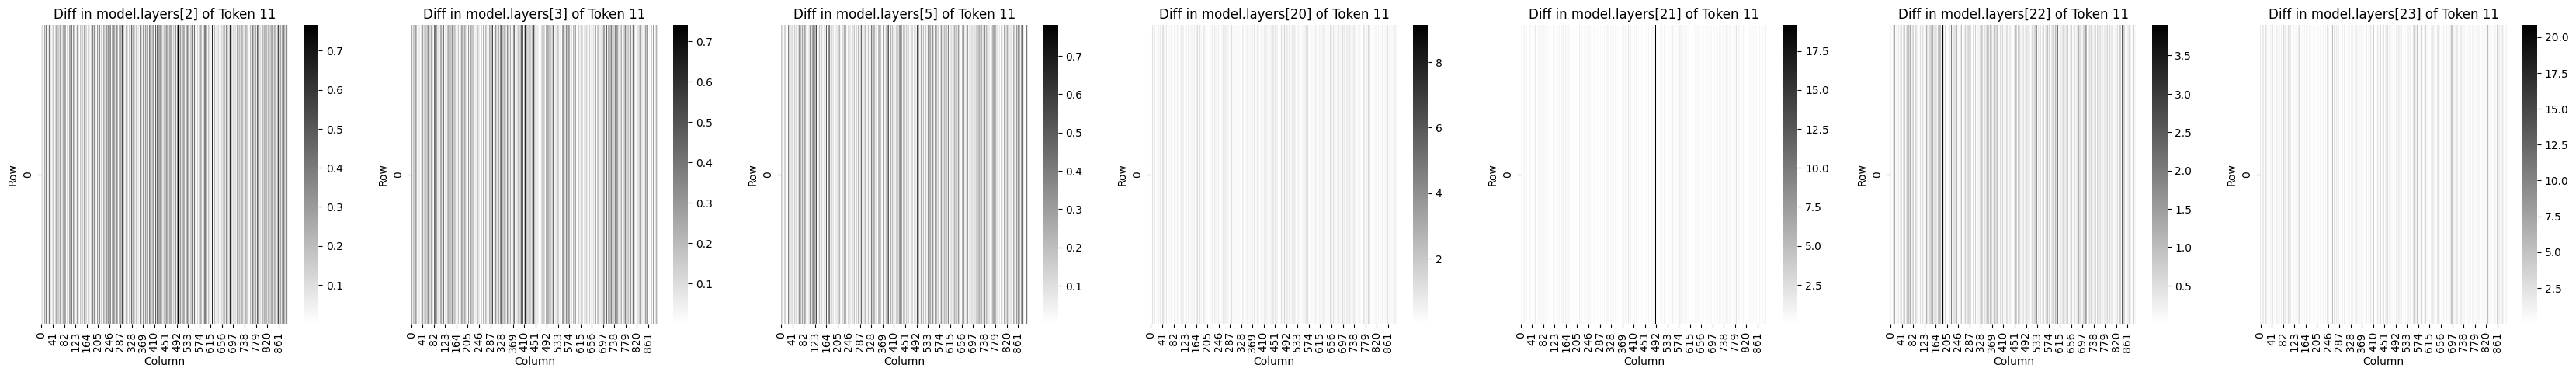

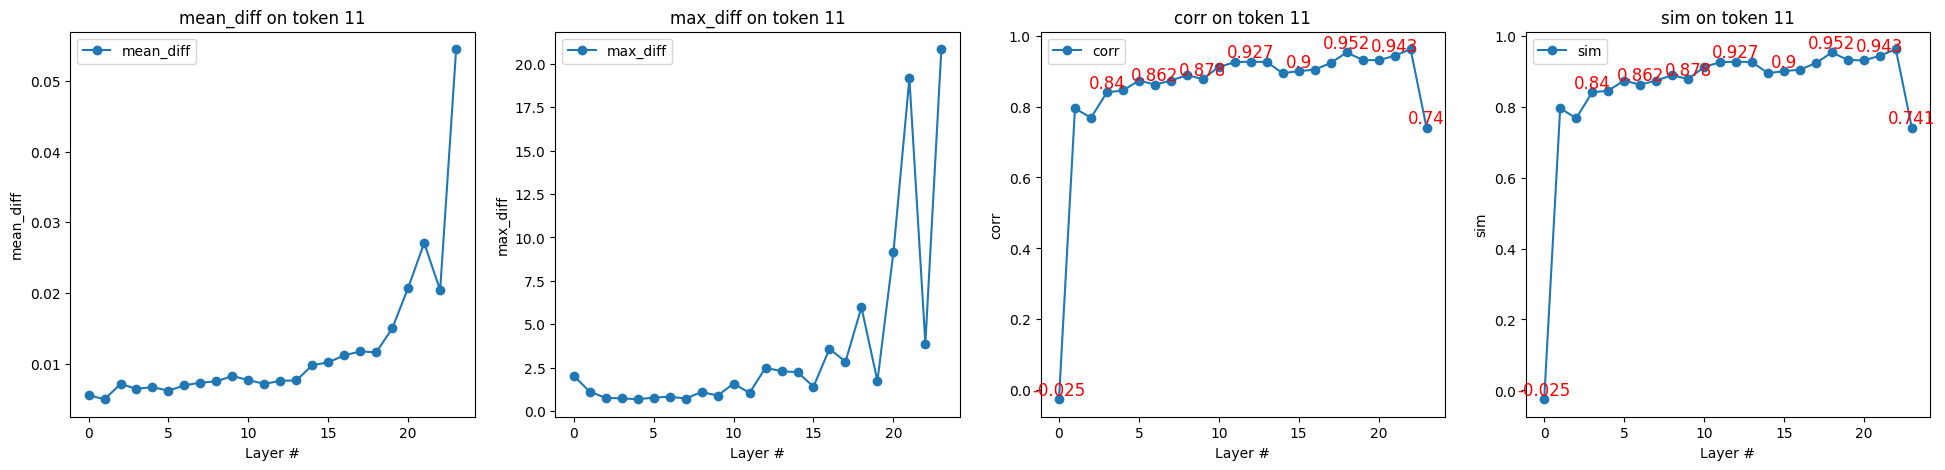

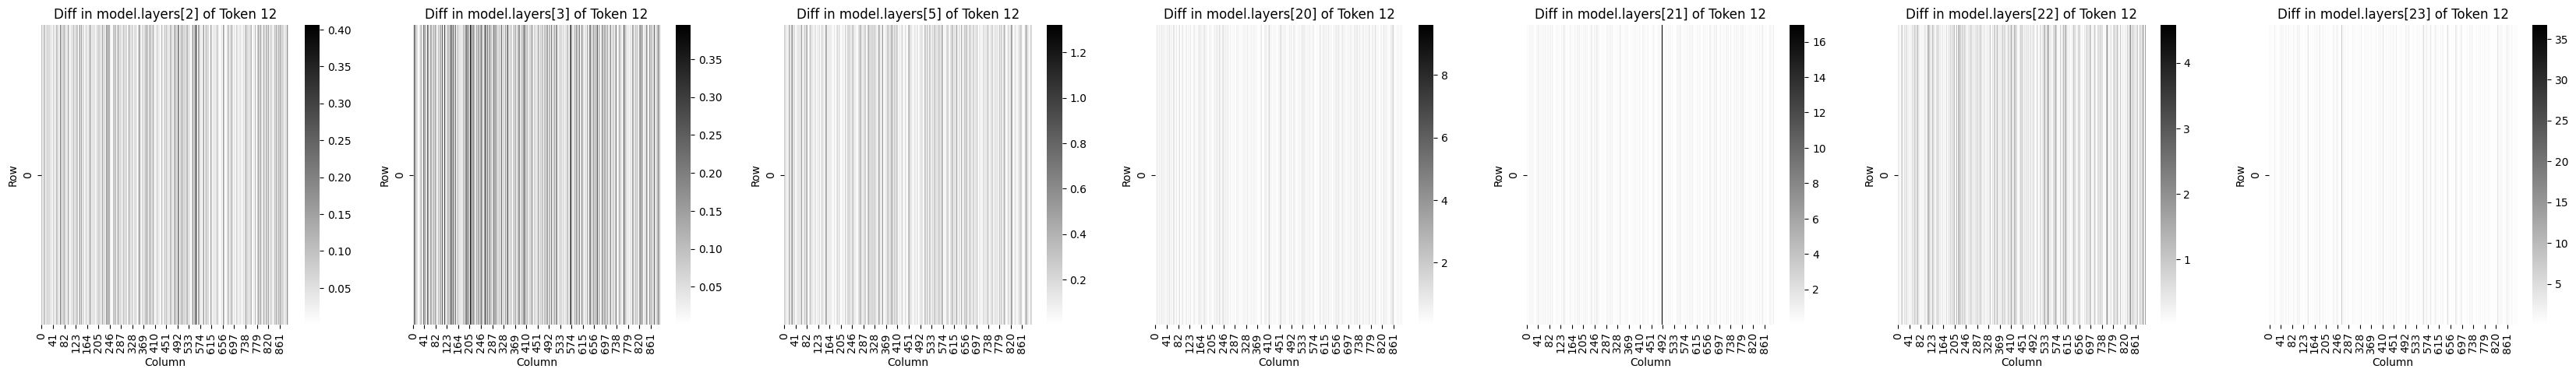

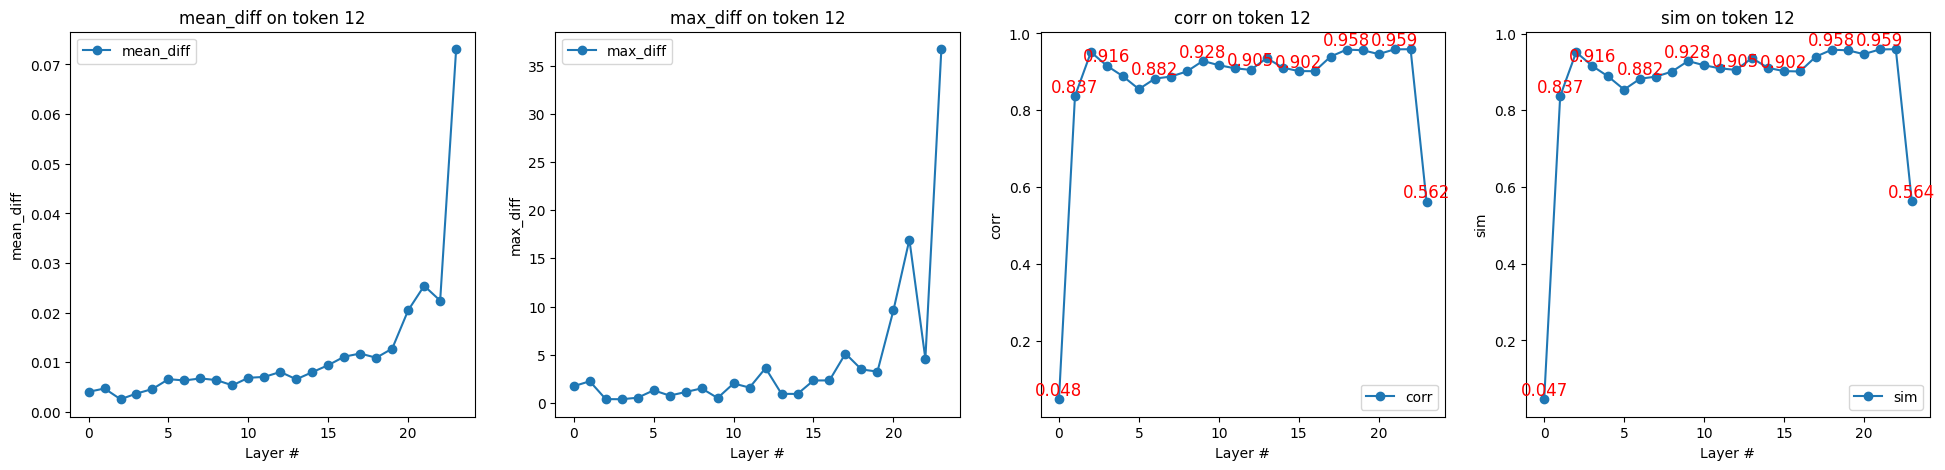

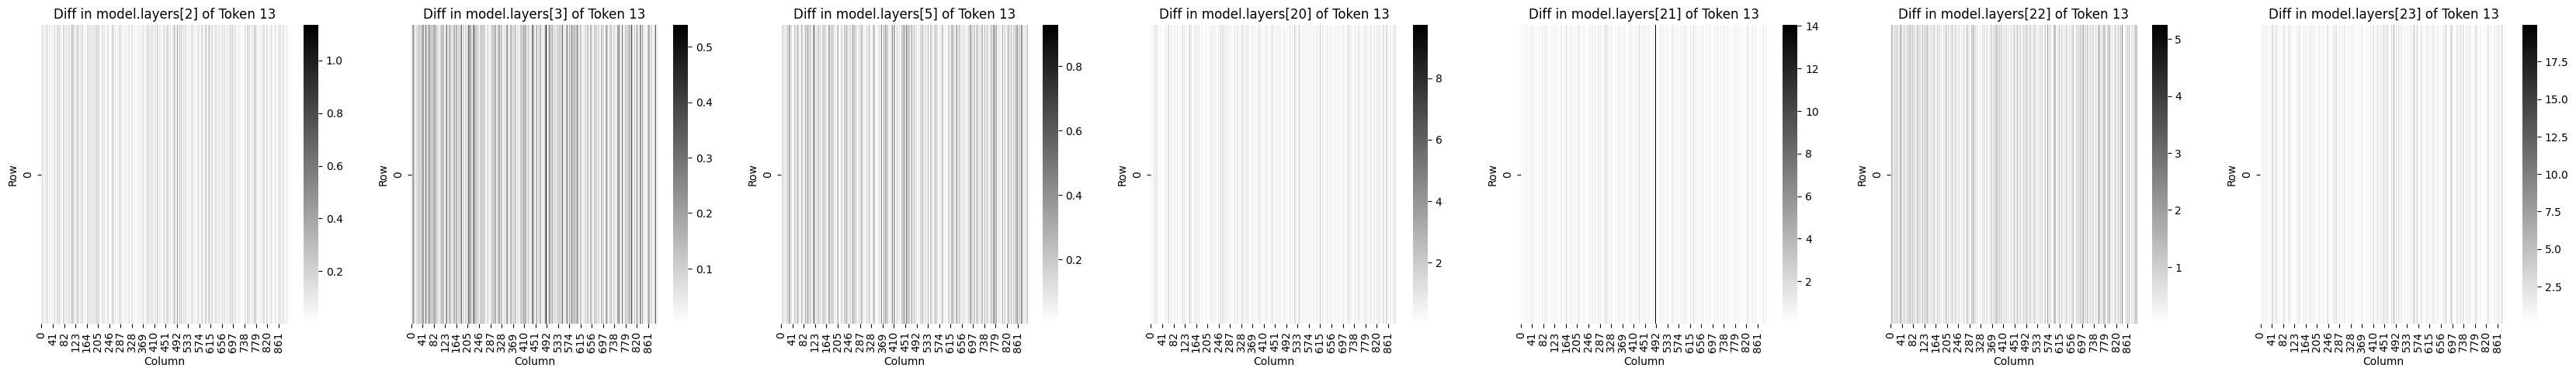

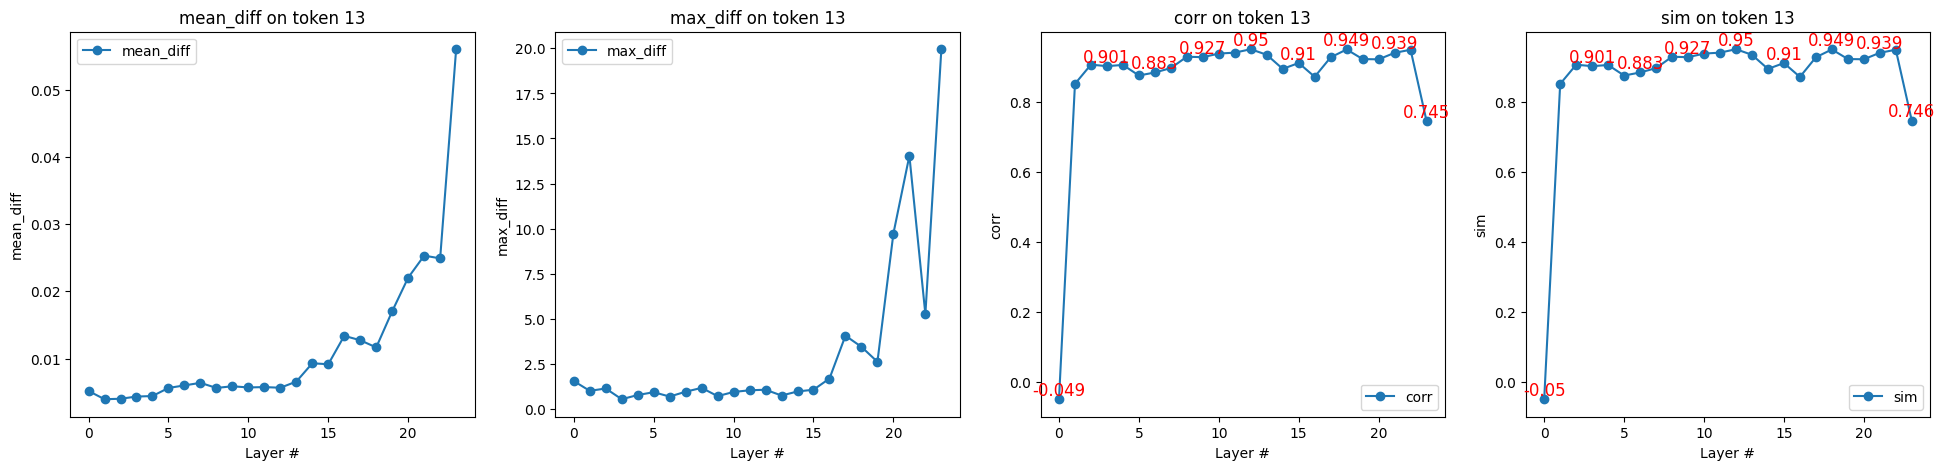

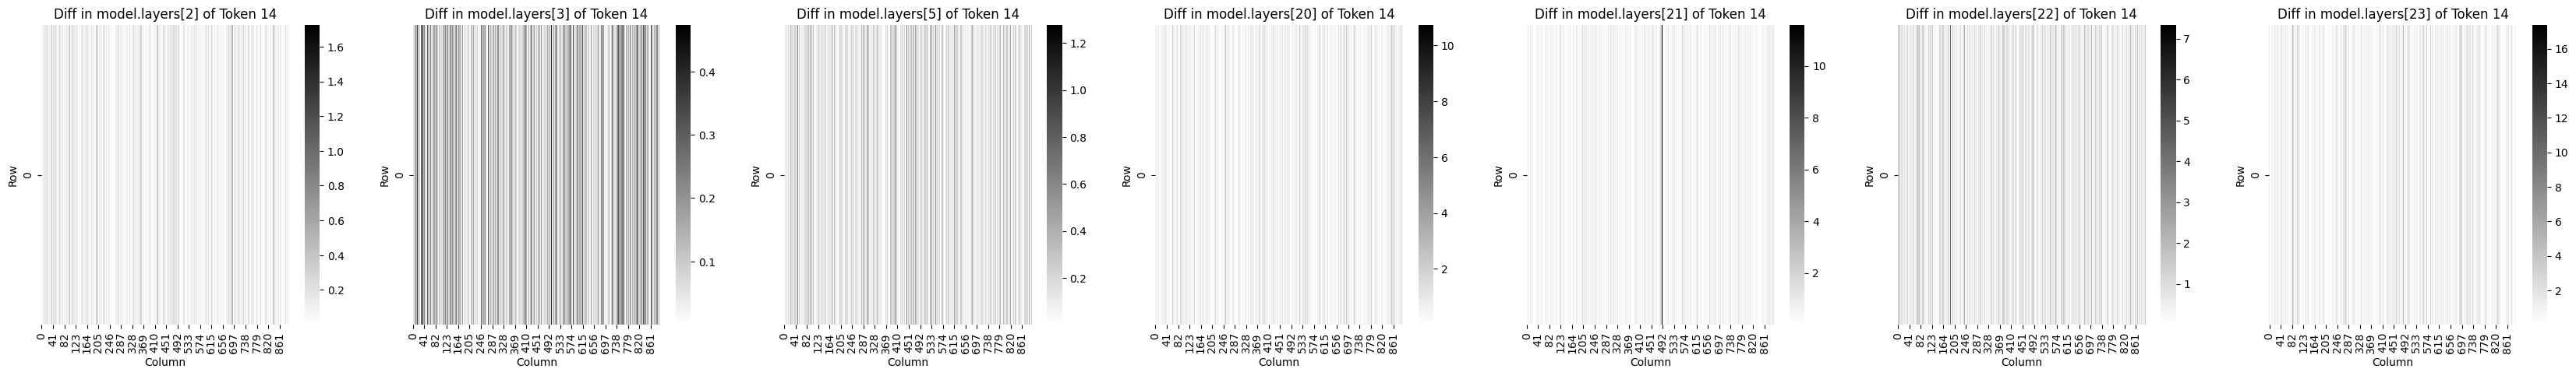

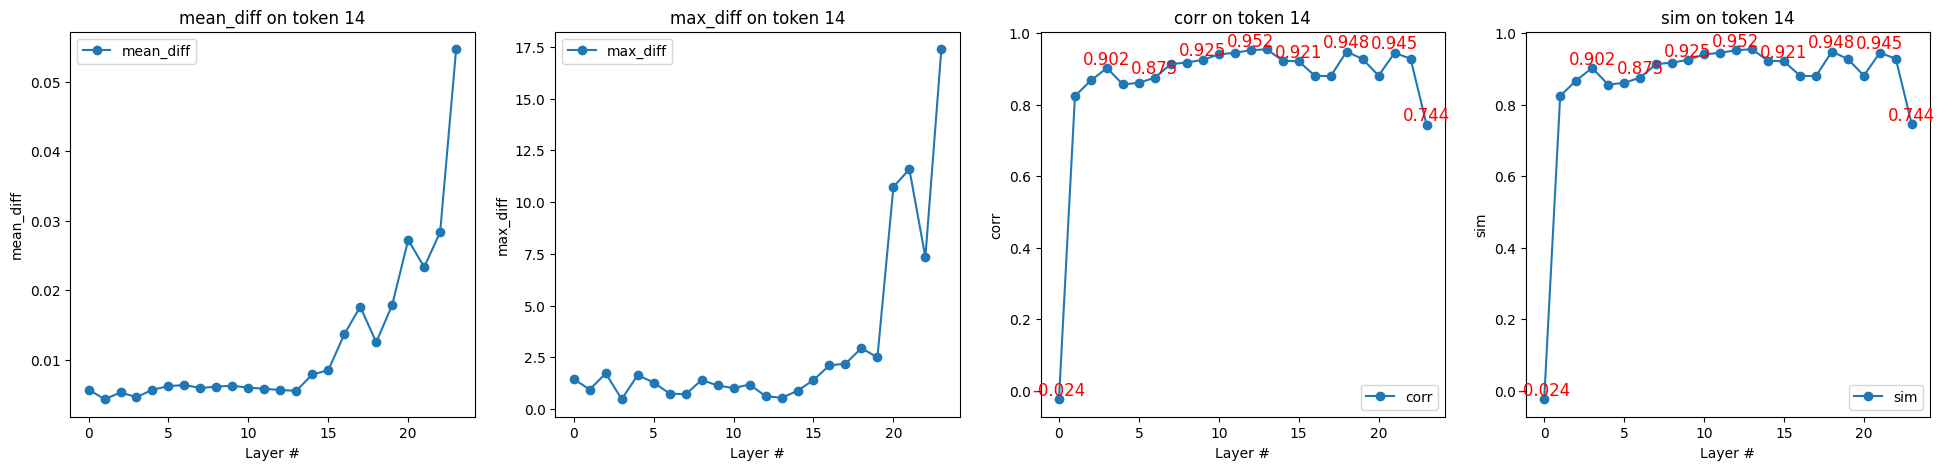

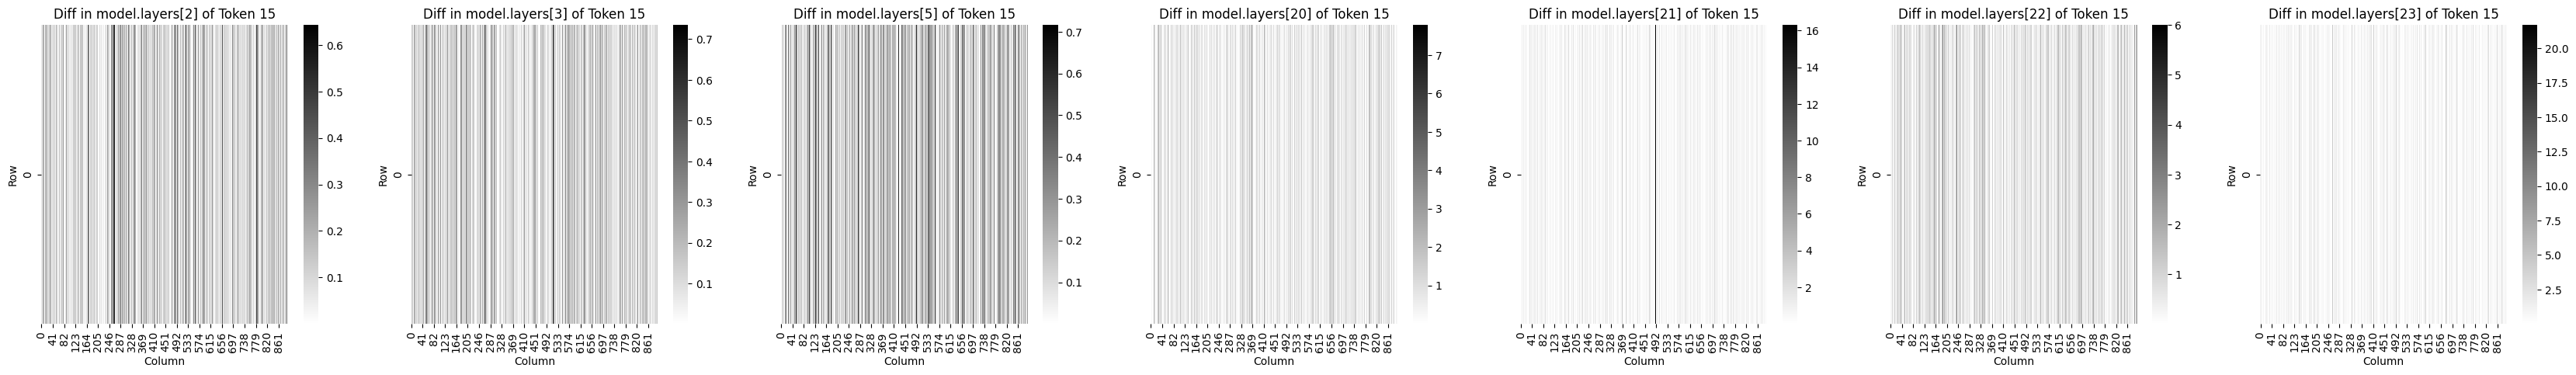

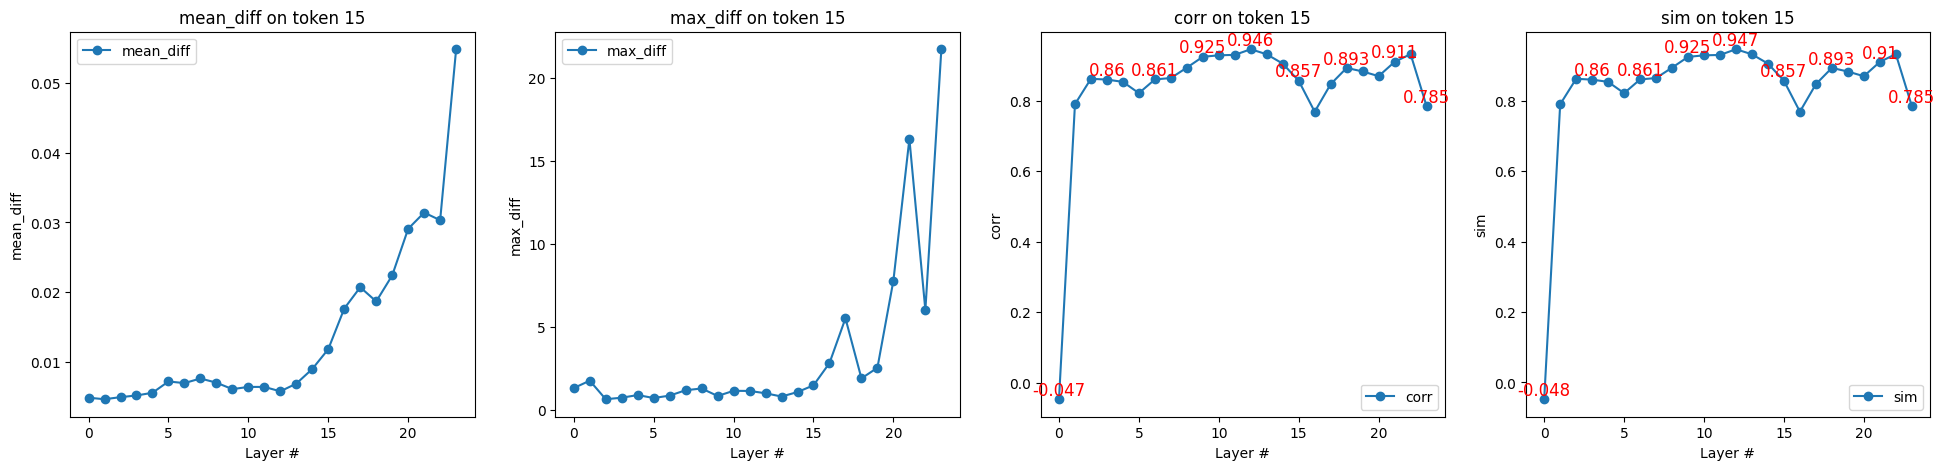

In [19]:
vertical_comparison_of_forward_hook(
    hook_data = None,
    hook_data_path = hook_data_paths[2],
    hook_module_names = [f"model.layers[{i}]" for i in range(24)],
    comparison_index = ["mean_diff", "max_diff", "corr", "sim"],
    max_length = 16,
    figure_size = 5,
    watched_module_names = [f"model.layers[{i}]" for i in [2, 3, 5, 20, 21, 22, 23]],
)

## table

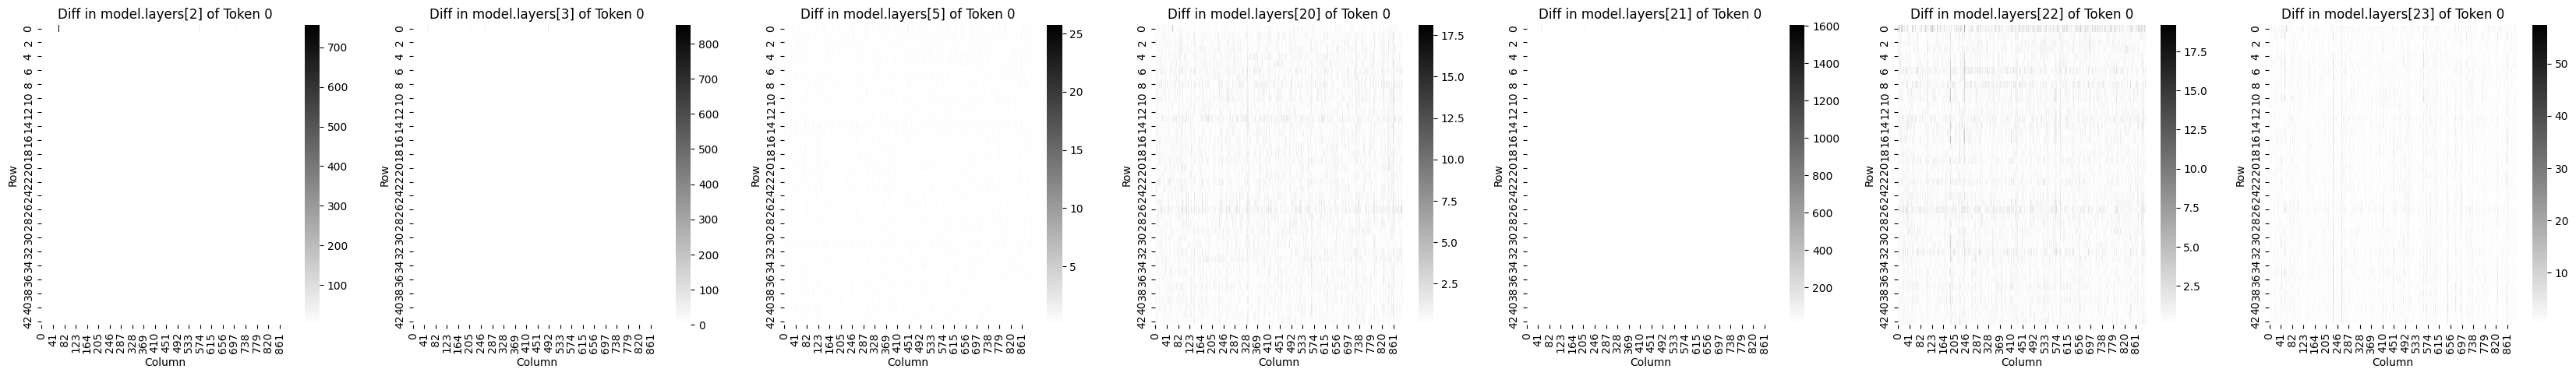

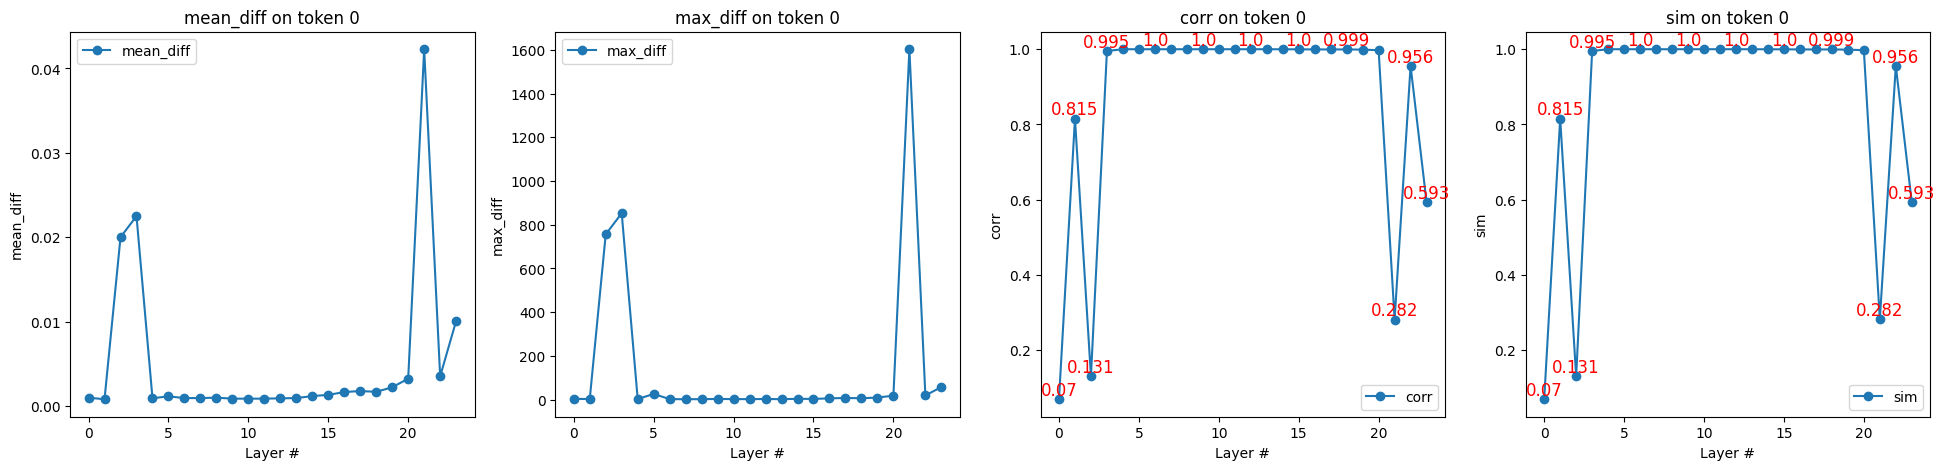

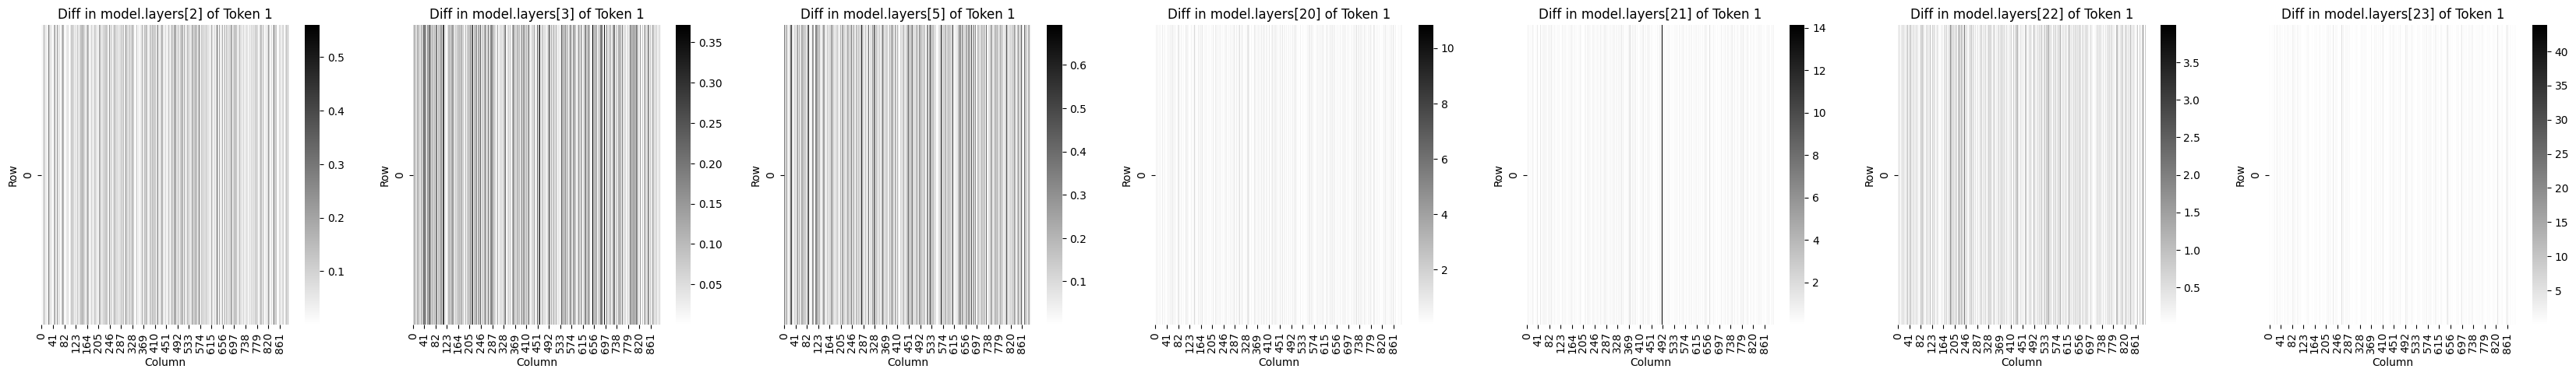

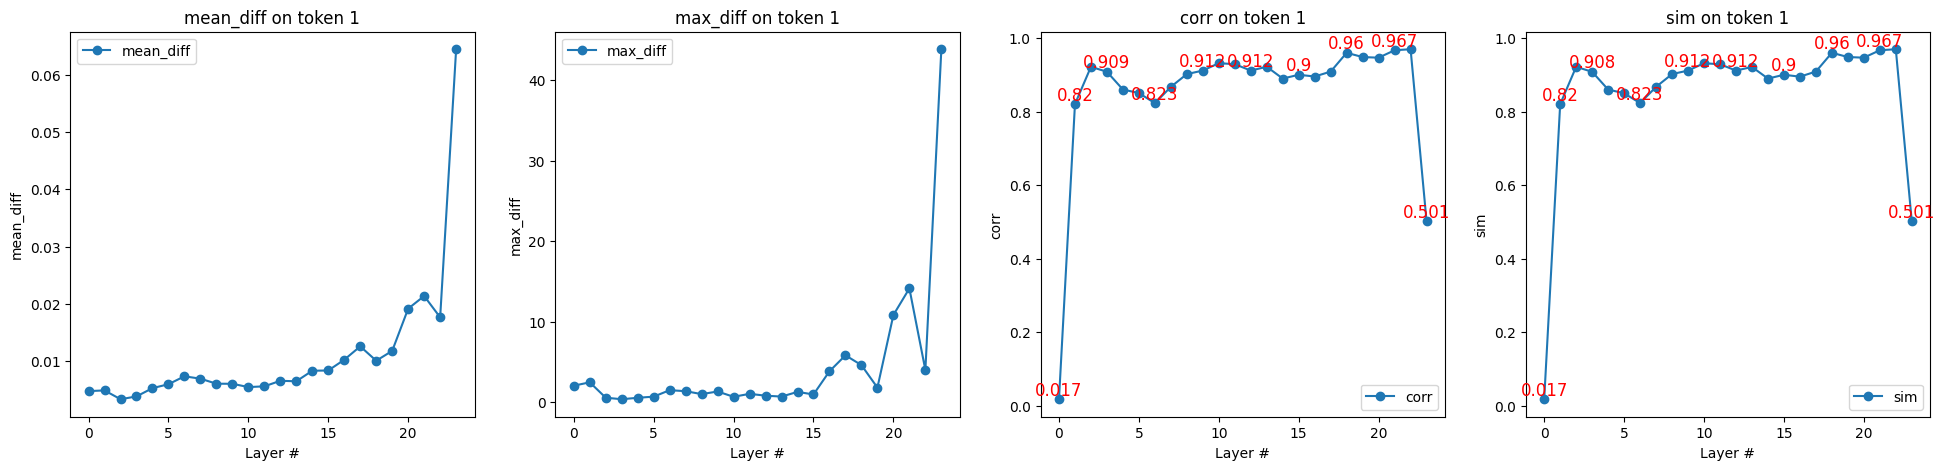

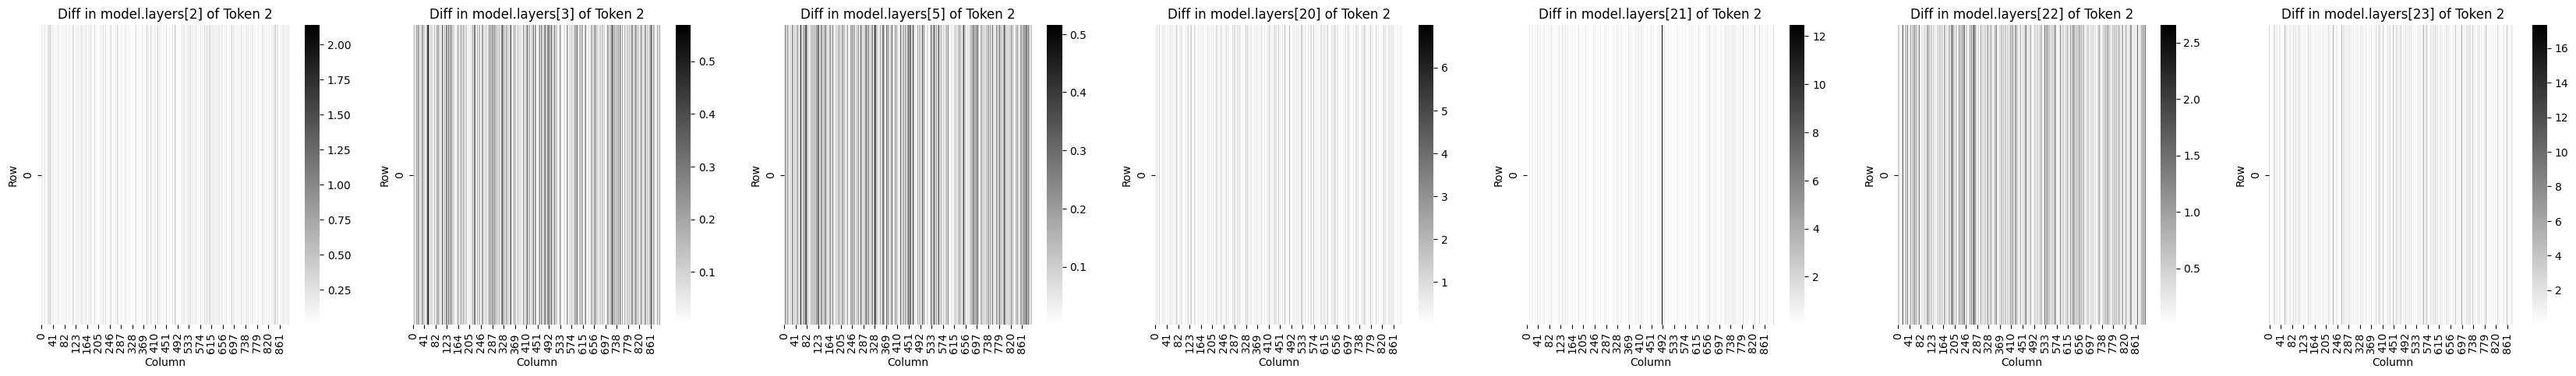

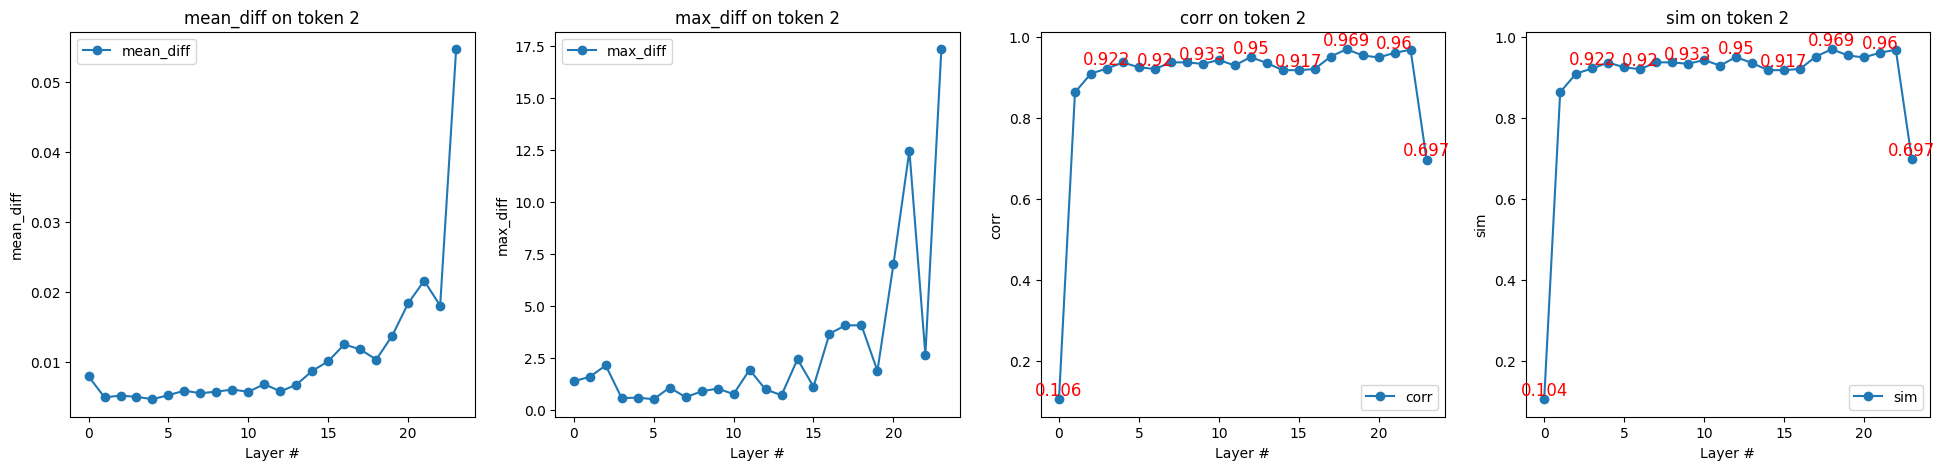

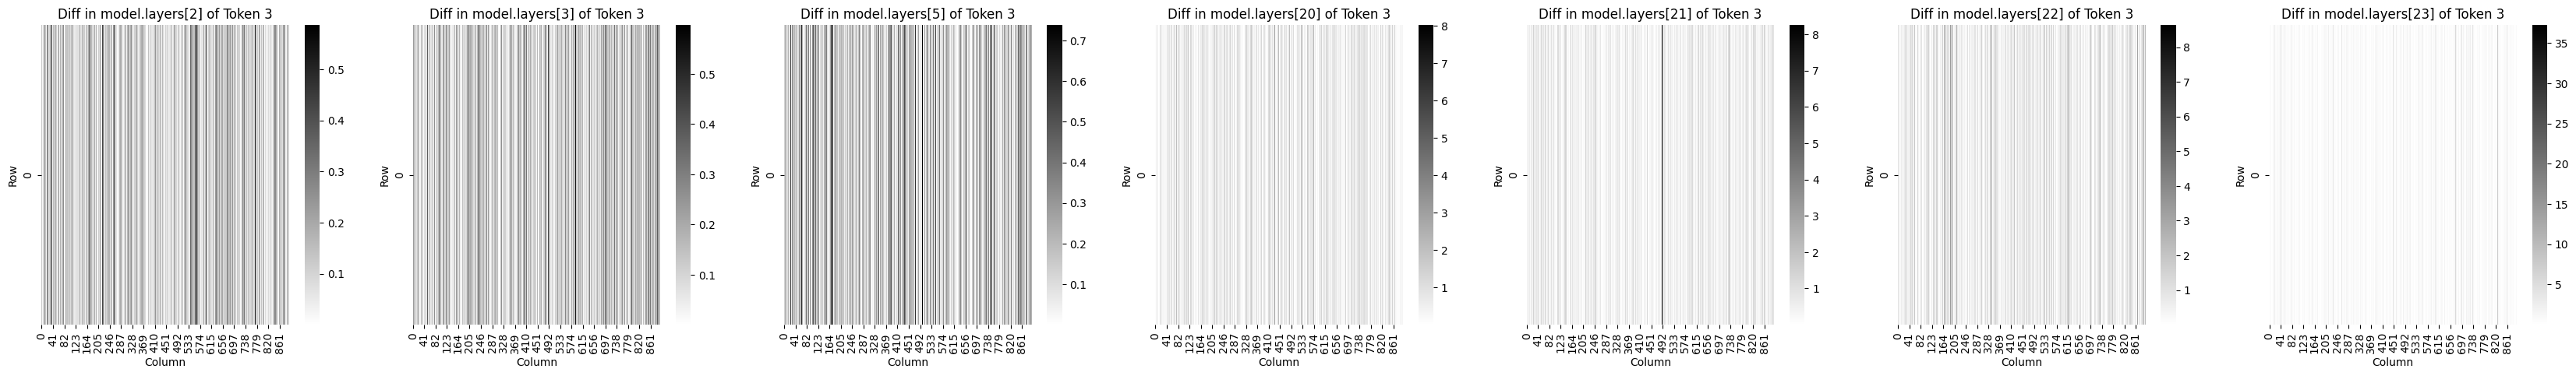

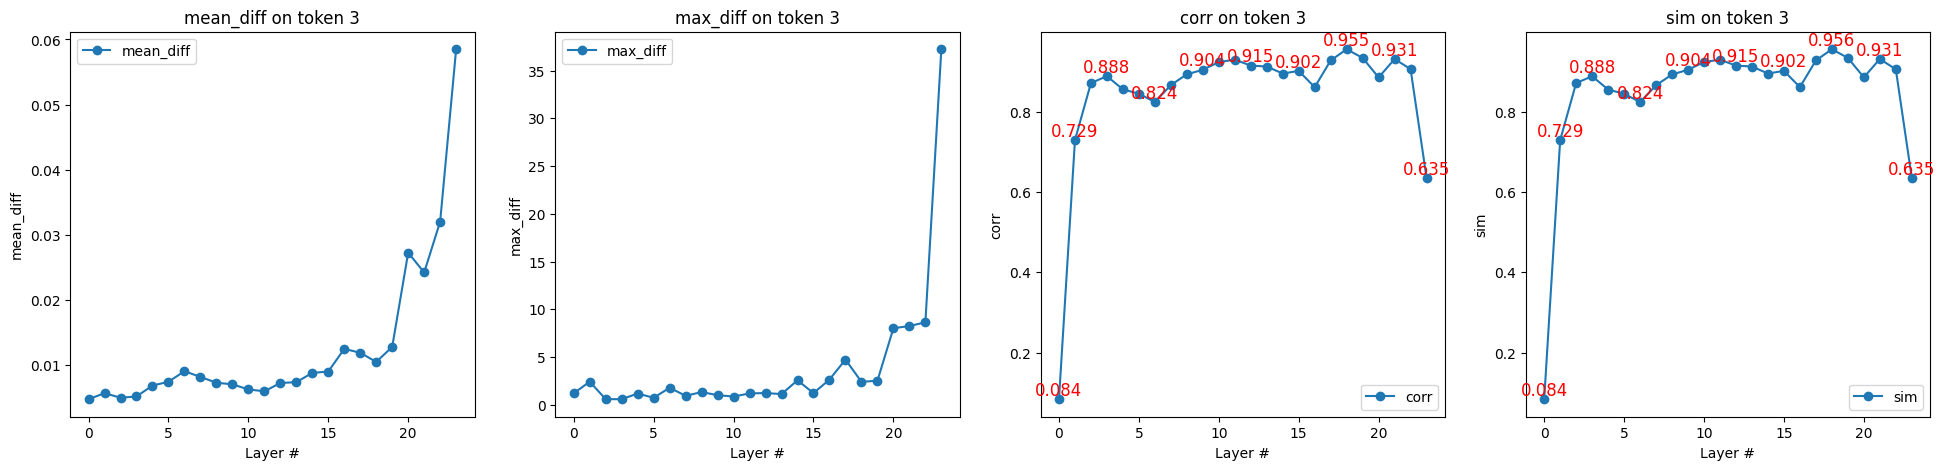

In [20]:
vertical_comparison_of_forward_hook(
    hook_data = None,
    hook_data_path = hook_data_paths[3], # prime-true
    hook_module_names = [f"model.layers[{i}]" for i in range(24)],
    comparison_index = ["mean_diff", "max_diff", "corr", "sim"],
    max_length = 4,
    figure_size = 5,
    watched_module_names = [f"model.layers[{i}]" for i in [2, 3, 5, 20, 21, 22, 23]],
)

# 测试skip_layer封装

In [3]:
from transformers import Qwen2Model, Qwen2ForCausalLM

model_path = os.path.join(model_home, model_names[0]) # Qwen2-0.5B

prompt = "很久很久以前"
max_length = 64

tokenizer = AutoTokenizer.from_pretrained(model_path)

results = skip_layer_generation(
    Model = Qwen2Model,
    ModelForCausalLM = Qwen2ForCausalLM,
    model_name_or_path = model_path,
    tokenizer = tokenizer,
    prompt = prompt,
    max_length = max_length,
    skip_layer_ids = [0],
)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [4]:
model_path = os.path.join(model_home, model_names[0]) # Qwen2-0.5B
prompt = "很久很久以前"
max_length = 64

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path)

results = easy_skip_layer_generation(
    model = model,
    tokenizer = tokenizer,
    prompt = prompt,
    max_length = max_length,
    skip_layer_ids = [0],
)

In [5]:
results = easy_skip_layer_generation(
    model = model,
    tokenizer = tokenizer,
    prompt = prompt,
    max_length = max_length,
    skip_layer_ids = [1],
)

In [6]:
results = easy_skip_layer_generation(
    model = model,
    tokenizer = tokenizer,
    prompt = prompt,
    max_length = max_length,
    skip_layer_ids = [2],
)

In [7]:
results = easy_skip_layer_generation(
    model = model,
    tokenizer = tokenizer,
    prompt = prompt,
    max_length = max_length,
    skip_layer_ids = [12],
)

In [8]:
results

{'text': '很久很久以前，我父亲患上了糖尿病，医生建议我定期检查，我应该怎样做呢？糖尿病患者应该怎样做呢？糖尿病患者应该怎样做呢？糖尿病患者应该怎样做呢？糖尿病患者应该怎样做呢？糖尿病患者应该怎样做呢？糖尿病患者应该怎样做呢？糖尿病患者应该',
 'token_probs': [(3837, '，', 0.5826794505119324),
  (35946, '我', 0.07003660500049591),
  (102037, '父亲', 0.0695599690079689),
  (99811, '患', 0.11199869215488434),
  (104157, '上了', 0.33909836411476135),
  (107218, '糖尿病', 0.0721682608127594),
  (3837, '，', 0.7270674109458923),
  (103998, '医生', 0.06342064589262009),
  (101898, '建议', 0.2523054778575897),
  (35946, '我', 0.33226877450942993),
  (104406, '定期', 0.10872867703437805),
  (101071, '检查', 0.22442638874053955),
  (3837, '，', 0.33417412638664246),
  (35946, '我', 0.06711743026971817),
  (99730, '应该', 0.07525013387203217),
  (102066, '怎样', 0.10536274313926697),
  (99190, '做', 0.12626001238822937),
  (101036, '呢', 0.4017275273799896),
  (11319, '？', 0.5955931544303894),
  (107218, '糖尿病', 0.04697014391422272),
  (101924, '患者', 0.38272759318351746),
  (99730, '应该', 0.2145463526248932),
  (102066, '怎样', 0.16071169078